In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import pytorch3d
from pytorch3d.ops import sample_points_from_meshes
# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes, Pointclouds

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate
from pytorch3d.renderer.mesh.shading import (
    _apply_lighting,
)

# rendering components
from pytorch3d.renderer import (
    FoVOrthographicCameras, 
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor,
    SoftPhongShader,
)

In [2]:
# Set the cuda device
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Load the obj and ignore the textures and materials.
verts, faces_idx, _ =  load_obj("./data/teapot.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None] # (1, V, 3)
textures =  TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch
teapot_mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures,
)

In [3]:
n_points = 1000000
vertices, normals = sample_points_from_meshes(teapot_mesh, 
    n_points, return_normals=True)

vertices =  vertices[0]#.to(device)
normals =  normals[0]#.to(device)

rgb = torch.ones((n_points, 4), device=device) - 0.3
# point_cloud = Pointclouds(points=vertices, 
#                           #normals=[normals[0]],
#                          )


point_cloud = Pointclouds(points=[vertices], 
                          normals=[normals],
                          features=[rgb],
                         )


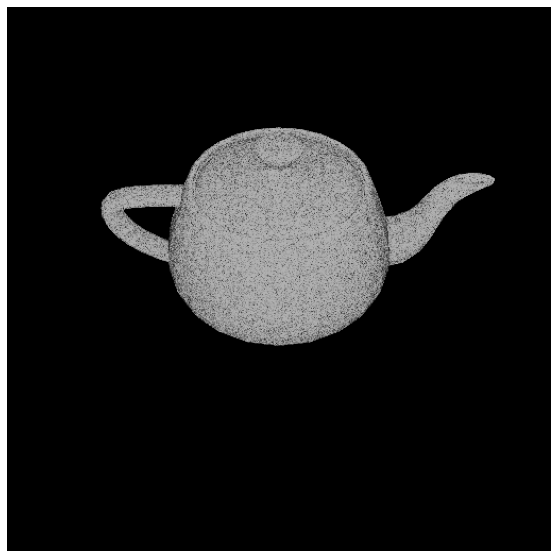

In [4]:
R, T = look_at_view_transform(100, 100, 10000)

# Select the viewpoint using spherical angles
distance = 3 # Distance from camera to the object
elevation = 50. # angle of elevation in degrees
azimuth = 0.0 # No rotation so the camera is positioned on the +Z axis

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)


cameras = FoVPerspectiveCameras(device=device, R=R, T=T, 
                                znear=0.1, zfar=1)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters. 
raster_settings = PointsRasterizationSettings(
    image_size=512, 
    radius = 0.003,
    points_per_pixel = 4
)


# Create a points renderer by compositing points using an alpha compositor (nearer points
# are weighted more heavily). See [1] for an explanation.
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
points_renderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=AlphaCompositor()
)
images = points_renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [5]:
points_fragments =  points_renderer.rasterizer(point_cloud)
points_fragments.idx.shape

torch.Size([1, 512, 512, 4])

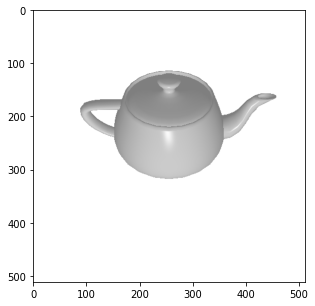

In [6]:
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
#R, T = look_at_view_transform(2.7, 0, 180) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=4, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 1.0, 3.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)
images = renderer(teapot_mesh)
plt.figure(figsize=(5, 5))
plt.imshow(images[0, ..., :3].cpu().numpy());

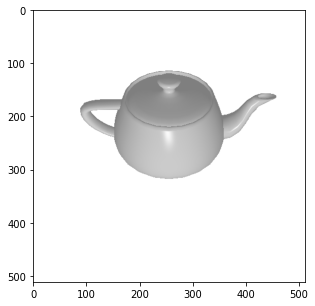

In [7]:
fragments = renderer.rasterizer(teapot_mesh)
images = renderer.shader(fragments, teapot_mesh)
plt.figure(figsize=(5, 5))
plt.imshow(images[0, ..., :3].cpu().numpy());

In [10]:
texels = teapot_mesh.sample_textures(fragments)
lights = renderer.shader.lights
materials = renderer.shader.materials
blend_params = renderer.shader.blend_params
blend_params = BlendParams(background_color=(0.1, 0.1, 0.1))
texels.shape, lights, materials, blend_params

NameError: name 'fragments' is not defined

In [9]:
from pytorch3d.renderer.mesh.shading import phong_shading
from pytorch3d.renderer.blending import softmax_rgb_blend
colors = phong_shading(
            meshes=teapot_mesh,
            fragments=fragments,
            texels=texels,
            lights=lights,
            cameras=cameras,
            materials=materials,
        )
colors.shape

torch.Size([1, 512, 512, 4, 3])

In [10]:
znear = getattr(cameras, "znear", 1.0)
zfar = getattr(cameras, "zfar", 100.0)
images = softmax_rgb_blend(
            colors, fragments, blend_params, znear=znear, zfar=zfar
        )
images.shape

torch.Size([1, 512, 512, 4])

In [11]:
from pytorch3d.ops.interp_face_attrs import (
    interpolate_face_attributes,
    interpolate_face_attributes_python,
)


meshes = teapot_mesh
verts = meshes.verts_packed()  # (V, 3)

faces = meshes.faces_packed()  # (F, 3)
vertex_normals = meshes.verts_normals_packed()  # (V, 3)
print(verts.shape, faces.shape, vertex_normals.shape)
faces_verts = verts[faces]
print(faces_verts.shape)

faces_normals = vertex_normals[faces]
print(faces_normals.shape)
pixel_coords = interpolate_face_attributes(
    fragments.pix_to_face, fragments.bary_coords, faces_verts
)
print('pixel_coords', pixel_coords.shape)
pixel_normals = interpolate_face_attributes(
    fragments.pix_to_face, fragments.bary_coords, faces_normals
)
print('pixel_normals', pixel_normals.shape)

ambient, diffuse, specular = _apply_lighting(
    pixel_coords, pixel_normals, lights, cameras, materials
)
colors = (ambient + diffuse) * texels + specular

torch.Size([1292, 3]) torch.Size([2464, 3]) torch.Size([1292, 3])
torch.Size([2464, 3, 3])
torch.Size([2464, 3, 3])
pixel_coords torch.Size([1, 512, 512, 4, 3])
pixel_normals torch.Size([1, 512, 512, 4, 3])


In [12]:
def interpolate_face_attributes_python(
    pix_to_face: torch.Tensor,
    barycentric_coords: torch.Tensor,
    face_attributes: torch.Tensor,
) -> torch.Tensor:
    F, FV, D = face_attributes.shape
    N, H, W, K, _ = barycentric_coords.shape

    # Replace empty pixels in pix_to_face with 0 in order to interpolate.
    mask = pix_to_face < 0
    pix_to_face = pix_to_face.clone()
    pix_to_face[mask] = 0
    idx = pix_to_face.view(N * H * W * K, 1, 1).expand(N * H * W * K, 3, D)
    # pyre-fixme[16]: `Tensor` has no attribute `gather`.
    pixel_face_vals = face_attributes.gather(0, idx).view(N, H, W, K, 3, D)
    pixel_vals = (barycentric_coords[..., None] * pixel_face_vals).sum(dim=-2)
    pixel_vals[mask] = 0  # Replace masked values in output.
    return pixel_vals

In [13]:
fragments.pix_to_face.shape

torch.Size([1, 512, 512, 4])

In [16]:
if False:
    class PointsRenderer(nn.Module):    
        self.rasterizer = rasterizer
        self.compositor = compositor
        
        def forward(self, point_clouds, **kwargs) -> torch.Tensor:
            fragments = self.rasterizer(point_clouds, **kwargs)
            # Construct weights based on the distance of a point to the true point.
            # However, this could be done differently: e.g. predicted as opposed
            # to a function of the weights.
            r = self.rasterizer.raster_settings.radius

            dists2 = fragments.dists.permute(0, 3, 1, 2)
            weights = 1 - dists2 / (r * r)
            images = self.compositor(
                fragments.idx.long().permute(0, 3, 1, 2),
                weights,
                point_clouds.features_packed().permute(1, 0),
                **kwargs,
            )
            # permute so image comes at the end
            images = images.permute(0, 2, 3, 1)
            return images

In [140]:
def _apply_lighting(
    points, normals, lights, cameras, materials
): # -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Args:
        points: torch tensor of shape (N, P, 3) or (P, 3).
        normals: torch tensor of shape (N, P, 3) or (P, 3)
        lights: instance of the Lights class.
        cameras: instance of the Cameras class.
        materials: instance of the Materials class.
    Returns:
        ambient_color: same shape as materials.ambient_color
        diffuse_color: same shape as the input points
        specular_color: same shape as the input points
    """
    light_diffuse = lights.diffuse(normals=normals, points=points)
    light_specular = lights.specular(
        normals=normals,
        points=points,
        camera_position=cameras.get_camera_center(),
        shininess=materials.shininess,
    )
    ambient_color = materials.ambient_color * lights.ambient_color
    diffuse_color = materials.diffuse_color * light_diffuse
    specular_color = materials.specular_color * light_specular
    if normals.dim() == 2 and points.dim() == 2:
        # If given packed inputs remove batch dim in output.
        return (
            ambient_color.squeeze(),
            diffuse_color.squeeze(),
            specular_color.squeeze(),
        )
    return ambient_color, diffuse_color, specular_color

print('pixel_coords', pixel_coords.shape)
print('pixel_normals', pixel_normals.shape)
ambient, diffuse, specular = _apply_lighting(
    pixel_coords, pixel_normals, lights, cameras, materials
)

pixel_coords torch.Size([1, 512, 512, 4, 3])
pixel_normals torch.Size([1, 512, 512, 4, 3])


In [18]:
light_diffuse = lights.diffuse(normals=pixel_normals, points=pixel_coords)
light_diffuse.shape, pixel_normals.shape, pixel_coords.shape

(torch.Size([1, 512, 512, 4, 3]),
 torch.Size([1, 512, 512, 4, 3]),
 torch.Size([1, 512, 512, 4, 3]))

In [19]:
light_specular = lights.specular(
    normals=pixel_normals,
    points=pixel_coords,
    camera_position=cameras.get_camera_center(),
    shininess=materials.shininess,
)
light_specular.shape

torch.Size([1, 512, 512, 4, 3])

In [34]:
def interpolate_face_attributes_python(
    pix_to_face: torch.Tensor,
    barycentric_coords: torch.Tensor,
    face_attributes: torch.Tensor,
) -> torch.Tensor:
    F, FV, D = face_attributes.shape
    N, H, W, K, _ = barycentric_coords.shape

    # Replace empty pixels in pix_to_face with 0 in order to interpolate.
    mask = pix_to_face < 0
    pix_to_face = pix_to_face.clone()
    pix_to_face[mask] = 0
    idx = pix_to_face.view(N * H * W * K, 1, 1).expand(N * H * W * K, 3, D)
    # pyre-fixme[16]: `Tensor` has no attribute `gather`.
    pixel_face_vals = face_attributes.gather(0, idx).view(N, H, W, K, 3, D)
    pixel_vals = (barycentric_coords[..., None] * pixel_face_vals).sum(dim=-2)
    pixel_vals[mask] = 0  # Replace masked values in output.
    return pixel_vals

pixel_normals = interpolate_face_attributes(
    fragments.pix_to_face, fragments.bary_coords, faces_normals
)

points_fragments.idx.shape, fragments.pix_to_face.shape, faces_normals.shape

(torch.Size([1, 512, 512, 4]),
 torch.Size([1, 512, 512, 4]),
 torch.Size([2464, 3, 3]))

(torch.Size([1000000, 3]), torch.Size([1000000, 3]))

In [33]:
vertices.gather(0, points_fragments.idx.long())

RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [32]:
vertices.device, points_fragments.idx.dtype

(device(type='cuda', index=0), torch.int32)

In [50]:
pix_to_face = fragments.pix_to_face
barycentric_coords = fragments.bary_coords
#face_attributes = faces_normals
    
F, FV, D = face_attributes.shape
N, H, W, K, _ = barycentric_coords.shape

# Replace empty pixels in pix_to_face with 0 in order to interpolate.
mask = pix_to_face < 0
pix_to_face = pix_to_face.clone()
pix_to_face[mask] = 0
idx = pix_to_face.view(N * H * W * K, 1, 1).expand(N * H * W * K, 3, D)
print('idx', idx.shape)
# pyre-fixme[16]: `Tensor` has no attribute `gather`.
pixel_face_vals = faces_normals.gather(0, idx)#.view(N, H, W, K, 3, D)
print('pixel_face_vals', pixel_face_vals.shape)
pixel_face_vals = faces_normals.gather(0, idx).view(N, H, W, K, 3, D)
print('pixel_face_vals', pixel_face_vals.shape)
pixel_vals = (barycentric_coords[..., None] * pixel_face_vals).sum(dim=-2)
pixel_vals[mask] = 0  

print('faces_normals', faces_normals.shape)
print('pix_to_face', pix_to_face.shape)
print('pixel_vals', pixel_vals.shape)

idx torch.Size([1048576, 3, 3])
pixel_face_vals torch.Size([1048576, 3, 3])
pixel_face_vals torch.Size([1, 512, 512, 4, 3, 3])
faces_normals torch.Size([2464, 3, 3])
pix_to_face torch.Size([1, 512, 512, 4])
pixel_vals torch.Size([1, 512, 512, 4, 3])


In [47]:
vertices =  point_cloud.points_packed()
normals =  point_cloud.normals_packed()
vertices.shape, normals.shape, points_fragments.idx.long().shape

(torch.Size([1000000, 3]),
 torch.Size([1000000, 3]),
 torch.Size([1, 512, 512, 4]))

In [91]:
N, H, W, K = points_fragments.idx.shape

D = 4 # Fixed probably. what about alpha ??? 
pix_to_point  = points_fragments.idx
# Replace empty pixels in pix_to_face with 0 in order to interpolate.
mask = pix_to_point < 0
pix_to_point = pix_to_point.clone()
pix_to_point[mask] = 0

print('pix_to_point.shape',  pix_to_point.shape)

idx = pix_to_point.view(N * H * W * K, 1).expand(N * H * W * K, 3)
print('idx', idx.shape)



pixel_face_vals = normals.gather(0, idx.long()).view(N, H, W, K, 3)
pixel_face_vals.shape

pix_to_point.shape torch.Size([1, 512, 512, 4])
idx torch.Size([1048576, 3])


In [79]:
vertices.shape

torch.Size([1000000, 3])

In [80]:
barycentric_coords.shape

torch.Size([1, 512, 512, 4, 3])

In [93]:
points_fragments.dists[..., None].shape

torch.Size([1, 512, 512, 4, 1])

In [82]:
pixel_vals = (points_fragments.dists[..., None] * pixel_face_vals).sum(dim=-2)
pixel_vals[mask] = 0  

IndexError: The shape of the mask [1, 512, 512, 4] at index 3 does not match the shape of the indexed tensor [1, 512, 512, 3] at index 3

In [85]:
mask.shape,pixel_vals.shape

(torch.Size([1, 512, 512, 4]), torch.Size([1, 512, 512, 3]))

In [98]:
points_fragments.dists.shape

torch.Size([1, 512, 512, 4])

In [111]:
for e in points_fragments.dists.view(-1, 4):
    if e.sum() > -4:
        print(e)

tensor([ 8.8596e-06,  8.8545e-06, -1.0000e+00, -1.0000e+00], device='cuda:0')
tensor([ 7.6464e-06,  8.1881e-06,  8.6067e-06, -1.0000e+00], device='cuda:0')
tensor([7.8873e-06, 5.6438e-06, 5.9710e-06, 7.0637e-06], device='cuda:0')
tensor([8.8484e-06, 7.4613e-06, 8.4055e-06, 7.3349e-06], device='cuda:0')
tensor([8.7874e-06, 7.5997e-06, 8.1088e-06, 7.3506e-06], device='cuda:0')
tensor([8.4964e-06, 8.7624e-06, 7.2507e-06, 8.2860e-06], device='cuda:0')
tensor([ 7.4698e-06,  6.7104e-06,  7.3352e-06, -1.0000e+00], device='cuda:0')
tensor([ 8.8924e-06, -1.0000e+00, -1.0000e+00, -1.0000e+00], device='cuda:0')
tensor([ 7.6641e-06, -1.0000e+00, -1.0000e+00, -1.0000e+00], device='cuda:0')
tensor([7.7780e-06, 6.8183e-06, 8.5320e-06, 6.4740e-06], device='cuda:0')
tensor([6.0528e-06, 5.3146e-06, 6.0390e-06, 6.8941e-06], device='cuda:0')
tensor([8.2368e-06, 7.7165e-06, 7.4178e-06, 7.8743e-06], device='cuda:0')
tensor([7.7085e-06, 7.9623e-06, 5.7964e-06, 7.3557e-06], device='cuda:0')
tensor([8.8981e-06

tensor([8.5044e-06, 5.8120e-06, 3.6000e-06, 6.5740e-06], device='cuda:0')
tensor([6.9427e-06, 5.7872e-06, 5.4961e-06, 2.9993e-06], device='cuda:0')
tensor([8.9149e-06, 1.7575e-06, 1.9614e-06, 1.1035e-06], device='cuda:0')
tensor([8.8185e-06, 8.6731e-06, 6.4517e-06, 5.3447e-06], device='cuda:0')
tensor([6.5657e-06, 4.5557e-06, 6.7903e-06, 3.4490e-06], device='cuda:0')
tensor([4.1508e-06, 4.3469e-06, 6.8716e-06, 3.2063e-06], device='cuda:0')
tensor([8.5702e-06, 7.0655e-06, 5.1078e-06, 2.5076e-06], device='cuda:0')
tensor([5.5248e-06, 1.1205e-06, 6.9168e-07, 3.6024e-07], device='cuda:0')
tensor([3.1154e-06, 3.2441e-06, 3.5295e-06, 4.9387e-06], device='cuda:0')
tensor([7.7202e-06, 4.1369e-06, 3.4270e-06, 3.9178e-06], device='cuda:0')
tensor([6.9518e-06, 3.5348e-06, 4.0224e-06, 5.5676e-06], device='cuda:0')
tensor([3.6728e-06, 2.0735e-06, 3.3925e-06, 2.8155e-06], device='cuda:0')
tensor([6.6635e-06, 4.4416e-06, 4.1828e-06, 7.7225e-06], device='cuda:0')
tensor([5.5439e-06, 1.8482e-06, 2.1491

tensor([3.8020e-06, 8.7883e-06, 3.2563e-06, 6.6666e-06], device='cuda:0')
tensor([8.1072e-06, 3.5094e-06, 1.7105e-07, 3.7179e-06], device='cuda:0')
tensor([5.2085e-06, 6.3140e-06, 1.7787e-06, 3.3322e-07], device='cuda:0')
tensor([5.8907e-06, 8.6978e-06, 3.1148e-06, 3.1036e-06], device='cuda:0')
tensor([6.0881e-06, 8.6638e-06, 4.7597e-06, 1.1402e-07], device='cuda:0')
tensor([3.2159e-06, 3.2540e-06, 5.6685e-06, 5.7069e-06], device='cuda:0')
tensor([2.6540e-06, 6.3512e-07, 4.2511e-06, 4.5136e-06], device='cuda:0')
tensor([5.2278e-06, 3.1216e-06, 4.6979e-06, 1.2913e-06], device='cuda:0')
tensor([5.9912e-06, 2.6465e-06, 4.2229e-06, 6.5661e-06], device='cuda:0')
tensor([6.2796e-06, 4.5240e-06, 1.5229e-06, 2.1390e-06], device='cuda:0')
tensor([8.8826e-06, 8.6981e-06, 6.3849e-06, 7.5764e-06], device='cuda:0')
tensor([4.5484e-06, 4.0520e-06, 6.3064e-06, 8.7003e-06], device='cuda:0')
tensor([8.9852e-06, 5.4780e-06, 7.7609e-06, 3.7241e-06], device='cuda:0')
tensor([6.5753e-06, 5.3654e-06, 2.2494

tensor([7.7492e-06, 4.7317e-06, 3.9169e-06, 5.7192e-06], device='cuda:0')
tensor([8.0374e-06, 5.9123e-06, 6.4711e-06, 2.3698e-06], device='cuda:0')
tensor([8.4031e-06, 7.6691e-06, 6.5191e-06, 8.7516e-06], device='cuda:0')
tensor([8.7412e-06, 8.8569e-06, 6.9137e-06, 4.5462e-06], device='cuda:0')
tensor([8.3175e-06, 4.2456e-06, 6.2946e-06, 2.6081e-06], device='cuda:0')
tensor([7.8174e-06, 7.3569e-06, 7.7355e-06, 4.7709e-06], device='cuda:0')
tensor([8.9386e-06, 7.9856e-06, 7.2490e-06, 8.5977e-06], device='cuda:0')
tensor([8.1755e-06, 5.7182e-06, 4.2117e-06, 5.4769e-06], device='cuda:0')
tensor([6.7956e-06, 5.6183e-06, 4.4423e-06, 5.7929e-06], device='cuda:0')
tensor([7.3282e-06, 6.9612e-06, 5.7971e-06, 5.5646e-06], device='cuda:0')
tensor([7.3542e-06, 6.8967e-06, 7.8111e-06, 6.2094e-06], device='cuda:0')
tensor([8.7011e-06, 8.9298e-06, 5.4650e-06, 3.1066e-06], device='cuda:0')
tensor([6.7824e-06, 3.1056e-06, 5.1568e-06, 3.5961e-06], device='cuda:0')
tensor([7.1991e-06, 3.0961e-06, 1.0396

tensor([7.9955e-06, 7.0853e-06, 5.4833e-06, 8.3801e-06], device='cuda:0')
tensor([8.0200e-06, 3.9595e-06, 4.5177e-06, 1.5627e-06], device='cuda:0')
tensor([5.5605e-06, 2.0753e-06, 1.1309e-06, 3.9742e-07], device='cuda:0')
tensor([7.3996e-06, 3.8991e-06, 7.1003e-07, 5.5851e-06], device='cuda:0')
tensor([8.2193e-06, 8.1894e-06, 5.9700e-06, 6.4462e-06], device='cuda:0')
tensor([3.0121e-06, 1.5185e-06, 1.1061e-06, 2.0765e-06], device='cuda:0')
tensor([6.3065e-06, 1.3489e-06, 6.2309e-06, 8.2116e-06], device='cuda:0')
tensor([6.5069e-06, 4.6190e-06, 6.6728e-06, 7.7500e-06], device='cuda:0')
tensor([6.6013e-06, 7.1035e-06, 7.2597e-06, 1.1292e-06], device='cuda:0')
tensor([5.8880e-06, 8.4040e-06, 8.5597e-07, 3.3403e-06], device='cuda:0')
tensor([6.4917e-06, 3.4746e-06, 5.6100e-06, 9.7916e-07], device='cuda:0')
tensor([3.1187e-06, 2.3976e-06, 2.8830e-06, 1.2854e-06], device='cuda:0')
tensor([8.6265e-06, 4.6088e-06, 8.4926e-06, 7.1340e-06], device='cuda:0')
tensor([8.7774e-06, 7.7833e-06, 6.6161

tensor([8.4097e-06, 7.1760e-06, 6.9750e-06, 5.5415e-06], device='cuda:0')
tensor([4.1356e-06, 3.6931e-06, 4.8066e-06, 5.7486e-06], device='cuda:0')
tensor([7.6423e-06, 6.1596e-06, 6.8662e-06, 3.9267e-06], device='cuda:0')
tensor([7.6668e-06, 6.0135e-06, 2.1166e-07, 1.8872e-07], device='cuda:0')
tensor([8.0527e-06, 8.3584e-06, 4.7261e-06, 7.1686e-06], device='cuda:0')
tensor([7.1747e-06, 8.0017e-06, 5.1859e-06, 3.5487e-06], device='cuda:0')
tensor([7.8316e-06, 5.5592e-06, 7.9299e-06, 6.0098e-06], device='cuda:0')
tensor([7.8304e-06, 6.4817e-06, 2.2915e-06, 1.3498e-06], device='cuda:0')
tensor([5.2502e-06, 7.6657e-06, 8.4485e-06, 5.5072e-06], device='cuda:0')
tensor([5.7282e-06, 5.3868e-06, 6.3637e-06, 3.0065e-06], device='cuda:0')
tensor([7.2322e-06, 8.4065e-06, 8.5643e-06, 2.1628e-06], device='cuda:0')
tensor([4.7948e-06, 5.6736e-06, 7.3124e-06, 3.0830e-06], device='cuda:0')
tensor([8.3491e-06, 8.4595e-06, 3.9752e-06, 6.7286e-06], device='cuda:0')
tensor([5.1369e-06, 7.3667e-06, 8.0278

tensor([6.1181e-06, 6.0560e-06, 6.5229e-06, 4.4551e-06], device='cuda:0')
tensor([4.9046e-06, 4.0227e-06, 7.7539e-06, 7.8161e-06], device='cuda:0')
tensor([5.5831e-06, 1.8107e-06, 7.2768e-07, 5.6891e-06], device='cuda:0')
tensor([6.9880e-06, 6.0351e-06, 8.7332e-06, 1.8394e-06], device='cuda:0')
tensor([8.0144e-06, 8.5924e-06, 5.4545e-06, 5.6609e-06], device='cuda:0')
tensor([8.9882e-06, 7.9947e-06, 6.2206e-06, 8.8383e-06], device='cuda:0')
tensor([6.3345e-06, 5.4206e-06, 8.4043e-06, 8.9410e-06], device='cuda:0')
tensor([6.2520e-06, 3.7813e-06, 6.1145e-07, 6.7603e-06], device='cuda:0')
tensor([7.8179e-06, 4.0254e-06, 5.2594e-07, 4.1229e-06], device='cuda:0')
tensor([5.4409e-06, 5.4217e-06, 8.1558e-06, 2.1362e-06], device='cuda:0')
tensor([7.5717e-06, 3.8788e-06, 2.4007e-06, 5.3144e-06], device='cuda:0')
tensor([8.2988e-06, 5.9760e-06, 4.8492e-06, 5.5937e-06], device='cuda:0')
tensor([6.2448e-06, 2.4099e-06, 1.9801e-06, 4.1683e-06], device='cuda:0')
tensor([7.3028e-06, 4.8439e-06, 3.7752

tensor([2.0418e-06, 4.9692e-07, 1.7851e-06, 3.0352e-07], device='cuda:0')
tensor([5.8141e-06, 5.3950e-06, 4.3295e-06, 3.8070e-06], device='cuda:0')
tensor([3.2405e-06, 2.6822e-06, 6.0913e-06, 2.3342e-06], device='cuda:0')
tensor([5.1385e-06, 3.6574e-06, 6.5204e-06, 6.9907e-06], device='cuda:0')
tensor([6.8984e-06, 8.4920e-06, 5.8613e-06, 4.3743e-06], device='cuda:0')
tensor([8.9788e-06, 5.8087e-06, 6.5515e-06, 5.5211e-06], device='cuda:0')
tensor([6.9018e-06, 7.4375e-06, 6.8570e-06, 5.3589e-06], device='cuda:0')
tensor([6.1040e-06, 4.1518e-06, 7.7205e-07, 5.3148e-06], device='cuda:0')
tensor([4.8246e-06, 4.2169e-06, 2.3143e-06, 1.6195e-06], device='cuda:0')
tensor([5.5877e-06, 2.7935e-06, 3.3189e-06, 6.3564e-07], device='cuda:0')
tensor([6.9031e-06, 6.0922e-06, 3.9125e-06, 2.0792e-06], device='cuda:0')
tensor([7.4059e-06, 7.1672e-06, 4.3472e-06, 9.2045e-07], device='cuda:0')
tensor([8.1735e-06, 4.1043e-06, 8.6506e-06, 3.4727e-06], device='cuda:0')
tensor([7.9732e-06, 6.0731e-06, 6.5861

tensor([6.0347e-06, 8.5785e-06, 4.5517e-06, 4.1778e-06], device='cuda:0')
tensor([5.2738e-06, 6.8791e-06, 2.8191e-06, 2.7265e-06], device='cuda:0')
tensor([7.6214e-06, 3.8989e-06, 3.5558e-06, 3.2152e-06], device='cuda:0')
tensor([8.6039e-06, 7.9902e-06, 6.4473e-06, 7.9858e-06], device='cuda:0')
tensor([8.7963e-06, 7.2550e-06, 5.7545e-06, 5.9054e-06], device='cuda:0')
tensor([7.8683e-06, 7.0992e-06, 7.7566e-06, 7.2325e-06], device='cuda:0')
tensor([8.5045e-06, 7.6837e-06, 8.6659e-06, 5.5585e-06], device='cuda:0')
tensor([6.5527e-06, 6.6097e-06, 3.2203e-06, 4.6429e-06], device='cuda:0')
tensor([5.8890e-06, 7.2168e-06, 6.1334e-06, 1.0610e-06], device='cuda:0')
tensor([7.7757e-06, 6.2528e-06, 7.7355e-06, 5.5682e-06], device='cuda:0')
tensor([8.8464e-06, 1.3700e-06, 3.5051e-06, 2.4161e-07], device='cuda:0')
tensor([7.3905e-06, 3.0399e-06, 4.6628e-06, 2.0826e-06], device='cuda:0')
tensor([8.7565e-06, 5.5152e-06, 5.4823e-06, 6.2054e-06], device='cuda:0')
tensor([4.4969e-06, 3.0184e-06, 6.1916

tensor([7.1561e-06, 4.2537e-06, 7.4081e-07, 4.2032e-06], device='cuda:0')
tensor([8.7317e-06, 7.6759e-06, 7.7797e-06, 5.4522e-06], device='cuda:0')
tensor([8.3444e-06, 8.9377e-06, 8.1804e-06, 4.6592e-06], device='cuda:0')
tensor([8.3627e-06, 2.8975e-06, 7.3762e-06, 6.8074e-06], device='cuda:0')
tensor([8.9527e-06, 3.5681e-06, 3.4970e-06, 4.2158e-06], device='cuda:0')
tensor([8.7908e-06, 4.9312e-06, 5.9285e-06, 4.5330e-06], device='cuda:0')
tensor([7.2089e-06, 6.3883e-06, 7.4751e-06, 2.3200e-06], device='cuda:0')
tensor([8.9565e-06, 5.9329e-06, 4.8867e-06, 4.5867e-06], device='cuda:0')
tensor([7.0702e-06, 6.4803e-06, 7.8517e-06, 7.7675e-06], device='cuda:0')
tensor([8.9984e-06, 7.3943e-06, 5.8935e-06, 9.4333e-07], device='cuda:0')
tensor([8.7816e-06, 6.8389e-06, 7.0566e-06, 4.3034e-06], device='cuda:0')
tensor([4.8256e-06, 4.2933e-06, 5.3173e-06, 4.8581e-06], device='cuda:0')
tensor([4.6734e-06, 5.9004e-06, 6.4195e-06, 6.4217e-06], device='cuda:0')
tensor([8.6671e-06, 5.2669e-06, 3.3624

tensor([6.1721e-06, 5.1209e-06, 7.6995e-06, 4.6030e-06], device='cuda:0')
tensor([8.6764e-06, 1.7902e-06, 4.7410e-06, 1.3127e-06], device='cuda:0')
tensor([6.1161e-06, 4.2031e-06, 9.6703e-07, 8.0809e-06], device='cuda:0')
tensor([3.2630e-06, 8.9010e-06, 6.8262e-08, 1.9475e-06], device='cuda:0')
tensor([1.2696e-06, 6.7326e-06, 4.9980e-06, 5.9524e-06], device='cuda:0')
tensor([7.0123e-06, 4.1552e-06, 2.6489e-06, 1.9757e-06], device='cuda:0')
tensor([6.0994e-06, 5.5370e-06, 3.9025e-06, 5.6720e-06], device='cuda:0')
tensor([6.3029e-06, 5.4736e-06, 5.9267e-06, 4.8486e-06], device='cuda:0')
tensor([8.9618e-06, 2.3668e-06, 2.0656e-06, 2.7443e-06], device='cuda:0')
tensor([7.6423e-06, 6.5485e-06, 7.5753e-06, 3.8789e-06], device='cuda:0')
tensor([7.9367e-06, 8.0479e-06, 5.9002e-06, 1.1552e-06], device='cuda:0')
tensor([8.2773e-06, 5.0239e-06, 1.9633e-06, 6.1220e-06], device='cuda:0')
tensor([7.3923e-06, 6.8408e-06, 6.4283e-07, 6.3980e-06], device='cuda:0')
tensor([8.0913e-06, 8.2913e-06, 1.9075

tensor([7.7483e-06, 5.2218e-06, 3.3882e-06, 2.4636e-06], device='cuda:0')
tensor([8.5305e-06, 4.9391e-06, 4.1390e-06, 3.5841e-06], device='cuda:0')
tensor([8.0569e-06, 8.0709e-06, 8.2879e-06, 2.5951e-06], device='cuda:0')
tensor([8.7648e-06, 8.6473e-06, 7.9697e-06, 6.0702e-06], device='cuda:0')
tensor([7.4908e-06, 5.1288e-06, 6.6194e-06, 8.9919e-06], device='cuda:0')
tensor([7.7283e-06, 7.8667e-06, 7.2927e-06, 6.1744e-06], device='cuda:0')
tensor([7.3068e-06, 5.7884e-06, 3.4318e-06, 4.5594e-06], device='cuda:0')
tensor([7.7243e-06, 3.9093e-06, 8.7308e-06, 1.9958e-06], device='cuda:0')
tensor([8.4212e-06, 7.2514e-06, 3.3920e-06, 3.3968e-06], device='cuda:0')
tensor([8.3767e-06, 5.9518e-06, 6.3547e-06, 7.8111e-06], device='cuda:0')
tensor([7.6625e-06, 6.9595e-06, 4.1872e-06, 4.1351e-06], device='cuda:0')
tensor([6.4411e-06, 5.1410e-06, 8.3883e-06, 2.5195e-06], device='cuda:0')
tensor([8.7680e-06, 8.4818e-06, 7.3025e-06, 6.0860e-06], device='cuda:0')
tensor([8.3182e-06, 4.9929e-06, 4.6778

tensor([8.4547e-06, 8.5411e-06, 3.9584e-06, 8.3856e-06], device='cuda:0')
tensor([6.8017e-06, 5.2240e-06, 4.4760e-06, 4.0750e-06], device='cuda:0')
tensor([7.4314e-06, 2.8742e-06, 7.5246e-06, 2.1081e-06], device='cuda:0')
tensor([6.2710e-06, 2.7501e-06, 2.0938e-06, 4.8210e-07], device='cuda:0')
tensor([8.4064e-06, 3.2933e-06, 8.6916e-06, 4.1452e-06], device='cuda:0')
tensor([8.6040e-06, 7.6601e-06, 8.9976e-06, 6.6445e-06], device='cuda:0')
tensor([7.4848e-06, 5.8590e-06, 3.5554e-06, 3.6555e-06], device='cuda:0')
tensor([8.6288e-06, 3.3235e-06, 3.3571e-06, 5.8867e-06], device='cuda:0')
tensor([8.9778e-06, 7.7791e-06, 7.4124e-06, 4.1496e-06], device='cuda:0')
tensor([8.5558e-06, 7.3771e-06, 8.1449e-06, 5.5830e-06], device='cuda:0')
tensor([8.5678e-06, 2.5680e-06, 6.4577e-06, 4.2033e-06], device='cuda:0')
tensor([5.6602e-06, 5.4988e-06, 5.0275e-06, 7.4786e-06], device='cuda:0')
tensor([6.7571e-06, 5.7975e-06, 6.8106e-06, 3.0501e-06], device='cuda:0')
tensor([7.3927e-06, 4.9092e-06, 7.3650

tensor([7.4229e-06, 5.4691e-06, 5.5243e-06, 7.2355e-06], device='cuda:0')
tensor([5.1097e-06, 4.2698e-06, 8.1394e-06, 5.1808e-06], device='cuda:0')
tensor([6.2269e-06, 3.4689e-06, 2.8907e-06, 4.6964e-06], device='cuda:0')
tensor([8.9425e-06, 7.9002e-06, 7.4802e-06, 3.2935e-06], device='cuda:0')
tensor([1.6442e-06, 1.6263e-06, 8.7291e-06, 5.5830e-06], device='cuda:0')
tensor([8.7564e-06, 4.9967e-06, 1.8659e-06, 4.6279e-06], device='cuda:0')
tensor([8.2979e-06, 7.7396e-06, 8.0884e-06, 7.2214e-06], device='cuda:0')
tensor([8.7691e-06, 8.4018e-06, 8.9266e-06, 7.0623e-06], device='cuda:0')
tensor([6.2053e-06, 6.9919e-06, 4.3692e-06, 6.5411e-06], device='cuda:0')
tensor([7.7676e-06, 8.4674e-06, 7.7516e-06, 6.9017e-06], device='cuda:0')
tensor([8.8808e-06, 8.6362e-06, 7.3395e-06, 7.5774e-06], device='cuda:0')
tensor([1.7083e-06, 5.0659e-06, 4.0995e-07, 1.1163e-06], device='cuda:0')
tensor([7.6155e-06, 7.7462e-06, 3.1553e-06, 6.1646e-06], device='cuda:0')
tensor([7.4749e-06, 6.4700e-06, 4.5296

tensor([7.2323e-06, 5.8034e-06, 7.2271e-06, 7.9613e-06], device='cuda:0')
tensor([8.6187e-06, 1.9006e-06, 2.2554e-06, 4.6069e-06], device='cuda:0')
tensor([5.9638e-06, 1.6855e-06, 5.3165e-06, 1.1824e-06], device='cuda:0')
tensor([7.0620e-06, 3.8103e-06, 7.9487e-06, 8.9370e-06], device='cuda:0')
tensor([2.4263e-06, 4.5815e-07, 3.3260e-06, 2.7447e-06], device='cuda:0')
tensor([2.3731e-06, 5.6581e-07, 2.6125e-07, 3.6570e-07], device='cuda:0')
tensor([4.5474e-06, 3.1913e-06, 8.3664e-06, 5.1927e-06], device='cuda:0')
tensor([8.1143e-06, 3.4154e-06, 4.2741e-06, 2.4327e-06], device='cuda:0')
tensor([7.0545e-06, 6.3526e-06, 3.6115e-06, 5.7042e-06], device='cuda:0')
tensor([6.4275e-06, 4.6146e-06, 4.1290e-06, 6.3230e-06], device='cuda:0')
tensor([7.6940e-06, 1.3424e-06, 3.1822e-06, 2.5621e-06], device='cuda:0')
tensor([8.0314e-06, 2.5208e-06, 5.4200e-06, 3.8044e-06], device='cuda:0')
tensor([8.1356e-06, 8.8443e-06, 5.3202e-06, 8.2520e-06], device='cuda:0')
tensor([8.4710e-06, 4.4889e-06, 3.2020

tensor([8.6817e-06, 7.3542e-06, 3.7384e-06, 7.5882e-06], device='cuda:0')
tensor([8.3547e-06, 5.8135e-06, 6.8894e-06, 4.9196e-06], device='cuda:0')
tensor([6.9266e-06, 3.8660e-06, 2.6847e-06, 3.1930e-06], device='cuda:0')
tensor([7.4843e-06, 5.1981e-06, 5.5416e-06, 1.7680e-06], device='cuda:0')
tensor([6.6782e-06, 5.6602e-06, 5.7449e-06, 5.1084e-06], device='cuda:0')
tensor([8.5771e-06, 8.1781e-06, 7.6234e-06, 8.7448e-06], device='cuda:0')
tensor([7.4594e-06, 5.3429e-06, 6.4186e-06, 7.8231e-06], device='cuda:0')
tensor([4.4843e-06, 5.4265e-06, 7.3294e-06, 1.8610e-06], device='cuda:0')
tensor([5.4514e-06, 6.0611e-06, 4.8657e-06, 2.5520e-06], device='cuda:0')
tensor([1.9805e-06, 7.8111e-06, 6.7675e-06, 9.4832e-07], device='cuda:0')
tensor([7.1082e-06, 7.9169e-06, 7.2547e-06, 8.5407e-06], device='cuda:0')
tensor([7.5297e-06, 8.1540e-06, 5.3637e-06, 4.0508e-06], device='cuda:0')
tensor([7.0951e-06, 6.8471e-06, 6.3005e-06, 8.3076e-06], device='cuda:0')
tensor([8.0624e-06, 8.3559e-06, 8.9044

tensor([6.1912e-06, 7.2111e-06, 2.8085e-06, 6.5746e-06], device='cuda:0')
tensor([7.5804e-06, 8.6213e-06, 5.2388e-06, 6.1203e-06], device='cuda:0')
tensor([5.3135e-06, 4.0410e-06, 3.5456e-06, 4.1699e-06], device='cuda:0')
tensor([8.8710e-06, 4.7608e-06, 4.1125e-06, 2.5319e-06], device='cuda:0')
tensor([5.9337e-06, 7.6166e-06, 5.7797e-06, 6.8438e-06], device='cuda:0')
tensor([6.9300e-06, 3.9492e-06, 3.2576e-06, 3.3266e-06], device='cuda:0')
tensor([5.2193e-06, 4.2322e-06, 8.3283e-06, 2.3383e-06], device='cuda:0')
tensor([6.6688e-06, 5.0174e-06, 4.1521e-06, 2.4604e-06], device='cuda:0')
tensor([7.5674e-06, 5.8079e-06, 4.8127e-06, 8.3926e-06], device='cuda:0')
tensor([7.9955e-06, 8.1310e-06, 6.6331e-06, 6.3466e-06], device='cuda:0')
tensor([8.1775e-06, 6.6827e-06, 4.4069e-06, 2.0304e-06], device='cuda:0')
tensor([6.0738e-06, 5.5589e-06, 8.8631e-06, 2.3820e-06], device='cuda:0')
tensor([7.6648e-06, 6.0322e-06, 8.0058e-06, 7.3241e-06], device='cuda:0')
tensor([8.5783e-06, 5.8209e-06, 4.1055

tensor([4.7670e-06, 6.8512e-06, 4.5557e-06, 3.5919e-06], device='cuda:0')
tensor([6.8269e-06, 6.3539e-06, 3.5291e-06, 3.1004e-06], device='cuda:0')
tensor([7.9795e-06, 2.7811e-06, 3.3015e-06, 7.1966e-06], device='cuda:0')
tensor([8.1451e-06, 3.6905e-06, 4.3524e-06, 6.9094e-06], device='cuda:0')
tensor([8.2032e-06, 6.7421e-06, 1.8847e-06, 5.2389e-06], device='cuda:0')
tensor([8.8617e-06, 8.6745e-06, 7.9487e-06, 7.1029e-06], device='cuda:0')
tensor([8.7731e-06, 8.4418e-06, 7.4664e-06, 5.8157e-06], device='cuda:0')
tensor([8.6681e-06, 8.8854e-06, 7.3410e-06, 6.5319e-06], device='cuda:0')
tensor([6.8442e-06, 8.7842e-06, 7.3492e-06, 3.5712e-06], device='cuda:0')
tensor([7.8331e-06, 4.5682e-06, 7.1998e-06, 7.0067e-06], device='cuda:0')
tensor([5.9303e-06, 6.9789e-06, 8.4243e-06, 5.4762e-07], device='cuda:0')
tensor([8.8640e-06, 7.7033e-06, 5.8501e-06, 2.2435e-06], device='cuda:0')
tensor([6.3387e-06, 4.8148e-06, 6.1447e-06, 2.0920e-06], device='cuda:0')
tensor([7.2102e-06, 4.9125e-06, 3.7986

tensor([ 8.7525e-06, -1.0000e+00, -1.0000e+00, -1.0000e+00], device='cuda:0')
tensor([6.9348e-06, 6.0726e-06, 3.2828e-06, 3.4650e-06], device='cuda:0')
tensor([8.6117e-06, 7.5465e-06, 7.7034e-06, 7.0816e-06], device='cuda:0')
tensor([4.4874e-06, 3.8992e-06, 5.1661e-06, 2.5448e-06], device='cuda:0')
tensor([7.8013e-06, 6.0694e-06, 3.1854e-06, 3.9285e-06], device='cuda:0')
tensor([7.5051e-06, 3.0900e-06, 7.2146e-07, 8.4177e-07], device='cuda:0')
tensor([8.8608e-06, 7.6598e-06, 8.0366e-06, 8.5928e-06], device='cuda:0')
tensor([8.6660e-06, 7.8804e-06, 7.9847e-06, 6.6943e-06], device='cuda:0')
tensor([8.3621e-06, 6.3759e-06, 7.3948e-06, 6.1075e-06], device='cuda:0')
tensor([8.4429e-06, 5.6202e-06, 8.0031e-06, 5.3880e-06], device='cuda:0')
tensor([6.9768e-06, 4.0397e-06, 3.8418e-06, 6.6544e-06], device='cuda:0')
tensor([5.7661e-06, 8.2905e-06, 4.5673e-06, 2.1023e-06], device='cuda:0')
tensor([8.1501e-06, 7.2447e-06, 7.8076e-06, 7.2794e-06], device='cuda:0')
tensor([6.7023e-06, 5.9275e-06, 4.

tensor([8.6950e-06, 7.1568e-06, 5.8574e-06, 6.8399e-06], device='cuda:0')
tensor([6.6874e-06, 4.0780e-06, 6.3599e-06, 6.8479e-06], device='cuda:0')
tensor([8.0077e-06, 3.2202e-06, 1.2295e-06, 1.6198e-06], device='cuda:0')
tensor([6.3458e-06, 3.9119e-06, 4.2068e-06, 4.1759e-07], device='cuda:0')
tensor([8.7642e-06, 6.8668e-06, 5.2925e-06, 3.4818e-06], device='cuda:0')
tensor([6.6964e-06, 4.6740e-06, 2.7184e-06, 3.2613e-06], device='cuda:0')
tensor([6.3535e-06, 4.4538e-06, 6.6192e-06, 8.6996e-06], device='cuda:0')
tensor([7.5189e-06, 6.7547e-06, 7.9084e-06, 4.5053e-06], device='cuda:0')
tensor([8.9935e-06, 6.3985e-06, 6.9771e-06, 5.1674e-06], device='cuda:0')
tensor([6.7321e-06, 5.5366e-06, 5.3787e-06, 6.9147e-06], device='cuda:0')
tensor([6.8917e-06, 8.9968e-06, 6.6336e-06, 5.6750e-06], device='cuda:0')
tensor([7.1837e-06, 7.4560e-06, 2.5809e-06, 7.9499e-06], device='cuda:0')
tensor([4.7485e-06, 4.7959e-06, 8.9856e-06, 2.2314e-06], device='cuda:0')
tensor([1.9887e-06, 6.7590e-06, 4.3034

tensor([8.8245e-06, 6.6990e-06, 4.9657e-06, 6.3992e-06], device='cuda:0')
tensor([6.9061e-06, 2.8718e-06, 2.4309e-06, 8.3104e-06], device='cuda:0')
tensor([6.7136e-06, 3.7035e-06, 9.6390e-07, 2.1057e-06], device='cuda:0')
tensor([5.0667e-06, 7.4202e-06, 7.8762e-07, 1.2312e-06], device='cuda:0')
tensor([8.1627e-06, 4.7888e-06, 2.5441e-06, 4.1656e-06], device='cuda:0')
tensor([7.3643e-06, 6.6804e-06, 6.4895e-06, 3.0228e-06], device='cuda:0')
tensor([5.8409e-06, 6.0706e-06, 3.4450e-06, 5.0511e-06], device='cuda:0')
tensor([8.0765e-06, 7.6404e-06, 6.4693e-06, 4.3190e-06], device='cuda:0')
tensor([8.7552e-06, 4.6487e-06, 3.8372e-06, 1.7050e-06], device='cuda:0')
tensor([7.5600e-06, 3.2392e-06, 4.3972e-06, 1.9763e-06], device='cuda:0')
tensor([3.7077e-06, 6.8670e-06, 3.7928e-06, 1.7882e-06], device='cuda:0')
tensor([7.8398e-06, 8.0293e-06, 3.8715e-06, 1.2112e-06], device='cuda:0')
tensor([6.9973e-06, 5.9307e-06, 6.7953e-06, 6.3816e-06], device='cuda:0')
tensor([6.3827e-06, 4.9089e-06, 5.5758

tensor([6.8457e-06, 8.1874e-06, 4.7650e-06, 8.5222e-06], device='cuda:0')
tensor([6.0056e-06, 6.6983e-06, 8.5892e-07, 3.1544e-06], device='cuda:0')
tensor([5.5524e-06, 8.0534e-06, 7.6491e-06, 1.0686e-06], device='cuda:0')
tensor([7.3554e-06, 7.7997e-06, 4.7805e-06, 7.4184e-06], device='cuda:0')
tensor([5.7744e-06, 6.1236e-06, 2.6313e-06, 7.8214e-06], device='cuda:0')
tensor([7.9557e-06, 3.4494e-06, 3.2514e-06, 4.0196e-06], device='cuda:0')
tensor([8.0926e-06, 8.5294e-06, 5.3440e-06, 3.3074e-06], device='cuda:0')
tensor([8.5268e-06, 8.2682e-06, 7.4468e-06, 7.4068e-06], device='cuda:0')
tensor([8.5624e-06, 8.8799e-06, 8.7117e-06, 5.7050e-06], device='cuda:0')
tensor([6.9299e-06, 6.6474e-06, 7.9556e-06, 7.7169e-06], device='cuda:0')
tensor([5.4707e-06, 5.9256e-06, 4.6234e-06, 4.5770e-06], device='cuda:0')
tensor([8.2896e-06, 8.5465e-06, 7.2208e-06, 4.8447e-06], device='cuda:0')
tensor([6.4684e-06, 4.4841e-06, 7.3500e-06, 3.7983e-06], device='cuda:0')
tensor([8.6182e-06, 8.0895e-06, 7.7953

tensor([5.1287e-06, 8.7565e-06, 3.3788e-06, 3.7160e-06], device='cuda:0')
tensor([7.6399e-06, 4.4136e-06, 7.0157e-06, 3.8798e-06], device='cuda:0')
tensor([7.2425e-06, 6.7493e-06, 4.6244e-06, 8.9126e-06], device='cuda:0')
tensor([5.3428e-06, 9.1092e-07, 7.5570e-06, 1.7189e-06], device='cuda:0')
tensor([8.5118e-06, 7.7792e-06, 7.8480e-06, 2.6516e-06], device='cuda:0')
tensor([6.8305e-06, 3.3738e-06, 3.1619e-06, 8.1225e-07], device='cuda:0')
tensor([8.6465e-06, 8.2938e-06, 8.6597e-06, 4.8114e-06], device='cuda:0')
tensor([5.2296e-06, 2.0762e-06, 7.1833e-06, 1.3029e-06], device='cuda:0')
tensor([6.4621e-06, 8.1406e-06, 5.9379e-06, 3.5594e-06], device='cuda:0')
tensor([5.2994e-06, 8.2416e-06, 1.1383e-06, 2.8884e-06], device='cuda:0')
tensor([6.0776e-06, 6.5854e-06, 5.9947e-06, 3.0920e-06], device='cuda:0')
tensor([8.3141e-06, 6.4665e-06, 8.1899e-06, 8.6422e-06], device='cuda:0')
tensor([8.5864e-06, 6.5035e-06, 4.0392e-06, 3.6764e-06], device='cuda:0')
tensor([6.9199e-06, 4.7514e-06, 1.0046

tensor([6.7636e-06, 2.7737e-06, 2.0125e-06, 1.2632e-06], device='cuda:0')
tensor([8.7996e-06, 5.8316e-06, 3.5186e-06, 2.5531e-06], device='cuda:0')
tensor([8.5150e-06, 6.2218e-06, 5.4006e-06, 1.8226e-06], device='cuda:0')
tensor([5.9174e-06, 5.0639e-06, 3.7240e-06, 5.6823e-06], device='cuda:0')
tensor([4.1480e-06, 5.6172e-06, 5.1545e-07, 4.5397e-08], device='cuda:0')
tensor([8.1896e-06, 7.0868e-06, 5.8813e-06, 8.4077e-06], device='cuda:0')
tensor([7.3399e-06, 7.7888e-06, 6.5832e-06, 2.2461e-06], device='cuda:0')
tensor([4.7260e-06, 4.8052e-06, 1.7570e-06, 2.4579e-06], device='cuda:0')
tensor([6.9999e-06, 6.4424e-06, 3.1104e-06, 4.6582e-06], device='cuda:0')
tensor([2.6603e-06, 1.9970e-06, 1.9660e-06, 2.2091e-06], device='cuda:0')
tensor([3.7889e-06, 2.9507e-06, 2.2184e-06, 1.4101e-06], device='cuda:0')
tensor([1.4019e-06, 5.5660e-06, 7.8052e-06, 8.0809e-06], device='cuda:0')
tensor([6.3673e-06, 8.4129e-06, 7.1643e-06, 5.6175e-06], device='cuda:0')
tensor([8.9415e-06, 3.9351e-06, 8.6724

tensor([8.7380e-06, 5.8671e-06, 6.4467e-06, 4.1447e-06], device='cuda:0')
tensor([7.1724e-06, 4.0149e-06, 7.8592e-06, 6.7439e-06], device='cuda:0')
tensor([4.9482e-06, 4.3937e-06, 7.2095e-06, 6.3663e-06], device='cuda:0')
tensor([6.0740e-06, 6.2449e-06, 6.9540e-06, 2.4123e-06], device='cuda:0')
tensor([5.3228e-06, 3.9382e-06, 5.6530e-06, 4.1461e-06], device='cuda:0')
tensor([3.9929e-06, 5.8836e-06, 6.3039e-06, 6.4216e-06], device='cuda:0')
tensor([4.3025e-06, 8.0422e-06, 3.8305e-06, 5.4753e-06], device='cuda:0')
tensor([7.9262e-06, 6.7282e-06, 6.2199e-06, 3.4732e-06], device='cuda:0')
tensor([6.8914e-06, 7.1285e-06, 4.8812e-06, 4.8014e-06], device='cuda:0')
tensor([8.4516e-06, 8.5911e-06, 2.3744e-06, 8.6500e-07], device='cuda:0')
tensor([6.1904e-06, 3.0339e-06, 1.7281e-06, 7.8837e-06], device='cuda:0')
tensor([6.4301e-06, 7.8326e-07, 4.2088e-07, 4.8691e-06], device='cuda:0')
tensor([4.1222e-06, 6.3822e-06, 6.0940e-06, 7.3789e-06], device='cuda:0')
tensor([2.8796e-06, 2.3240e-06, 2.3736

tensor([4.8787e-06, 4.5534e-06, 6.4429e-06, 2.2405e-06], device='cuda:0')
tensor([8.1542e-06, 5.1734e-06, 6.3563e-06, 3.8588e-06], device='cuda:0')
tensor([8.9292e-06, 7.4615e-06, 4.5448e-06, 8.2588e-06], device='cuda:0')
tensor([8.0997e-06, 7.3926e-06, 4.7348e-06, 2.9992e-06], device='cuda:0')
tensor([3.7207e-06, 8.1332e-06, 4.9988e-06, 5.3456e-06], device='cuda:0')
tensor([5.7870e-06, 3.2623e-06, 7.3349e-06, 1.1676e-06], device='cuda:0')
tensor([7.9313e-06, 6.6237e-06, 6.6261e-06, 3.7225e-06], device='cuda:0')
tensor([8.9287e-06, 5.6138e-06, 2.7073e-06, 1.6521e-06], device='cuda:0')
tensor([8.3996e-06, 4.3785e-06, 7.6199e-06, 1.2307e-06], device='cuda:0')
tensor([8.7719e-06, 5.3040e-06, 3.0201e-06, 4.3959e-06], device='cuda:0')
tensor([7.3621e-06, 6.6826e-06, 5.8111e-06, 3.7653e-06], device='cuda:0')
tensor([8.9281e-06, 3.9499e-06, 6.8213e-06, 6.6879e-06], device='cuda:0')
tensor([8.7355e-06, 8.0549e-06, 3.8721e-06, 8.4402e-06], device='cuda:0')
tensor([5.4305e-06, 4.2359e-06, 3.2904

tensor([2.0515e-06, 7.0866e-06, 2.0750e-06, 5.8281e-06], device='cuda:0')
tensor([5.6553e-06, 7.1736e-06, 6.6565e-06, 3.7143e-06], device='cuda:0')
tensor([7.0880e-06, 8.8810e-06, 6.6735e-06, 4.6451e-06], device='cuda:0')
tensor([6.9889e-06, 1.3501e-06, 2.2972e-06, 8.8394e-06], device='cuda:0')
tensor([5.5717e-06, 3.7361e-06, 1.7562e-06, 1.8507e-06], device='cuda:0')
tensor([8.9901e-06, 8.6104e-06, 8.6282e-06, 8.7762e-06], device='cuda:0')
tensor([7.5160e-06, 8.7490e-06, 6.8953e-06, 8.0505e-06], device='cuda:0')
tensor([7.5476e-06, 5.1823e-06, 6.7173e-06, 4.6721e-06], device='cuda:0')
tensor([8.0050e-07, 3.1341e-06, 6.8453e-06, 7.6872e-06], device='cuda:0')
tensor([1.8658e-06, 4.5651e-06, 2.5355e-06, 3.3062e-06], device='cuda:0')
tensor([7.0000e-06, 7.7407e-06, 2.3364e-06, 9.5805e-07], device='cuda:0')
tensor([3.7710e-06, 8.3180e-06, 8.7574e-06, 8.9241e-06], device='cuda:0')
tensor([7.5931e-06, 7.6776e-06, 4.8199e-06, 5.4283e-06], device='cuda:0')
tensor([8.6582e-06, 7.9185e-06, 1.9468

tensor([7.5317e-06, 5.7469e-06, 3.9660e-06, 4.8375e-06], device='cuda:0')
tensor([8.7703e-06, 6.2343e-06, 6.4253e-06, 8.8948e-06], device='cuda:0')
tensor([4.8995e-06, 2.3045e-06, 2.2641e-06, 5.2956e-06], device='cuda:0')
tensor([7.8031e-06, 5.0832e-06, 8.3054e-06, 6.1405e-06], device='cuda:0')
tensor([6.3674e-06, 5.8237e-06, 5.8990e-06, 7.3701e-06], device='cuda:0')
tensor([3.4855e-06, 1.8298e-06, 5.2347e-06, 7.0804e-06], device='cuda:0')
tensor([8.9439e-06, 8.6420e-06, 4.7803e-06, 3.1990e-06], device='cuda:0')
tensor([7.6166e-06, 5.9632e-06, 2.3502e-06, 5.8628e-06], device='cuda:0')
tensor([8.3250e-06, 7.1023e-06, 8.5717e-06, 8.1870e-06], device='cuda:0')
tensor([8.9273e-06, 5.6778e-06, 3.0425e-06, 1.4333e-06], device='cuda:0')
tensor([8.3309e-06, 7.6419e-06, 2.5187e-06, 2.1894e-06], device='cuda:0')
tensor([8.2611e-06, 8.4037e-06, 6.8988e-06, 6.3913e-07], device='cuda:0')
tensor([6.1123e-06, 3.4207e-06, 8.6221e-06, 6.4147e-06], device='cuda:0')
tensor([7.4648e-06, 7.3894e-06, 4.1517

tensor([3.3056e-06, 2.8974e-06, 8.2539e-06, 4.8267e-06], device='cuda:0')
tensor([7.4273e-06, 7.6887e-06, 8.4295e-06, 2.1964e-06], device='cuda:0')
tensor([8.7503e-06, 6.2436e-06, 5.3998e-06, 7.7945e-06], device='cuda:0')
tensor([7.6338e-06, 2.1830e-06, 3.3666e-06, 4.9312e-07], device='cuda:0')
tensor([3.8498e-06, 5.5835e-06, 6.4596e-06, 1.8245e-06], device='cuda:0')
tensor([4.5511e-06, 2.3764e-06, 1.2585e-06, 2.6385e-07], device='cuda:0')
tensor([8.9622e-06, 8.6198e-06, 6.2534e-06, 1.8426e-06], device='cuda:0')
tensor([8.8633e-06, 2.6831e-06, 2.4464e-06, 8.7848e-06], device='cuda:0')
tensor([8.7591e-06, 8.5362e-06, 4.5499e-06, 8.8810e-07], device='cuda:0')
tensor([6.7040e-06, 4.9762e-06, 3.1134e-06, 3.1188e-06], device='cuda:0')
tensor([7.4009e-06, 4.1129e-06, 4.3180e-06, 2.2972e-06], device='cuda:0')
tensor([4.5084e-06, 8.2976e-06, 3.5530e-06, 8.5126e-07], device='cuda:0')
tensor([6.9432e-06, 3.0159e-06, 4.2919e-06, 1.7087e-06], device='cuda:0')
tensor([8.1585e-06, 6.7658e-06, 2.9257

tensor([7.4708e-06, 3.5963e-06, 1.3097e-06, 5.9138e-06], device='cuda:0')
tensor([5.6145e-06, 1.8117e-06, 1.5340e-06, 1.0202e-06], device='cuda:0')
tensor([8.5486e-06, 2.3479e-06, 2.2456e-06, 5.3602e-06], device='cuda:0')
tensor([7.7953e-06, 5.9581e-06, 6.6194e-06, 6.1166e-06], device='cuda:0')
tensor([8.6414e-06, 6.0823e-06, 3.2652e-06, 1.6663e-06], device='cuda:0')
tensor([3.1548e-06, 2.6219e-06, 2.0546e-06, 2.9165e-06], device='cuda:0')
tensor([8.2816e-06, 6.9218e-06, 5.5301e-06, 3.7814e-06], device='cuda:0')
tensor([7.9594e-06, 2.2712e-06, 8.1678e-07, 3.6067e-07], device='cuda:0')
tensor([7.9925e-06, 6.0128e-06, 4.3627e-06, 3.7339e-06], device='cuda:0')
tensor([6.2781e-06, 7.3423e-06, 3.7660e-06, 5.4407e-06], device='cuda:0')
tensor([8.4107e-06, 5.3391e-06, 3.3207e-06, 6.7887e-06], device='cuda:0')
tensor([7.6004e-06, 4.4871e-06, 2.6339e-06, 1.6552e-06], device='cuda:0')
tensor([7.5644e-06, 6.6347e-06, 8.7649e-06, 4.7494e-06], device='cuda:0')
tensor([7.7992e-06, 6.9459e-06, 8.2436

tensor([8.7683e-06, 7.1792e-06, 2.9635e-06, 1.9199e-06], device='cuda:0')
tensor([7.5586e-06, 6.1410e-06, 7.7617e-06, 2.0434e-06], device='cuda:0')
tensor([7.4925e-06, 4.4578e-06, 6.0616e-06, 2.4596e-06], device='cuda:0')
tensor([5.8014e-06, 7.2179e-06, 2.5925e-06, 6.5144e-06], device='cuda:0')
tensor([8.4937e-06, 7.4593e-06, 6.5251e-06, 4.2139e-06], device='cuda:0')
tensor([8.3336e-06, 5.7853e-06, 8.2465e-06, 8.1564e-06], device='cuda:0')
tensor([8.9995e-06, 8.1936e-06, 6.5827e-06, 8.2721e-06], device='cuda:0')
tensor([5.9983e-06, 8.8975e-06, 5.1480e-06, 5.3141e-06], device='cuda:0')
tensor([7.6984e-06, 5.1024e-06, 4.7605e-06, 4.5997e-06], device='cuda:0')
tensor([7.1686e-06, 7.8718e-06, 2.9806e-06, 2.6208e-06], device='cuda:0')
tensor([8.0361e-06, 5.9606e-06, 4.7988e-06, 3.9776e-06], device='cuda:0')
tensor([8.5051e-06, 7.2521e-06, 5.8255e-06, 6.5338e-06], device='cuda:0')
tensor([8.4296e-06, 8.3845e-06, 4.7453e-06, 4.1309e-06], device='cuda:0')
tensor([8.8656e-06, 6.9912e-06, 6.2205

tensor([8.6676e-06, 6.0219e-06, 5.1590e-06, 1.0882e-06], device='cuda:0')
tensor([2.4698e-06, 3.1872e-06, 9.8340e-07, 8.9085e-06], device='cuda:0')
tensor([7.0905e-06, 4.7180e-06, 9.9895e-07, 4.2597e-06], device='cuda:0')
tensor([8.8932e-06, 7.1029e-06, 6.3269e-06, 1.5845e-07], device='cuda:0')
tensor([6.8534e-06, 9.4956e-07, 1.5517e-06, 8.0094e-06], device='cuda:0')
tensor([5.8756e-06, 3.2557e-06, 5.8646e-07, 2.4361e-06], device='cuda:0')
tensor([9.7014e-08, 2.5531e-06, 1.3900e-06, 2.0902e-06], device='cuda:0')
tensor([4.5205e-06, 2.0170e-06, 4.0639e-06, 2.4213e-06], device='cuda:0')
tensor([3.8528e-06, 2.5521e-06, 6.4484e-07, 2.4581e-06], device='cuda:0')
tensor([5.4437e-06, 5.7638e-06, 7.6194e-06, 6.8822e-06], device='cuda:0')
tensor([8.5206e-06, 6.4037e-06, 3.6455e-06, 2.0315e-06], device='cuda:0')
tensor([6.2239e-06, 2.7211e-06, 8.7118e-06, 2.0390e-06], device='cuda:0')
tensor([6.3915e-06, 2.0185e-06, 1.9265e-06, 4.2825e-06], device='cuda:0')
tensor([7.5070e-06, 3.6795e-06, 4.3316

tensor([6.2854e-06, 2.1380e-07, 3.9087e-06, 1.2599e-06], device='cuda:0')
tensor([3.6341e-06, 3.9850e-06, 2.1020e-06, 2.2040e-06], device='cuda:0')
tensor([8.0530e-06, 2.6796e-06, 1.9511e-06, 3.0692e-06], device='cuda:0')
tensor([4.2351e-06, 3.9661e-06, 8.5545e-06, 6.1168e-06], device='cuda:0')
tensor([8.2236e-06, 8.6161e-06, 4.9868e-06, 6.3897e-06], device='cuda:0')
tensor([7.8231e-06, 3.5159e-06, 8.4929e-06, 1.6244e-06], device='cuda:0')
tensor([6.9965e-06, 5.8116e-06, 8.9924e-06, 8.5479e-06], device='cuda:0')
tensor([4.3462e-06, 1.9753e-06, 4.4641e-06, 2.1655e-06], device='cuda:0')
tensor([3.7811e-07, 8.6630e-07, 8.2164e-06, 2.3599e-06], device='cuda:0')
tensor([7.0731e-06, 1.5801e-06, 2.1536e-06, 3.8178e-06], device='cuda:0')
tensor([8.5705e-06, 4.9257e-06, 6.6523e-06, 4.2316e-06], device='cuda:0')
tensor([5.9958e-06, 3.2587e-06, 5.2494e-06, 8.6864e-06], device='cuda:0')
tensor([4.6664e-06, 1.6447e-06, 3.3789e-06, 5.6511e-06], device='cuda:0')
tensor([4.0295e-06, 4.5286e-06, 5.6686

tensor([7.8863e-06, 7.1508e-06, 4.4173e-06, 6.2241e-06], device='cuda:0')
tensor([4.4800e-06, 3.0667e-06, 2.0916e-07, 1.9323e-07], device='cuda:0')
tensor([3.3309e-06, 8.5199e-06, 7.5785e-06, 2.6195e-07], device='cuda:0')
tensor([7.4806e-06, 1.9288e-06, 5.2022e-06, 1.6406e-09], device='cuda:0')
tensor([3.2961e-06, 2.5780e-06, 1.0194e-06, 6.4145e-06], device='cuda:0')
tensor([4.6979e-06, 1.2201e-06, 4.8553e-06, 3.6066e-06], device='cuda:0')
tensor([7.5424e-06, 6.0794e-06, 5.0215e-06, 6.1620e-06], device='cuda:0')
tensor([2.3115e-06, 3.9574e-06, 4.6533e-06, 5.3394e-08], device='cuda:0')
tensor([5.7241e-06, 8.3241e-07, 1.5861e-06, 6.2280e-06], device='cuda:0')
tensor([5.7973e-06, 7.3379e-06, 4.2252e-06, 5.1542e-06], device='cuda:0')
tensor([7.0184e-06, 5.0619e-06, 6.6652e-06, 3.1637e-06], device='cuda:0')
tensor([8.3040e-06, 7.5082e-06, 7.8289e-06, 7.2460e-06], device='cuda:0')
tensor([6.9024e-06, 4.4900e-06, 3.9939e-06, 7.2678e-06], device='cuda:0')
tensor([8.2462e-06, 7.4028e-06, 6.1377

tensor([1.5491e-06, 5.5640e-06, 8.4280e-07, 1.0057e-06], device='cuda:0')
tensor([8.2921e-06, 7.5761e-06, 6.9085e-06, 7.6922e-06], device='cuda:0')
tensor([ 6.9520e-06,  7.5552e-06, -1.0000e+00, -1.0000e+00], device='cuda:0')
tensor([6.6428e-06, 6.1622e-06, 6.0406e-06, 6.9876e-06], device='cuda:0')
tensor([7.9047e-06, 6.5031e-06, 4.2526e-06, 4.7911e-06], device='cuda:0')
tensor([7.8470e-06, 3.6602e-06, 5.1018e-06, 4.2924e-06], device='cuda:0')
tensor([8.7375e-06, 8.5598e-06, 6.9773e-06, 5.9466e-06], device='cuda:0')
tensor([8.9749e-06, 6.9017e-06, 8.0736e-06, 5.0055e-06], device='cuda:0')
tensor([7.6762e-06, 6.0894e-06, 6.4339e-06, 8.0752e-06], device='cuda:0')
tensor([6.6715e-06, 8.7324e-06, 8.5082e-06, 4.7688e-06], device='cuda:0')
tensor([8.3395e-06, 7.1042e-06, 6.4314e-06, 3.3399e-06], device='cuda:0')
tensor([7.7260e-06, 7.6976e-06, 5.5036e-06, 8.2135e-06], device='cuda:0')
tensor([5.8849e-06, 7.3744e-06, 4.2043e-06, 3.1330e-06], device='cuda:0')
tensor([4.9384e-06, 8.1675e-06, 3.

tensor([7.6366e-06, 8.0980e-06, 6.8333e-06, 8.8825e-06], device='cuda:0')
tensor([5.1234e-06, 4.4708e-06, 3.3706e-06, 4.0927e-06], device='cuda:0')
tensor([5.8476e-06, 8.8513e-06, 4.8388e-06, 3.0204e-06], device='cuda:0')
tensor([8.5879e-06, 6.5836e-06, 5.5369e-06, 8.0137e-06], device='cuda:0')
tensor([8.3823e-06, 8.0105e-06, 3.8685e-06, 4.1175e-06], device='cuda:0')
tensor([5.3532e-06, 4.6456e-06, 4.5065e-06, 2.8999e-06], device='cuda:0')
tensor([7.9105e-06, 7.6827e-06, 8.3868e-06, 7.1345e-06], device='cuda:0')
tensor([6.3485e-06, 8.0411e-06, 3.8694e-06, 3.6347e-06], device='cuda:0')
tensor([8.9575e-06, 2.6937e-06, 3.2607e-06, 2.2331e-06], device='cuda:0')
tensor([8.7675e-06, 5.9316e-06, 8.4570e-06, 7.2406e-06], device='cuda:0')
tensor([7.5330e-06, 5.5363e-06, 6.2216e-06, 6.2529e-06], device='cuda:0')
tensor([6.7815e-06, 5.2181e-06, 4.3168e-06, 1.4696e-06], device='cuda:0')
tensor([8.2317e-06, 6.6546e-06, 5.8319e-06, 8.0074e-06], device='cuda:0')
tensor([7.7554e-06, 7.3222e-06, 5.7236

tensor([7.8124e-06, 8.8200e-06, 8.4650e-06, 8.0626e-06], device='cuda:0')
tensor([8.8705e-06, 5.1327e-06, 3.8570e-06, 3.9702e-06], device='cuda:0')
tensor([8.7498e-06, 5.9365e-06, 8.4602e-06, 4.8430e-06], device='cuda:0')
tensor([7.5407e-06, 2.1586e-06, 5.6263e-06, 5.0204e-06], device='cuda:0')
tensor([6.8512e-06, 7.3858e-06, 6.9641e-06, 8.6407e-06], device='cuda:0')
tensor([7.8152e-06, 6.5747e-06, 5.1564e-06, 5.6464e-06], device='cuda:0')
tensor([6.2441e-06, 5.1974e-06, 8.7882e-06, 4.9803e-06], device='cuda:0')
tensor([6.4702e-06, 8.0384e-06, 6.8083e-06, 8.8664e-06], device='cuda:0')
tensor([3.0749e-06, 2.1343e-06, 7.2018e-08, 7.1662e-06], device='cuda:0')
tensor([6.3614e-06, 3.9671e-06, 2.1151e-06, 4.2409e-06], device='cuda:0')
tensor([7.1890e-06, 6.8721e-06, 6.3880e-06, 8.6054e-06], device='cuda:0')
tensor([7.2570e-06, 5.6810e-06, 5.1501e-06, 4.4035e-06], device='cuda:0')
tensor([7.2822e-06, 7.8900e-06, 5.1970e-06, 3.6629e-06], device='cuda:0')
tensor([7.9677e-06, 8.6253e-06, 4.5072

tensor([8.0088e-06, 8.4794e-06, 8.0887e-06, 8.4684e-06], device='cuda:0')
tensor([4.2028e-06, 4.4435e-06, 4.4847e-06, 3.6969e-06], device='cuda:0')
tensor([6.5697e-06, 4.4223e-06, 3.8950e-06, 2.9904e-06], device='cuda:0')
tensor([6.3253e-06, 7.0337e-06, 5.0779e-06, 2.0773e-06], device='cuda:0')
tensor([8.8428e-06, 8.9107e-06, 4.1661e-06, 3.9257e-06], device='cuda:0')
tensor([5.6530e-06, 5.3253e-06, 8.1628e-06, 5.3742e-06], device='cuda:0')
tensor([5.9521e-06, 7.4499e-06, 5.9740e-06, 3.2577e-06], device='cuda:0')
tensor([5.9901e-06, 7.8794e-06, 4.6517e-06, 5.9953e-06], device='cuda:0')
tensor([8.5744e-06, 4.8099e-06, 3.0928e-06, 2.1131e-06], device='cuda:0')
tensor([7.3454e-06, 7.5558e-06, 6.0155e-06, 4.6175e-06], device='cuda:0')
tensor([7.6577e-06, 5.6927e-06, 8.2032e-06, 4.5297e-06], device='cuda:0')
tensor([7.5555e-06, 4.1573e-06, 1.0350e-06, 9.7643e-07], device='cuda:0')
tensor([8.9213e-06, 5.7241e-06, 7.1997e-06, 5.0660e-06], device='cuda:0')
tensor([6.8181e-06, 6.1235e-06, 4.1489

tensor([ 7.6509e-06, -1.0000e+00, -1.0000e+00, -1.0000e+00], device='cuda:0')
tensor([8.5835e-06, 3.6466e-06, 3.0623e-06, 3.5068e-06], device='cuda:0')
tensor([7.9763e-06, 5.4194e-06, 6.7661e-06, 5.2529e-06], device='cuda:0')
tensor([8.6270e-06, 4.6151e-06, 5.1734e-06, 8.9699e-06], device='cuda:0')
tensor([8.9751e-06, 7.4626e-06, 6.6815e-06, 8.1105e-06], device='cuda:0')
tensor([6.7061e-06, 5.9379e-06, 4.2733e-06, 4.3389e-06], device='cuda:0')
tensor([8.6768e-06, 7.0938e-06, 3.9064e-06, 3.4454e-06], device='cuda:0')
tensor([6.8122e-06, 6.0619e-06, 2.5418e-06, 1.8247e-06], device='cuda:0')
tensor([8.7334e-06, 5.6914e-06, 8.3519e-06, 5.6879e-06], device='cuda:0')
tensor([6.5628e-06, 7.5424e-06, 6.8414e-06, 6.8096e-06], device='cuda:0')
tensor([8.1900e-06, 8.5250e-06, 4.8135e-06, 4.3052e-06], device='cuda:0')
tensor([3.4732e-06, 8.4354e-06, 4.7690e-06, 6.9177e-07], device='cuda:0')
tensor([8.7070e-06, 6.1710e-06, 5.0959e-06, 8.4753e-06], device='cuda:0')
tensor([8.8707e-06, 8.7016e-06, 8.

tensor([8.1443e-06, 4.3478e-06, 7.1740e-06, 5.6169e-06], device='cuda:0')
tensor([6.1064e-06, 5.5586e-06, 5.7043e-06, 7.4009e-06], device='cuda:0')
tensor([7.3672e-06, 8.7041e-06, 8.4880e-06, 4.3333e-06], device='cuda:0')
tensor([8.7265e-06, 6.6408e-06, 5.5619e-06, 6.6628e-06], device='cuda:0')
tensor([3.3717e-06, 2.7553e-06, 1.8215e-06, 1.7096e-06], device='cuda:0')
tensor([4.3454e-06, 4.0028e-06, 4.0002e-06, 5.6056e-06], device='cuda:0')
tensor([6.6025e-06, 3.8448e-06, 3.8416e-06, 4.3824e-06], device='cuda:0')
tensor([6.1350e-06, 5.5479e-06, 4.2648e-06, 4.5361e-06], device='cuda:0')
tensor([5.7209e-06, 8.4220e-06, 7.5125e-06, 7.4733e-06], device='cuda:0')
tensor([4.6429e-06, 3.9166e-06, 2.9109e-06, 2.8180e-06], device='cuda:0')
tensor([8.0788e-06, 3.3387e-06, 1.8064e-06, 5.9008e-06], device='cuda:0')
tensor([5.4746e-06, 6.4062e-06, 9.4059e-07, 4.9790e-07], device='cuda:0')
tensor([8.8311e-06, 4.4220e-06, 2.1712e-06, 2.2232e-06], device='cuda:0')
tensor([2.8909e-06, 2.5841e-06, 3.9381

tensor([7.1379e-06, 6.8719e-06, 7.3898e-06, 7.6481e-06], device='cuda:0')
tensor([8.4475e-06, 6.7276e-06, 8.2104e-06, 5.8112e-06], device='cuda:0')
tensor([6.3415e-06, 4.0712e-06, 3.3258e-06, 1.6677e-06], device='cuda:0')
tensor([8.7455e-06, 5.5044e-06, 4.8460e-06, 3.5517e-06], device='cuda:0')
tensor([6.8235e-06, 5.3481e-06, 4.8807e-06, 3.8816e-06], device='cuda:0')
tensor([6.2242e-06, 8.7620e-06, 8.5970e-06, 1.7860e-06], device='cuda:0')
tensor([7.7844e-06, 5.9465e-06, 3.2822e-06, 2.1015e-06], device='cuda:0')
tensor([6.9641e-06, 3.4030e-06, 8.9715e-06, 6.6453e-06], device='cuda:0')
tensor([6.5419e-06, 5.8128e-06, 2.8954e-07, 1.6519e-06], device='cuda:0')
tensor([7.0989e-06, 6.7568e-06, 6.0703e-06, 5.4152e-06], device='cuda:0')
tensor([5.7591e-06, 4.1679e-06, 7.1361e-06, 4.2256e-06], device='cuda:0')
tensor([5.4168e-06, 5.8344e-07, 1.5450e-06, 1.7204e-06], device='cuda:0')
tensor([2.3599e-06, 2.6442e-06, 1.4234e-06, 3.5608e-08], device='cuda:0')
tensor([7.8731e-06, 3.4994e-06, 3.0472

tensor([8.9590e-06, 8.3231e-06, 8.2321e-06, 8.9236e-06], device='cuda:0')
tensor([6.2241e-06, 1.5877e-06, 9.7370e-07, 6.3640e-06], device='cuda:0')
tensor([7.5151e-06, 4.4435e-06, 6.3024e-06, 4.3238e-06], device='cuda:0')
tensor([8.9409e-06, 8.9197e-06, 8.0642e-06, 6.5307e-06], device='cuda:0')
tensor([8.0910e-06, 7.4610e-06, 6.2003e-06, 7.5793e-06], device='cuda:0')
tensor([5.4362e-06, 8.4473e-06, 4.8243e-06, 8.7484e-06], device='cuda:0')
tensor([7.5361e-06, 5.5185e-06, 3.8541e-06, 5.2025e-06], device='cuda:0')
tensor([6.9824e-06, 5.9700e-06, 5.2433e-06, 8.9756e-06], device='cuda:0')
tensor([7.8307e-06, 8.0370e-06, 5.8124e-06, 7.8229e-06], device='cuda:0')
tensor([8.0692e-06, 6.2069e-06, 3.3226e-06, 6.3929e-06], device='cuda:0')
tensor([6.9280e-06, 6.0927e-06, 5.5035e-06, 2.1268e-06], device='cuda:0')
tensor([8.2431e-06, 6.9377e-06, 3.9528e-06, 3.2999e-06], device='cuda:0')
tensor([8.7931e-06, 7.6565e-06, 4.8512e-06, 1.5703e-06], device='cuda:0')
tensor([5.3087e-06, 3.7808e-07, 1.7509

tensor([8.5623e-06, 8.1280e-06, 5.5260e-06, 7.2944e-06], device='cuda:0')
tensor([6.6178e-06, 5.8900e-06, 4.7502e-06, 8.6907e-06], device='cuda:0')
tensor([6.2421e-06, 5.4432e-06, 5.0033e-06, 4.1178e-06], device='cuda:0')
tensor([8.9807e-06, 8.7719e-06, 8.6334e-06, 8.6597e-06], device='cuda:0')
tensor([4.6673e-06, 4.9088e-06, 3.7288e-06, 3.8454e-06], device='cuda:0')
tensor([5.7006e-06, 4.8957e-06, 2.8470e-06, 2.1027e-06], device='cuda:0')
tensor([8.7055e-06, 7.9221e-06, 8.1622e-06, 4.7607e-06], device='cuda:0')
tensor([5.0957e-06, 5.3129e-06, 8.0002e-06, 8.0276e-06], device='cuda:0')
tensor([8.8554e-06, 6.1814e-06, 4.0241e-06, 5.8998e-06], device='cuda:0')
tensor([7.7470e-06, 4.6100e-06, 4.4239e-06, 1.5171e-06], device='cuda:0')
tensor([7.7283e-06, 6.4345e-06, 4.7605e-06, 1.2334e-06], device='cuda:0')
tensor([3.0922e-06, 6.7573e-06, 3.5479e-06, 2.3901e-06], device='cuda:0')
tensor([7.0907e-06, 2.7786e-06, 2.0993e-06, 1.3385e-06], device='cuda:0')
tensor([7.7216e-06, 5.9756e-06, 4.7228

tensor([6.7825e-06, 6.7479e-06, 6.5482e-06, 7.1786e-06], device='cuda:0')
tensor([7.7782e-06, 7.8181e-06, 6.0716e-06, 5.2720e-06], device='cuda:0')
tensor([6.9709e-06, 6.7670e-06, 5.6830e-06, 4.8410e-06], device='cuda:0')
tensor([8.8983e-06, 8.6050e-06, 8.1363e-06, 7.6502e-06], device='cuda:0')
tensor([6.8877e-06, 6.4726e-06, 6.0300e-06, 5.8108e-06], device='cuda:0')
tensor([7.9926e-06, 8.8990e-06, 8.1873e-06, 5.8606e-06], device='cuda:0')
tensor([8.4974e-06, 7.9645e-06, 6.7064e-06, 6.1239e-06], device='cuda:0')
tensor([7.6591e-06, 5.6514e-06, 4.5633e-06, 4.3248e-06], device='cuda:0')
tensor([8.1352e-06, 5.8134e-06, 6.0465e-06, 4.3726e-06], device='cuda:0')
tensor([3.9425e-06, 4.5493e-06, 2.1653e-06, 2.1694e-06], device='cuda:0')
tensor([7.9673e-06, 3.9187e-06, 3.3793e-06, 8.5816e-06], device='cuda:0')
tensor([8.3350e-06, 7.3434e-06, 6.9899e-06, 5.3943e-06], device='cuda:0')
tensor([3.2179e-06, 7.9188e-06, 6.3301e-06, 2.5769e-06], device='cuda:0')
tensor([8.1442e-06, 7.0613e-06, 1.3923

tensor([6.4683e-06, 4.2783e-06, 6.4355e-06, 3.8565e-06], device='cuda:0')
tensor([7.4382e-06, 7.6058e-06, 7.4993e-07, 2.0311e-07], device='cuda:0')
tensor([8.9598e-06, 7.6727e-06, 7.5605e-06, 3.7274e-06], device='cuda:0')
tensor([8.7038e-06, 7.4381e-06, 3.8891e-06, 2.3130e-06], device='cuda:0')
tensor([3.2588e-06, 7.8748e-06, 2.4744e-08, 1.9642e-07], device='cuda:0')
tensor([3.5136e-06, 1.3078e-06, 6.1332e-06, 4.7592e-07], device='cuda:0')
tensor([8.0016e-06, 8.9236e-06, 3.9033e-06, 3.0749e-06], device='cuda:0')
tensor([8.5946e-06, 7.8707e-06, 6.8427e-06, 8.5735e-06], device='cuda:0')
tensor([5.5535e-06, 8.9239e-06, 5.8454e-06, 2.9913e-06], device='cuda:0')
tensor([7.7833e-06, 8.2504e-06, 5.5201e-06, 4.5448e-06], device='cuda:0')
tensor([8.2643e-06, 3.3545e-06, 7.4533e-06, 6.2257e-06], device='cuda:0')
tensor([5.8019e-06, 3.5149e-06, 5.3179e-06, 3.8663e-06], device='cuda:0')
tensor([3.9098e-06, 2.1293e-06, 8.1070e-06, 1.2395e-06], device='cuda:0')
tensor([8.4618e-06, 8.8259e-06, 8.0394

tensor([5.6018e-06, 7.4315e-06, 5.4637e-06, 3.3670e-06], device='cuda:0')
tensor([5.3187e-06, 4.6855e-06, 1.8320e-06, 7.9713e-06], device='cuda:0')
tensor([4.2558e-06, 2.6375e-06, 6.4173e-06, 1.0639e-06], device='cuda:0')
tensor([6.1330e-06, 6.2711e-06, 3.4272e-06, 3.2378e-06], device='cuda:0')
tensor([7.1658e-06, 8.0817e-06, 7.0012e-06, 7.7909e-06], device='cuda:0')
tensor([6.6003e-06, 3.7503e-06, 8.7441e-06, 2.7189e-06], device='cuda:0')
tensor([6.1417e-06, 5.8942e-06, 4.8323e-06, 1.8521e-06], device='cuda:0')
tensor([5.4951e-06, 4.7470e-06, 1.1756e-07, 1.7320e-08], device='cuda:0')
tensor([5.4853e-06, 4.5891e-06, 2.6075e-06, 1.2045e-06], device='cuda:0')
tensor([5.6001e-06, 5.4461e-06, 7.1371e-06, 4.4602e-06], device='cuda:0')
tensor([7.2603e-06, 4.6268e-06, 4.9467e-06, 4.0467e-06], device='cuda:0')
tensor([8.8860e-06, 5.7374e-06, 6.3484e-06, 6.0698e-06], device='cuda:0')
tensor([6.4339e-06, 5.4272e-06, 2.9912e-06, 1.4603e-06], device='cuda:0')
tensor([8.2907e-06, 8.1061e-06, 4.0336

tensor([4.6511e-06, 4.6611e-06, 1.0290e-06, 2.5875e-06], device='cuda:0')
tensor([8.6418e-06, 5.1562e-06, 8.1559e-06, 3.1100e-06], device='cuda:0')
tensor([7.3949e-06, 7.7082e-06, 2.6963e-07, 1.0172e-06], device='cuda:0')
tensor([5.5643e-06, 3.8742e-06, 2.2039e-07, 5.4432e-07], device='cuda:0')
tensor([5.2089e-06, 2.2404e-06, 1.1071e-06, 5.2072e-07], device='cuda:0')
tensor([8.1597e-06, 3.9885e-06, 2.8317e-06, 2.2854e-06], device='cuda:0')
tensor([2.2991e-06, 3.5630e-06, 4.1380e-07, 4.7686e-06], device='cuda:0')
tensor([1.2088e-06, 9.3881e-07, 1.7078e-07, 1.4691e-06], device='cuda:0')
tensor([1.8700e-06, 2.0315e-07, 7.2588e-06, 2.2461e-06], device='cuda:0')
tensor([2.8267e-06, 2.6916e-06, 5.7084e-06, 8.6245e-06], device='cuda:0')
tensor([8.8246e-06, 7.9529e-06, 2.6105e-06, 6.1570e-06], device='cuda:0')
tensor([8.5115e-06, 6.5787e-06, 4.3851e-06, 2.9831e-06], device='cuda:0')
tensor([6.3001e-06, 4.3189e-06, 2.7579e-06, 5.5740e-06], device='cuda:0')
tensor([1.7790e-06, 2.9846e-06, 4.7538

tensor([7.6758e-06, 6.4920e-06, 3.3085e-06, 1.8152e-06], device='cuda:0')
tensor([4.1801e-06, 2.7101e-06, 7.9246e-06, 3.6836e-06], device='cuda:0')
tensor([8.1207e-06, 8.9304e-06, 8.3935e-06, 5.0499e-06], device='cuda:0')
tensor([6.9977e-06, 3.9424e-06, 4.1271e-06, 1.9584e-06], device='cuda:0')
tensor([8.0656e-06, 5.6708e-06, 8.2368e-06, 2.1729e-06], device='cuda:0')
tensor([8.2590e-06, 8.5686e-06, 3.4467e-06, 3.2749e-06], device='cuda:0')
tensor([8.0107e-06, 6.3338e-06, 4.1219e-08, 8.0221e-06], device='cuda:0')
tensor([5.7869e-06, 1.3184e-06, 2.1063e-06, 2.4731e-06], device='cuda:0')
tensor([8.4133e-06, 8.5951e-06, 3.5337e-06, 3.3963e-06], device='cuda:0')
tensor([3.5967e-06, 2.9838e-06, 4.2901e-06, 2.3918e-06], device='cuda:0')
tensor([5.7179e-06, 8.1115e-06, 1.8373e-06, 2.1368e-06], device='cuda:0')
tensor([7.5457e-06, 4.6522e-06, 4.9444e-06, 8.7898e-06], device='cuda:0')
tensor([5.8655e-06, 7.1882e-06, 4.3776e-06, 4.8269e-06], device='cuda:0')
tensor([4.6271e-06, 7.0375e-06, 5.5319

tensor([7.3946e-06, 6.7471e-06, 5.9607e-06, 4.6228e-06], device='cuda:0')
tensor([8.0488e-06, 6.2574e-06, 4.2176e-06, 3.5305e-06], device='cuda:0')
tensor([8.3078e-06, 8.6359e-06, 7.4763e-06, 5.7890e-06], device='cuda:0')
tensor([8.4873e-06, 8.5941e-06, 3.8795e-06, 2.7173e-06], device='cuda:0')
tensor([3.3471e-06, 5.9500e-06, 3.7558e-06, 4.6218e-06], device='cuda:0')
tensor([8.6448e-06, 6.9901e-06, 4.8300e-06, 7.6370e-06], device='cuda:0')
tensor([8.1915e-06, 4.9048e-06, 2.9376e-06, 3.2564e-06], device='cuda:0')
tensor([6.1298e-06, 6.9164e-06, 4.0345e-06, 2.7075e-06], device='cuda:0')
tensor([8.6311e-06, 8.0114e-06, 7.5227e-06, 5.4630e-06], device='cuda:0')
tensor([5.0148e-06, 3.7480e-06, 2.3404e-06, 2.1090e-06], device='cuda:0')
tensor([8.6563e-06, 7.2807e-06, 5.6310e-06, 8.8448e-06], device='cuda:0')
tensor([8.0339e-06, 7.0868e-06, 5.2905e-06, 4.4916e-06], device='cuda:0')
tensor([4.6492e-06, 6.6400e-06, 8.2408e-06, 4.6477e-06], device='cuda:0')
tensor([8.5169e-06, 6.2698e-06, 1.1765

tensor([8.0644e-06, 7.7807e-06, 7.0497e-06, 4.7002e-06], device='cuda:0')
tensor([3.8081e-06, 8.3011e-06, 8.9487e-06, 1.0775e-06], device='cuda:0')
tensor([5.4709e-06, 5.3432e-06, 3.4228e-06, 2.0969e-06], device='cuda:0')
tensor([8.5577e-06, 6.5745e-06, 1.1752e-06, 1.1412e-06], device='cuda:0')
tensor([8.2513e-06, 4.5952e-06, 2.8988e-06, 2.6473e-06], device='cuda:0')
tensor([6.8771e-06, 4.4851e-06, 2.9129e-06, 8.7305e-06], device='cuda:0')
tensor([5.9543e-06, 8.4671e-06, 2.3796e-06, 1.6909e-06], device='cuda:0')
tensor([3.9480e-06, 3.9066e-06, 7.4931e-06, 7.7329e-06], device='cuda:0')
tensor([8.7746e-06, 5.9367e-06, 5.4451e-06, 6.6585e-06], device='cuda:0')
tensor([7.9261e-06, 5.1660e-06, 4.9212e-06, 7.1541e-06], device='cuda:0')
tensor([6.8768e-06, 6.1442e-06, 7.5712e-06, 4.3893e-06], device='cuda:0')
tensor([7.5823e-06, 5.1726e-06, 6.0342e-06, 8.0179e-06], device='cuda:0')
tensor([7.7613e-06, 6.4197e-06, 8.8246e-06, 5.4665e-06], device='cuda:0')
tensor([7.8459e-06, 6.6877e-06, 6.2958

tensor([5.3682e-06, 3.9990e-06, 2.3501e-06, 5.7659e-06], device='cuda:0')
tensor([8.6216e-06, 6.5062e-06, 5.8672e-06, 3.1075e-06], device='cuda:0')
tensor([6.7582e-06, 4.2739e-06, 2.8235e-06, 2.5284e-06], device='cuda:0')
tensor([4.2748e-06, 7.2716e-06, 5.2729e-06, 1.4914e-06], device='cuda:0')
tensor([7.3317e-06, 7.8489e-06, 7.6893e-06, 3.4803e-06], device='cuda:0')
tensor([4.2925e-06, 4.2945e-06, 4.4785e-06, 2.3326e-06], device='cuda:0')
tensor([4.8629e-06, 3.1833e-06, 7.7195e-06, 1.6600e-06], device='cuda:0')
tensor([6.1398e-06, 7.3217e-06, 2.8498e-06, 7.7947e-06], device='cuda:0')
tensor([7.7556e-06, 2.1616e-06, 3.1904e-06, 4.1557e-06], device='cuda:0')
tensor([6.6557e-06, 5.9681e-06, 3.8480e-06, 3.7271e-06], device='cuda:0')
tensor([5.8644e-06, 7.2934e-06, 4.8523e-06, 3.3960e-06], device='cuda:0')
tensor([7.8363e-06, 5.2482e-06, 4.5482e-06, 2.8912e-07], device='cuda:0')
tensor([5.9537e-06, 6.0596e-06, 4.0679e-06, 6.0362e-07], device='cuda:0')
tensor([3.3140e-06, 4.7366e-06, 3.2327

tensor([7.9819e-06, 6.6216e-06, 8.1578e-06, 6.9448e-06], device='cuda:0')
tensor([6.5894e-06, 2.0906e-06, 1.6243e-06, 2.6093e-06], device='cuda:0')
tensor([7.6791e-06, 7.0324e-06, 7.5127e-06, 7.2918e-06], device='cuda:0')
tensor([6.9336e-06, 8.4717e-06, 5.4274e-06, 5.5765e-06], device='cuda:0')
tensor([4.4180e-06, 3.0447e-06, 2.1153e-06, 1.9350e-06], device='cuda:0')
tensor([6.1742e-06, 4.3729e-06, 3.9160e-06, 3.0821e-06], device='cuda:0')
tensor([7.7669e-06, 6.3614e-06, 4.9823e-06, 5.2942e-06], device='cuda:0')
tensor([8.0475e-06, 7.9072e-06, 5.1044e-06, 4.5132e-06], device='cuda:0')
tensor([8.2177e-06, 5.8278e-06, 4.7662e-06, 6.3588e-06], device='cuda:0')
tensor([6.9267e-06, 6.7114e-06, 3.1606e-06, 8.7312e-06], device='cuda:0')
tensor([8.0105e-06, 7.7618e-06, 4.8393e-06, 7.1850e-06], device='cuda:0')
tensor([8.5914e-06, 5.3986e-06, 5.8286e-06, 5.6033e-06], device='cuda:0')
tensor([6.3572e-06, 8.8511e-06, 5.4797e-06, 4.7742e-06], device='cuda:0')
tensor([6.6320e-06, 3.9558e-06, 3.6660

tensor([8.7631e-06, 7.6353e-06, 4.6681e-06, 3.4714e-06], device='cuda:0')
tensor([6.7067e-06, 5.8593e-06, 4.9013e-06, 8.4311e-06], device='cuda:0')
tensor([8.2548e-06, 8.4139e-06, 4.3466e-06, 5.0957e-06], device='cuda:0')
tensor([7.8645e-06, 6.1203e-06, 5.9840e-06, 5.6864e-06], device='cuda:0')
tensor([6.1940e-06, 3.9243e-06, 7.2411e-06, 7.1846e-06], device='cuda:0')
tensor([5.5597e-06, 8.9960e-06, 4.4655e-06, 6.2301e-06], device='cuda:0')
tensor([8.8055e-06, 7.8140e-06, 7.1718e-06, 6.5876e-06], device='cuda:0')
tensor([8.1408e-06, 8.4935e-06, 8.7779e-06, 5.3869e-06], device='cuda:0')
tensor([5.6398e-06, 7.0130e-06, 5.6441e-06, 7.4531e-06], device='cuda:0')
tensor([6.3461e-06, 6.2430e-06, 7.0059e-06, 7.1298e-06], device='cuda:0')
tensor([7.5899e-06, 3.5633e-06, 3.1229e-06, 7.6680e-06], device='cuda:0')
tensor([4.3599e-06, 6.4227e-06, 5.9062e-06, 7.4883e-06], device='cuda:0')
tensor([5.7558e-06, 6.7625e-06, 5.3076e-06, 5.5721e-06], device='cuda:0')
tensor([7.3479e-06, 8.6594e-06, 4.7192

tensor([7.2395e-06, 8.3415e-06, 5.9751e-06, 4.9783e-06], device='cuda:0')
tensor([6.8586e-06, 7.1066e-06, 4.9684e-06, 7.7596e-06], device='cuda:0')
tensor([8.8743e-06, 8.4311e-06, 8.9624e-06, 7.3018e-06], device='cuda:0')
tensor([ 8.6170e-06, -1.0000e+00, -1.0000e+00, -1.0000e+00], device='cuda:0')
tensor([8.8222e-06, 8.2915e-06, 7.8675e-06, 6.4999e-06], device='cuda:0')
tensor([6.9552e-06, 4.3473e-06, 8.9024e-06, 5.6528e-06], device='cuda:0')
tensor([7.9487e-06, 6.8995e-06, 7.9687e-06, 5.7025e-06], device='cuda:0')
tensor([8.9024e-06, 7.5547e-06, 6.4596e-06, 6.1749e-06], device='cuda:0')
tensor([7.4058e-06, 7.4206e-06, 6.0445e-06, 6.9161e-06], device='cuda:0')
tensor([8.4098e-06, 6.8425e-06, 8.7392e-06, 4.2275e-06], device='cuda:0')
tensor([6.7562e-06, 5.6289e-06, 8.4430e-06, 8.5306e-06], device='cuda:0')
tensor([8.5060e-06, 3.6615e-06, 6.9887e-06, 8.6018e-06], device='cuda:0')
tensor([7.1068e-06, 6.6039e-06, 4.3315e-06, 4.1249e-06], device='cuda:0')
tensor([8.1820e-06, 7.7561e-06, 4.

tensor([4.5115e-06, 2.5371e-06, 3.3647e-06, 2.7659e-07], device='cuda:0')
tensor([5.1186e-06, 5.2461e-06, 4.8145e-06, 5.9820e-07], device='cuda:0')
tensor([6.6586e-06, 6.3263e-06, 2.5325e-06, 7.2149e-06], device='cuda:0')
tensor([6.2447e-06, 7.4912e-06, 2.2603e-06, 1.7150e-06], device='cuda:0')
tensor([8.4902e-06, 6.3017e-06, 5.9858e-06, 4.6094e-06], device='cuda:0')
tensor([6.8600e-06, 1.7624e-06, 1.2540e-06, 3.1325e-07], device='cuda:0')
tensor([6.0894e-06, 7.1900e-06, 2.3869e-06, 5.1824e-06], device='cuda:0')
tensor([7.6635e-06, 3.6142e-06, 5.7205e-06, 3.0167e-06], device='cuda:0')
tensor([7.4139e-06, 2.4470e-06, 5.8391e-06, 8.0477e-07], device='cuda:0')
tensor([8.0171e-06, 3.9085e-06, 3.5492e-06, 2.3654e-06], device='cuda:0')
tensor([8.3157e-06, 7.3914e-06, 1.0636e-09, 5.5544e-06], device='cuda:0')
tensor([7.8320e-06, 5.4503e-06, 6.1945e-06, 3.6109e-06], device='cuda:0')
tensor([7.6217e-06, 6.2818e-06, 7.4652e-06, 3.7650e-06], device='cuda:0')
tensor([8.7337e-06, 6.5508e-06, 6.0283

tensor([3.5151e-06, 7.9871e-06, 5.0160e-06, 3.8941e-06], device='cuda:0')
tensor([8.0807e-06, 2.7640e-06, 1.7397e-06, 9.4066e-07], device='cuda:0')
tensor([5.3801e-06, 7.5932e-06, 8.7380e-06, 2.8968e-06], device='cuda:0')
tensor([7.4408e-06, 4.2942e-06, 3.3487e-06, 1.9217e-06], device='cuda:0')
tensor([5.7899e-06, 3.8544e-06, 5.7910e-06, 1.1255e-06], device='cuda:0')
tensor([8.6429e-06, 3.9760e-06, 7.2968e-09, 8.7892e-06], device='cuda:0')
tensor([3.9539e-06, 2.4923e-06, 4.9676e-06, 2.1466e-06], device='cuda:0')
tensor([2.0620e-06, 1.1009e-06, 4.0372e-06, 1.0814e-06], device='cuda:0')
tensor([7.3568e-06, 2.6754e-06, 1.0460e-06, 9.2313e-07], device='cuda:0')
tensor([8.4561e-06, 6.4117e-06, 7.1618e-06, 5.1575e-06], device='cuda:0')
tensor([6.6330e-06, 8.5552e-06, 6.8351e-06, 5.8649e-06], device='cuda:0')
tensor([2.9236e-06, 7.5012e-06, 2.1695e-06, 6.4757e-07], device='cuda:0')
tensor([5.9297e-06, 6.8745e-06, 6.4190e-06, 6.3342e-06], device='cuda:0')
tensor([6.6543e-06, 5.2817e-06, 5.1659

tensor([7.1054e-06, 6.7609e-06, 5.6865e-06, 6.4700e-06], device='cuda:0')
tensor([8.3499e-06, 8.7563e-06, 6.9327e-06, 8.7672e-06], device='cuda:0')
tensor([7.7289e-06, 2.7598e-07, 2.7529e-07, 3.4112e-06], device='cuda:0')
tensor([8.8736e-06, 5.0907e-06, 7.0069e-06, 2.4214e-06], device='cuda:0')
tensor([6.2844e-06, 5.6568e-06, 8.3898e-06, 1.7665e-06], device='cuda:0')
tensor([5.9293e-06, 6.1844e-06, 4.1037e-07, 7.3616e-06], device='cuda:0')
tensor([7.5995e-06, 6.1412e-06, 8.1468e-06, 4.1923e-06], device='cuda:0')
tensor([5.7961e-06, 5.6807e-06, 3.2468e-06, 6.1676e-06], device='cuda:0')
tensor([3.1597e-06, 5.8385e-06, 2.2339e-06, 7.2616e-06], device='cuda:0')
tensor([8.8018e-06, 4.9379e-06, 2.7662e-07, 1.5759e-07], device='cuda:0')
tensor([8.0126e-06, 3.2788e-06, 3.1490e-06, 1.7539e-06], device='cuda:0')
tensor([8.3656e-06, 5.9555e-06, 1.0806e-06, 8.8643e-06], device='cuda:0')
tensor([6.4262e-06, 4.5234e-06, 3.7225e-06, 5.6622e-06], device='cuda:0')
tensor([8.7961e-06, 5.6480e-06, 4.2293

tensor([2.9753e-06, 1.1752e-06, 5.7119e-07, 3.2597e-06], device='cuda:0')
tensor([6.6857e-06, 6.5185e-06, 7.6013e-07, 8.9532e-06], device='cuda:0')
tensor([8.4085e-06, 6.6202e-06, 4.8076e-06, 3.0306e-06], device='cuda:0')
tensor([7.9248e-06, 3.8543e-06, 2.4965e-06, 6.1627e-06], device='cuda:0')
tensor([7.7104e-06, 4.2347e-06, 4.0806e-06, 4.8291e-06], device='cuda:0')
tensor([8.4889e-06, 3.9287e-06, 3.5032e-07, 4.3124e-06], device='cuda:0')
tensor([6.1072e-06, 4.1431e-06, 5.9621e-06, 2.2968e-06], device='cuda:0')
tensor([8.9610e-06, 6.5000e-06, 7.3710e-06, 8.6247e-06], device='cuda:0')
tensor([7.5623e-06, 6.9817e-06, 5.1988e-06, 9.3256e-07], device='cuda:0')
tensor([8.0056e-07, 3.5665e-07, 2.6066e-07, 6.5279e-06], device='cuda:0')
tensor([8.4491e-06, 4.6368e-06, 4.5551e-06, 2.8192e-06], device='cuda:0')
tensor([8.6470e-06, 8.5220e-06, 3.5870e-06, 6.5256e-09], device='cuda:0')
tensor([5.2954e-06, 2.6834e-06, 5.0770e-08, 4.1184e-07], device='cuda:0')
tensor([7.8080e-06, 6.6487e-06, 7.5805

tensor([8.8208e-06, 5.4653e-06, 8.9283e-06, 4.3561e-06], device='cuda:0')
tensor([7.7785e-06, 6.7858e-06, 6.2598e-06, 3.5420e-06], device='cuda:0')
tensor([7.4254e-06, 4.5091e-06, 4.2416e-06, 4.0274e-06], device='cuda:0')
tensor([8.8114e-06, 5.5834e-06, 4.4762e-06, 4.8458e-06], device='cuda:0')
tensor([7.8893e-06, 8.9875e-06, 6.6470e-06, 6.5870e-06], device='cuda:0')
tensor([7.0853e-06, 5.8486e-06, 5.5792e-06, 3.5002e-06], device='cuda:0')
tensor([8.5372e-06, 5.1646e-06, 5.3970e-06, 3.2559e-06], device='cuda:0')
tensor([5.6928e-06, 4.2340e-06, 3.4241e-06, 8.6702e-06], device='cuda:0')
tensor([8.6440e-06, 3.4463e-06, 3.2007e-06, 1.7826e-06], device='cuda:0')
tensor([8.6160e-06, 8.7142e-06, 8.6367e-06, 6.7078e-06], device='cuda:0')
tensor([6.5465e-06, 8.4243e-06, 6.6301e-06, 4.8798e-06], device='cuda:0')
tensor([7.9252e-06, 6.2969e-06, 6.9801e-06, 2.5235e-06], device='cuda:0')
tensor([2.2309e-06, 2.6668e-06, 7.2512e-06, 2.8756e-07], device='cuda:0')
tensor([2.4715e-06, 3.8060e-06, 3.5083

tensor([2.5851e-06, 4.7536e-06, 6.6372e-06, 8.6403e-06], device='cuda:0')
tensor([2.9014e-06, 1.1733e-06, 1.7527e-06, 1.7705e-06], device='cuda:0')
tensor([8.6991e-06, 1.4544e-06, 1.3100e-06, 7.8257e-06], device='cuda:0')
tensor([5.8906e-06, 4.8812e-06, 4.2165e-06, 4.8967e-06], device='cuda:0')
tensor([5.7853e-06, 5.0789e-06, 6.2268e-06, 8.8685e-06], device='cuda:0')
tensor([8.2710e-06, 5.0936e-06, 3.2411e-06, 3.9957e-06], device='cuda:0')
tensor([7.1332e-06, 7.0732e-06, 5.1022e-06, 4.6686e-06], device='cuda:0')
tensor([7.4111e-06, 4.8938e-06, 3.9415e-06, 4.5561e-06], device='cuda:0')
tensor([8.8422e-06, 7.4542e-06, 1.7866e-06, 3.1460e-06], device='cuda:0')
tensor([4.6379e-06, 1.5119e-06, 2.0306e-06, 4.8238e-06], device='cuda:0')
tensor([6.1654e-06, 2.5688e-06, 1.0533e-06, 4.0411e-07], device='cuda:0')
tensor([8.7057e-06, 5.2691e-06, 8.3187e-06, 2.0382e-07], device='cuda:0')
tensor([6.5822e-06, 5.3773e-06, 7.3553e-07, 5.9548e-06], device='cuda:0')
tensor([8.5410e-06, 5.9804e-06, 4.5793

tensor([7.1932e-06, 6.6456e-06, 6.2650e-06, 2.9446e-06], device='cuda:0')
tensor([8.0826e-06, 5.8290e-06, 6.7940e-06, 8.6606e-06], device='cuda:0')
tensor([2.6666e-06, 4.8262e-06, 5.2158e-07, 7.7687e-06], device='cuda:0')
tensor([4.4343e-06, 3.8462e-06, 3.7660e-06, 7.1470e-07], device='cuda:0')
tensor([5.0436e-06, 4.4425e-06, 5.7430e-06, 1.6931e-06], device='cuda:0')
tensor([8.0091e-06, 8.7769e-06, 7.5228e-06, 7.4770e-06], device='cuda:0')
tensor([6.9939e-06, 5.1473e-06, 2.6935e-06, 6.8884e-06], device='cuda:0')
tensor([8.1794e-06, 7.7152e-06, 7.8795e-06, 3.7505e-06], device='cuda:0')
tensor([3.7053e-06, 2.7930e-06, 3.4176e-06, 1.5597e-06], device='cuda:0')
tensor([5.3365e-06, 6.7103e-06, 1.6784e-06, 2.6551e-06], device='cuda:0')
tensor([8.4869e-06, 7.7893e-06, 5.3786e-06, 6.5505e-06], device='cuda:0')
tensor([8.2071e-06, 7.1345e-06, 7.1674e-07, 9.3929e-07], device='cuda:0')
tensor([5.3637e-06, 1.5043e-06, 8.3193e-07, 7.0423e-06], device='cuda:0')
tensor([3.3748e-06, 2.4748e-06, 7.3238

tensor([8.5304e-06, 5.7633e-06, 5.1935e-06, 8.4301e-06], device='cuda:0')
tensor([6.9906e-06, 5.7211e-06, 2.5563e-06, 3.8737e-06], device='cuda:0')
tensor([7.7750e-06, 6.9649e-06, 7.8451e-06, 5.8481e-06], device='cuda:0')
tensor([8.3809e-06, 3.7988e-06, 5.9978e-06, 2.1994e-06], device='cuda:0')
tensor([4.5226e-06, 1.4888e-06, 6.3959e-07, 1.7596e-06], device='cuda:0')
tensor([8.8977e-06, 7.6980e-06, 7.3626e-06, 1.0350e-06], device='cuda:0')
tensor([4.4984e-06, 1.4083e-06, 2.2467e-06, 7.9114e-06], device='cuda:0')
tensor([6.7361e-06, 6.8324e-06, 5.0852e-06, 4.3405e-06], device='cuda:0')
tensor([5.0370e-06, 5.0155e-06, 6.3912e-06, 5.9991e-06], device='cuda:0')
tensor([4.5324e-06, 7.0371e-06, 4.1058e-06, 1.7309e-06], device='cuda:0')
tensor([8.2735e-06, 4.9306e-06, 6.2305e-06, 7.6580e-06], device='cuda:0')
tensor([8.6786e-06, 4.4469e-06, 6.7730e-06, 4.8598e-06], device='cuda:0')
tensor([6.5160e-06, 2.3765e-06, 1.6112e-06, 7.6826e-06], device='cuda:0')
tensor([7.4437e-06, 7.7519e-06, 4.5638

tensor([8.5935e-06, 3.6248e-06, 8.5897e-06, 6.1862e-06], device='cuda:0')
tensor([8.0849e-06, 3.9314e-06, 2.6342e-06, 5.4760e-06], device='cuda:0')
tensor([6.0724e-06, 5.8469e-06, 3.3541e-06, 8.3706e-06], device='cuda:0')
tensor([8.1565e-06, 5.1153e-06, 2.6022e-07, 8.1190e-06], device='cuda:0')
tensor([5.4414e-06, 5.6924e-06, 6.8983e-06, 5.0765e-06], device='cuda:0')
tensor([8.4061e-06, 3.1280e-06, 1.9703e-06, 7.2137e-06], device='cuda:0')
tensor([1.7978e-06, 1.4758e-06, 8.1805e-07, 1.2954e-06], device='cuda:0')
tensor([3.8786e-06, 4.8843e-06, 5.6694e-07, 6.5440e-06], device='cuda:0')
tensor([1.3700e-06, 8.9718e-06, 4.4031e-07, 2.5988e-06], device='cuda:0')
tensor([2.5144e-06, 1.0583e-06, 5.6069e-06, 3.2271e-07], device='cuda:0')
tensor([1.7662e-06, 1.9224e-06, 3.4542e-06, 2.4074e-06], device='cuda:0')
tensor([5.4078e-06, 8.0785e-06, 2.3858e-06, 1.9744e-06], device='cuda:0')
tensor([7.5931e-06, 8.8072e-06, 8.2249e-06, 1.5586e-06], device='cuda:0')
tensor([6.7415e-06, 8.0911e-06, 4.8795

tensor([7.9188e-06, 8.6588e-06, 6.4722e-06, 1.8514e-06], device='cuda:0')
tensor([2.6554e-06, 8.7453e-07, 2.1208e-06, 1.1273e-06], device='cuda:0')
tensor([5.6091e-06, 5.5123e-06, 4.8807e-06, 1.8322e-06], device='cuda:0')
tensor([7.9520e-06, 4.7729e-06, 7.9233e-06, 6.8011e-06], device='cuda:0')
tensor([8.5128e-06, 2.3595e-06, 2.0139e-07, 4.5121e-08], device='cuda:0')
tensor([8.6630e-06, 8.1055e-06, 6.3842e-06, 3.7779e-06], device='cuda:0')
tensor([8.0526e-06, 4.6901e-06, 6.5692e-06, 8.0312e-06], device='cuda:0')
tensor([4.8159e-06, 6.1283e-06, 2.2399e-06, 1.2567e-06], device='cuda:0')
tensor([5.4695e-06, 1.5415e-06, 1.1121e-06, 6.5104e-06], device='cuda:0')
tensor([8.6482e-06, 4.0992e-06, 6.7440e-06, 8.6994e-06], device='cuda:0')
tensor([6.9401e-06, 5.9373e-06, 3.7803e-06, 5.6193e-06], device='cuda:0')
tensor([6.9562e-06, 3.1352e-06, 5.5822e-06, 4.8656e-06], device='cuda:0')
tensor([8.7201e-06, 7.1617e-06, 5.8711e-06, 4.5764e-06], device='cuda:0')
tensor([8.9411e-06, 3.4848e-06, 4.8574

tensor([7.0718e-06, 6.3509e-06, 5.4042e-06, 7.2833e-06], device='cuda:0')
tensor([6.3020e-06, 5.1738e-06, 8.5046e-06, 8.0954e-06], device='cuda:0')
tensor([8.0203e-06, 9.4251e-07, 4.9401e-07, 1.3271e-07], device='cuda:0')
tensor([7.9210e-06, 8.7131e-06, 8.2436e-06, 7.5507e-06], device='cuda:0')
tensor([8.2030e-06, 2.9890e-06, 4.1538e-06, 2.2544e-07], device='cuda:0')
tensor([8.5674e-06, 2.3157e-06, 5.8216e-08, 3.3688e-07], device='cuda:0')
tensor([3.9313e-06, 1.2605e-06, 2.9142e-06, 3.9021e-07], device='cuda:0')
tensor([1.3085e-06, 6.8453e-06, 6.5218e-07, 5.1638e-06], device='cuda:0')
tensor([7.7710e-06, 7.6118e-06, 3.6859e-06, 2.8395e-06], device='cuda:0')
tensor([3.3393e-06, 8.8423e-06, 6.8069e-06, 4.4819e-06], device='cuda:0')
tensor([7.9052e-06, 5.9081e-06, 4.6139e-06, 3.9159e-06], device='cuda:0')
tensor([8.5432e-06, 5.4831e-06, 6.6771e-06, 7.4286e-06], device='cuda:0')
tensor([8.5104e-06, 6.1955e-06, 4.2445e-06, 4.2510e-06], device='cuda:0')
tensor([3.1162e-06, 2.7831e-06, 9.4369

tensor([7.4551e-06, 7.6822e-06, 6.6160e-06, 5.9995e-06], device='cuda:0')
tensor([5.5829e-06, 2.3872e-07, 5.6398e-06, 1.9213e-06], device='cuda:0')
tensor([6.5377e-06, 1.9433e-06, 1.5186e-06, 2.7514e-06], device='cuda:0')
tensor([5.4489e-06, 6.8368e-06, 3.5642e-06, 7.5651e-06], device='cuda:0')
tensor([7.8798e-06, 4.4940e-06, 5.5298e-06, 4.4265e-06], device='cuda:0')
tensor([5.8305e-06, 1.5598e-06, 6.7240e-06, 8.7136e-07], device='cuda:0')
tensor([7.8566e-07, 5.0295e-06, 3.0369e-06, 2.1157e-06], device='cuda:0')
tensor([8.8912e-06, 7.4167e-06, 5.4895e-06, 2.3062e-06], device='cuda:0')
tensor([8.0013e-06, 5.6883e-06, 3.0675e-06, 9.9017e-07], device='cuda:0')
tensor([6.3015e-06, 8.9031e-07, 4.1083e-06, 7.4283e-06], device='cuda:0')
tensor([7.9278e-06, 9.7056e-07, 2.6792e-06, 2.6244e-07], device='cuda:0')
tensor([8.6204e-06, 5.9733e-06, 3.2061e-06, 2.2441e-06], device='cuda:0')
tensor([8.9135e-06, 4.7368e-06, 6.8533e-06, 8.5575e-06], device='cuda:0')
tensor([8.7640e-06, 7.2519e-06, 2.6973

tensor([6.6482e-06, 3.5279e-06, 1.4307e-06, 6.3886e-06], device='cuda:0')
tensor([6.4844e-06, 2.8233e-06, 2.8271e-06, 8.0490e-06], device='cuda:0')
tensor([6.1007e-06, 6.1432e-06, 4.0711e-06, 1.1497e-06], device='cuda:0')
tensor([7.7662e-06, 7.1403e-06, 2.7347e-06, 1.8299e-06], device='cuda:0')
tensor([8.5174e-06, 6.7983e-06, 3.8803e-06, 5.5775e-06], device='cuda:0')
tensor([7.3719e-06, 7.5898e-06, 8.8414e-06, 8.8390e-06], device='cuda:0')
tensor([4.0465e-06, 6.4862e-06, 2.0040e-06, 6.5035e-06], device='cuda:0')
tensor([6.3682e-06, 7.4199e-06, 2.9393e-06, 8.7561e-06], device='cuda:0')
tensor([4.2670e-06, 6.7813e-06, 8.3306e-06, 4.2629e-06], device='cuda:0')
tensor([6.1362e-06, 4.9111e-06, 5.2850e-06, 8.5298e-06], device='cuda:0')
tensor([8.2169e-06, 2.9908e-06, 1.6629e-06, 2.4000e-06], device='cuda:0')
tensor([6.2652e-06, 3.4977e-06, 5.8530e-06, 8.1521e-06], device='cuda:0')
tensor([8.1280e-06, 7.1915e-06, 6.9747e-06, 6.0323e-06], device='cuda:0')
tensor([8.7832e-06, 6.4930e-06, 5.3029

tensor([7.2504e-06, 7.1403e-06, 2.2200e-06, 1.6876e-06], device='cuda:0')
tensor([8.2127e-06, 7.1188e-06, 1.6945e-06, 1.2781e-06], device='cuda:0')
tensor([8.9413e-06, 3.5046e-06, 2.7499e-06, 3.6765e-06], device='cuda:0')
tensor([6.8275e-06, 6.5602e-06, 5.6793e-06, 5.3157e-06], device='cuda:0')
tensor([8.3109e-06, 6.9652e-06, 8.8028e-06, 2.8753e-06], device='cuda:0')
tensor([3.7711e-06, 2.5660e-06, 5.5661e-06, 3.2433e-06], device='cuda:0')
tensor([7.0582e-06, 5.8503e-06, 7.0890e-06, 5.1919e-06], device='cuda:0')
tensor([7.1779e-06, 7.2908e-06, 7.6319e-06, 3.2075e-06], device='cuda:0')
tensor([8.2571e-06, 6.8463e-06, 6.3249e-06, 4.2383e-06], device='cuda:0')
tensor([5.9092e-06, 6.0464e-06, 6.5040e-06, 5.2228e-06], device='cuda:0')
tensor([5.5027e-06, 3.3016e-06, 2.1291e-06, 6.9713e-06], device='cuda:0')
tensor([8.3926e-06, 7.9194e-06, 6.3053e-06, 6.1979e-06], device='cuda:0')
tensor([4.1988e-06, 1.2640e-06, 2.2040e-06, 7.4020e-06], device='cuda:0')
tensor([8.0980e-06, 2.9938e-06, 6.0568

tensor([7.3258e-06, 5.0927e-06, 7.5699e-06, 5.5351e-06], device='cuda:0')
tensor([6.5412e-06, 7.8521e-06, 4.0542e-06, 8.7086e-06], device='cuda:0')
tensor([4.4346e-06, 5.8038e-06, 4.6702e-06, 3.0733e-06], device='cuda:0')
tensor([7.2252e-06, 7.2617e-06, 6.2027e-06, 8.8049e-06], device='cuda:0')
tensor([5.4240e-06, 3.9306e-06, 2.7078e-06, 2.1516e-06], device='cuda:0')
tensor([7.6271e-06, 6.0913e-06, 3.7183e-06, 7.8001e-06], device='cuda:0')
tensor([4.1600e-06, 6.1452e-06, 3.8111e-06, 1.6914e-06], device='cuda:0')
tensor([8.9036e-06, 7.7818e-06, 6.9395e-06, 5.0649e-06], device='cuda:0')
tensor([7.5335e-06, 7.5934e-06, 7.1646e-06, 6.5716e-06], device='cuda:0')
tensor([7.9788e-06, 6.4142e-06, 6.1665e-06, 6.9967e-06], device='cuda:0')
tensor([8.3625e-06, 7.4802e-06, 8.6343e-06, 6.1719e-06], device='cuda:0')
tensor([7.2084e-06, 4.9848e-06, 8.3566e-06, 1.6418e-06], device='cuda:0')
tensor([7.6170e-06, 7.0078e-06, 7.4634e-06, 3.5153e-06], device='cuda:0')
tensor([8.7866e-06, 4.5073e-06, 8.4798

tensor([7.5974e-06, 8.5328e-06, 5.1431e-06, 3.0067e-06], device='cuda:0')
tensor([6.8179e-06, 3.6314e-06, 5.1175e-06, 2.8359e-06], device='cuda:0')
tensor([8.6396e-06, 7.2698e-06, 5.7532e-06, 5.9194e-06], device='cuda:0')
tensor([6.6346e-06, 6.8210e-06, 6.0755e-06, 5.4391e-06], device='cuda:0')
tensor([8.3541e-06, 3.9357e-06, 5.0941e-06, 5.0154e-06], device='cuda:0')
tensor([6.8984e-06, 5.9989e-06, 8.9662e-06, 8.5380e-06], device='cuda:0')
tensor([8.6540e-06, 5.0176e-06, 5.0817e-06, 8.4276e-06], device='cuda:0')
tensor([8.8545e-06, 5.8388e-06, 3.3307e-06, 2.9824e-06], device='cuda:0')
tensor([7.9306e-06, 4.9781e-06, 2.9467e-06, 2.3136e-06], device='cuda:0')
tensor([8.1438e-06, 5.5619e-06, 8.6470e-06, 5.6246e-06], device='cuda:0')
tensor([7.7149e-06, 7.4475e-06, 7.4846e-06, 7.5327e-06], device='cuda:0')
tensor([6.7083e-06, 6.2246e-06, 8.7437e-06, 5.5937e-06], device='cuda:0')
tensor([8.3155e-06, 8.5599e-06, 8.9634e-06, 6.9021e-06], device='cuda:0')
tensor([8.6179e-06, 7.0583e-06, 6.6248

tensor([6.5345e-06, 6.0986e-06, 3.5217e-06, 6.1610e-06], device='cuda:0')
tensor([6.6986e-06, 3.8262e-06, 5.8449e-06, 2.7091e-06], device='cuda:0')
tensor([7.5989e-06, 1.6243e-06, 3.6210e-06, 2.6453e-06], device='cuda:0')
tensor([7.3590e-06, 2.1909e-06, 5.3609e-06, 9.2802e-07], device='cuda:0')
tensor([8.1221e-06, 2.0023e-06, 1.8720e-06, 8.9866e-06], device='cuda:0')
tensor([7.7696e-06, 7.7912e-06, 7.3378e-06, 3.9228e-06], device='cuda:0')
tensor([7.1027e-06, 8.3133e-06, 5.9996e-06, 3.8269e-07], device='cuda:0')
tensor([6.3707e-06, 8.3065e-06, 5.4495e-06, 5.7824e-07], device='cuda:0')
tensor([7.0439e-06, 8.0285e-06, 3.3087e-06, 3.8184e-06], device='cuda:0')
tensor([5.9880e-06, 5.5056e-06, 6.3172e-06, 5.2640e-06], device='cuda:0')
tensor([8.1104e-06, 6.5683e-06, 7.7118e-06, 7.2103e-06], device='cuda:0')
tensor([7.8667e-06, 1.3632e-06, 5.6049e-06, 2.4382e-06], device='cuda:0')
tensor([8.7922e-06, 7.2418e-06, 1.6524e-06, 1.8874e-06], device='cuda:0')
tensor([3.5216e-06, 7.8164e-06, 1.2773

tensor([6.1186e-06, 4.4948e-06, 2.7503e-06, 3.2817e-06], device='cuda:0')
tensor([2.7132e-06, 4.5621e-06, 8.1510e-06, 6.3994e-06], device='cuda:0')
tensor([6.1091e-06, 3.5986e-06, 6.9559e-06, 1.5634e-06], device='cuda:0')
tensor([7.3712e-06, 6.0002e-06, 4.7315e-06, 9.5314e-07], device='cuda:0')
tensor([4.3753e-06, 2.7717e-06, 5.0298e-06, 3.6361e-07], device='cuda:0')
tensor([3.3211e-06, 7.5259e-06, 7.4572e-06, 1.4578e-06], device='cuda:0')
tensor([1.2247e-06, 2.4927e-06, 2.0080e-06, 3.5743e-06], device='cuda:0')
tensor([8.1494e-06, 8.1869e-06, 8.9050e-06, 5.4629e-06], device='cuda:0')
tensor([6.1432e-06, 6.0940e-06, 5.9422e-06, 2.6397e-06], device='cuda:0')
tensor([1.1655e-06, 3.5992e-06, 5.3043e-06, 3.2013e-06], device='cuda:0')
tensor([3.8510e-06, 2.1989e-06, 6.9134e-09, 8.5803e-06], device='cuda:0')
tensor([8.7829e-06, 7.1296e-06, 5.3773e-06, 1.5384e-06], device='cuda:0')
tensor([6.3544e-06, 4.7712e-06, 7.4036e-06, 6.1814e-06], device='cuda:0')
tensor([7.0598e-06, 6.9242e-06, 6.4593

tensor([7.2067e-06, 3.0662e-06, 7.0781e-07, 7.7549e-07], device='cuda:0')
tensor([8.2609e-06, 3.2554e-06, 1.9234e-06, 2.1462e-06], device='cuda:0')
tensor([8.6861e-06, 6.4996e-06, 2.8212e-06, 1.8372e-06], device='cuda:0')
tensor([8.6322e-06, 6.3268e-06, 7.0083e-06, 2.1160e-06], device='cuda:0')
tensor([3.2657e-06, 5.0319e-06, 7.7145e-06, 4.4250e-07], device='cuda:0')
tensor([6.8942e-06, 7.3330e-06, 6.4491e-06, 1.4242e-06], device='cuda:0')
tensor([4.2896e-06, 4.5946e-06, 1.1583e-06, 1.6663e-06], device='cuda:0')
tensor([4.0165e-06, 8.7888e-06, 4.0632e-08, 8.7039e-06], device='cuda:0')
tensor([4.4906e-06, 1.4882e-06, 6.0388e-06, 3.1129e-06], device='cuda:0')
tensor([5.3613e-07, 5.9953e-06, 5.3877e-06, 2.0976e-06], device='cuda:0')
tensor([3.5580e-06, 3.1720e-06, 3.6242e-06, 6.8188e-06], device='cuda:0')
tensor([4.7804e-06, 3.8050e-06, 1.8928e-07, 6.7074e-06], device='cuda:0')
tensor([5.4461e-06, 1.2015e-06, 7.3595e-07, 4.5428e-08], device='cuda:0')
tensor([7.0667e-06, 8.2192e-06, 7.7531

tensor([8.8873e-06, 7.8958e-06, 7.9061e-06, 7.3895e-06], device='cuda:0')
tensor([4.8554e-06, 6.4158e-06, 3.1959e-06, 6.9927e-06], device='cuda:0')
tensor([8.0880e-06, 8.8904e-06, 6.3653e-06, 2.6271e-06], device='cuda:0')
tensor([8.1177e-06, 5.8689e-06, 7.5645e-06, 4.1157e-06], device='cuda:0')
tensor([2.8238e-06, 2.1915e-06, 2.2273e-06, 8.4093e-06], device='cuda:0')
tensor([7.5720e-06, 2.8382e-06, 1.4105e-06, 6.0896e-07], device='cuda:0')
tensor([8.9036e-06, 3.9842e-06, 3.5294e-06, 4.8525e-06], device='cuda:0')
tensor([3.1173e-06, 3.3891e-07, 1.0560e-06, 1.5766e-06], device='cuda:0')
tensor([6.7705e-06, 2.3461e-06, 4.4163e-06, 3.0553e-07], device='cuda:0')
tensor([4.6654e-06, 4.7069e-06, 2.8042e-06, 6.1390e-06], device='cuda:0')
tensor([8.8633e-06, 6.6102e-06, 7.6255e-06, 5.2269e-06], device='cuda:0')
tensor([4.4750e-06, 4.3486e-06, 2.3793e-06, 7.4529e-06], device='cuda:0')
tensor([8.8673e-06, 2.8070e-06, 8.1267e-06, 4.6282e-07], device='cuda:0')
tensor([7.4196e-06, 6.0191e-06, 6.8916

tensor([8.8343e-06, 8.1301e-06, 7.6207e-06, 6.8203e-06], device='cuda:0')
tensor([8.8912e-06, 8.5040e-06, 8.3476e-06, 7.7893e-06], device='cuda:0')
tensor([7.6659e-06, 8.2314e-06, 8.2502e-06, 6.0070e-06], device='cuda:0')
tensor([7.3151e-06, 8.6288e-06, 6.3417e-06, 6.6754e-06], device='cuda:0')
tensor([8.1156e-06, 7.3432e-06, 6.4751e-06, 6.2993e-06], device='cuda:0')
tensor([8.7216e-06, 7.7716e-06, 7.8956e-06, 5.8064e-06], device='cuda:0')
tensor([5.7990e-06, 5.9657e-06, 3.8519e-06, 8.3508e-07], device='cuda:0')
tensor([5.4134e-06, 3.6604e-06, 5.6706e-06, 3.4655e-06], device='cuda:0')
tensor([7.4492e-06, 5.7062e-06, 6.7270e-06, 8.7635e-06], device='cuda:0')
tensor([7.5741e-06, 6.8012e-06, 4.8816e-06, 8.7364e-06], device='cuda:0')
tensor([7.7157e-06, 6.5336e-06, 6.5721e-06, 8.5227e-06], device='cuda:0')
tensor([8.3305e-06, 8.0299e-06, 5.8379e-06, 7.6367e-06], device='cuda:0')
tensor([8.7768e-06, 4.6047e-06, 6.7590e-06, 6.8414e-06], device='cuda:0')
tensor([8.1177e-06, 5.6994e-06, 5.8821

tensor([8.2367e-06, 7.9101e-06, 7.2877e-06, 6.4012e-06], device='cuda:0')
tensor([2.7981e-06, 8.7636e-06, 2.2207e-06, 3.2409e-06], device='cuda:0')
tensor([8.5622e-06, 3.0320e-06, 2.9840e-06, 4.6708e-06], device='cuda:0')
tensor([8.9248e-06, 5.2272e-06, 5.5077e-06, 1.8455e-06], device='cuda:0')
tensor([6.9904e-06, 2.2817e-06, 1.9916e-06, 1.6105e-06], device='cuda:0')
tensor([7.4658e-06, 8.2204e-06, 5.6223e-06, 4.6619e-06], device='cuda:0')
tensor([7.4296e-06, 6.5839e-06, 5.1046e-06, 5.1117e-06], device='cuda:0')
tensor([5.7707e-06, 6.1697e-06, 4.6985e-06, 6.6630e-06], device='cuda:0')
tensor([8.8301e-06, 5.5385e-06, 4.2638e-06, 4.7101e-06], device='cuda:0')
tensor([8.6126e-06, 6.6262e-06, 6.5674e-06, 5.2834e-06], device='cuda:0')
tensor([5.0466e-06, 4.7828e-06, 4.0331e-06, 7.9810e-06], device='cuda:0')
tensor([7.6757e-06, 8.3513e-06, 7.0436e-06, 3.9958e-06], device='cuda:0')
tensor([6.5427e-06, 2.1537e-06, 5.0301e-06, 1.2690e-06], device='cuda:0')
tensor([8.0081e-06, 5.0388e-06, 8.3462

tensor([8.6770e-06, 8.6823e-06, 5.3637e-06, 1.7337e-06], device='cuda:0')
tensor([8.4891e-06, 7.8102e-06, 3.9482e-06, 8.3326e-07], device='cuda:0')
tensor([7.2688e-06, 5.2525e-06, 8.9617e-06, 3.6200e-06], device='cuda:0')
tensor([8.2996e-06, 8.6633e-06, 4.8307e-06, 1.8084e-06], device='cuda:0')
tensor([8.1937e-06, 7.8275e-06, 2.8179e-06, 2.6586e-06], device='cuda:0')
tensor([3.9145e-06, 4.1577e-06, 3.7208e-06, 7.9616e-06], device='cuda:0')
tensor([7.5807e-06, 6.2781e-06, 2.7082e-06, 5.1372e-06], device='cuda:0')
tensor([7.2813e-06, 4.9818e-06, 4.6854e-06, 2.1768e-06], device='cuda:0')
tensor([5.7308e-06, 1.8401e-06, 6.3875e-06, 3.0069e-06], device='cuda:0')
tensor([6.6749e-06, 3.4875e-06, 1.7164e-06, 8.6792e-06], device='cuda:0')
tensor([5.8575e-06, 8.0142e-06, 1.3436e-07, 9.9578e-07], device='cuda:0')
tensor([8.3539e-06, 5.6284e-06, 3.5976e-06, 8.9919e-06], device='cuda:0')
tensor([6.2083e-06, 8.5373e-06, 5.9244e-06, 5.2675e-06], device='cuda:0')
tensor([8.4448e-06, 3.9995e-06, 6.6388

tensor([6.9175e-06, 8.3299e-06, 6.9262e-06, 5.2256e-06], device='cuda:0')
tensor([8.6829e-06, 6.6471e-06, 6.1153e-06, 2.7595e-06], device='cuda:0')
tensor([5.1991e-06, 2.2203e-06, 2.0860e-06, 4.7253e-06], device='cuda:0')
tensor([7.6135e-06, 2.9777e-06, 6.5394e-06, 5.2179e-06], device='cuda:0')
tensor([5.7441e-06, 5.1314e-06, 3.3394e-06, 1.9167e-06], device='cuda:0')
tensor([7.7057e-06, 7.0414e-06, 3.1026e-06, 1.2485e-06], device='cuda:0')
tensor([8.4405e-06, 3.9118e-06, 3.5875e-06, 8.1164e-06], device='cuda:0')
tensor([6.2985e-06, 1.7242e-06, 5.7201e-06, 2.7747e-06], device='cuda:0')
tensor([6.2989e-06, 5.3094e-06, 5.6337e-06, 7.2027e-06], device='cuda:0')
tensor([4.8122e-06, 4.3942e-06, 4.4150e-06, 3.0165e-06], device='cuda:0')
tensor([8.0965e-06, 6.9251e-06, 7.3063e-06, 7.7819e-06], device='cuda:0')
tensor([8.9751e-06, 8.1340e-06, 4.0910e-06, 1.5156e-06], device='cuda:0')
tensor([8.2565e-06, 5.2990e-06, 6.2624e-06, 4.6596e-06], device='cuda:0')
tensor([3.5329e-06, 1.6007e-06, 3.0735

tensor([6.6323e-06, 6.6991e-06, 5.4989e-06, 6.1031e-06], device='cuda:0')
tensor([8.7895e-06, 5.2522e-06, 8.9644e-06, 1.7910e-06], device='cuda:0')
tensor([7.1396e-06, 4.7232e-06, 8.0611e-06, 3.8806e-06], device='cuda:0')
tensor([4.8155e-06, 5.5537e-06, 1.2353e-06, 7.3131e-06], device='cuda:0')
tensor([6.3973e-06, 2.5698e-06, 3.5560e-06, 5.6436e-06], device='cuda:0')
tensor([8.9400e-06, 7.6700e-06, 7.6467e-06, 5.0105e-06], device='cuda:0')
tensor([7.6519e-06, 3.6770e-06, 7.7696e-06, 2.4004e-06], device='cuda:0')
tensor([7.1386e-06, 8.8920e-06, 8.4213e-06, 4.8365e-06], device='cuda:0')
tensor([5.1627e-06, 3.4569e-06, 1.6112e-06, 5.2276e-06], device='cuda:0')
tensor([6.4942e-06, 6.2801e-06, 2.3007e-06, 3.3378e-06], device='cuda:0')
tensor([7.3153e-06, 4.7356e-06, 6.0802e-06, 5.6563e-06], device='cuda:0')
tensor([8.4989e-06, 8.1686e-06, 8.7361e-06, 7.7512e-06], device='cuda:0')
tensor([8.7256e-06, 6.8070e-06, 6.9372e-06, 6.9290e-06], device='cuda:0')
tensor([8.1818e-06, 2.7020e-06, 2.7586

tensor([5.7497e-06, 2.8620e-06, 6.8516e-06, 6.8126e-06], device='cuda:0')
tensor([7.6558e-06, 6.3475e-06, 7.4384e-06, 8.8017e-06], device='cuda:0')
tensor([5.1864e-06, 1.2576e-06, 6.2983e-06, 6.5606e-06], device='cuda:0')
tensor([6.7048e-06, 5.1999e-06, 5.3012e-06, 6.6166e-06], device='cuda:0')
tensor([6.5898e-06, 3.7032e-06, 2.2815e-06, 2.6060e-07], device='cuda:0')
tensor([8.7801e-06, 5.3923e-06, 6.1897e-06, 2.9245e-06], device='cuda:0')
tensor([2.2035e-06, 4.2569e-07, 8.2866e-07, 8.4209e-08], device='cuda:0')
tensor([8.4888e-06, 5.9818e-06, 6.9601e-06, 7.5896e-06], device='cuda:0')
tensor([7.8168e-06, 4.5691e-06, 4.7906e-06, 8.7513e-06], device='cuda:0')
tensor([8.2810e-06, 5.0773e-06, 3.6452e-06, 1.6900e-06], device='cuda:0')
tensor([5.6423e-06, 5.2917e-06, 5.4752e-06, 4.3151e-06], device='cuda:0')
tensor([4.0379e-06, 6.2646e-06, 2.3153e-06, 9.4811e-07], device='cuda:0')
tensor([7.0341e-06, 7.9892e-06, 3.0174e-06, 4.3057e-06], device='cuda:0')
tensor([7.5691e-06, 4.6672e-06, 2.2538

tensor([6.2026e-06, 4.5404e-06, 7.6090e-06, 6.5553e-06], device='cuda:0')
tensor([8.3982e-06, 6.3128e-06, 5.8380e-06, 1.2336e-06], device='cuda:0')
tensor([2.8971e-06, 8.3641e-06, 1.5840e-07, 5.6714e-06], device='cuda:0')
tensor([6.8542e-06, 8.6512e-06, 8.1073e-06, 6.6757e-08], device='cuda:0')
tensor([7.1547e-06, 2.1189e-06, 6.5663e-06, 6.7089e-07], device='cuda:0')
tensor([6.6723e-06, 5.3848e-06, 4.0901e-06, 5.7946e-06], device='cuda:0')
tensor([8.9905e-06, 4.4031e-06, 2.9978e-06, 2.9745e-06], device='cuda:0')
tensor([7.6408e-06, 8.3968e-06, 3.7989e-06, 1.3041e-06], device='cuda:0')
tensor([6.0947e-06, 7.6449e-06, 4.8869e-06, 5.7125e-06], device='cuda:0')
tensor([7.8410e-06, 5.8858e-06, 5.8132e-06, 5.3772e-06], device='cuda:0')
tensor([1.8701e-06, 5.9456e-06, 4.3792e-07, 8.1154e-06], device='cuda:0')
tensor([8.7133e-06, 7.4712e-06, 2.3694e-06, 6.2741e-06], device='cuda:0')
tensor([7.2418e-06, 5.3636e-06, 6.2782e-07, 2.0595e-06], device='cuda:0')
tensor([7.8402e-06, 8.2281e-06, 3.4283

tensor([4.1843e-06, 5.7056e-06, 2.2845e-06, 8.5020e-06], device='cuda:0')
tensor([6.8174e-06, 7.7480e-06, 8.8096e-06, 2.2386e-06], device='cuda:0')
tensor([7.6413e-06, 8.1047e-06, 2.5702e-06, 1.4541e-06], device='cuda:0')
tensor([1.9037e-06, 3.6558e-07, 7.5241e-06, 6.5000e-06], device='cuda:0')
tensor([8.9798e-06, 5.0603e-06, 5.0206e-06, 3.7954e-06], device='cuda:0')
tensor([5.7098e-06, 3.1376e-07, 1.1306e-06, 3.0655e-06], device='cuda:0')
tensor([8.0780e-06, 7.6573e-06, 1.5439e-06, 6.7582e-06], device='cuda:0')
tensor([3.8098e-06, 3.7361e-06, 4.6491e-06, 5.6435e-06], device='cuda:0')
tensor([8.6389e-06, 8.4001e-06, 7.7040e-06, 5.1447e-06], device='cuda:0')
tensor([6.9442e-06, 7.1877e-06, 8.4858e-06, 7.1770e-06], device='cuda:0')
tensor([8.4533e-06, 7.8648e-06, 7.4818e-06, 7.4071e-06], device='cuda:0')
tensor([3.5362e-06, 1.6066e-06, 2.6765e-06, 8.0543e-06], device='cuda:0')
tensor([5.3559e-06, 1.7216e-06, 1.2066e-06, 7.4304e-06], device='cuda:0')
tensor([5.7635e-06, 4.7601e-06, 3.4220

tensor([5.1171e-06, 2.2370e-06, 1.2142e-06, 6.2481e-06], device='cuda:0')
tensor([8.3799e-06, 5.7697e-06, 3.2204e-06, 5.4353e-06], device='cuda:0')
tensor([4.5726e-06, 8.4762e-06, 3.0183e-06, 3.2565e-06], device='cuda:0')
tensor([6.9472e-06, 8.3755e-06, 5.1573e-06, 3.4118e-06], device='cuda:0')
tensor([8.0098e-06, 1.3228e-06, 2.6638e-07, 5.7213e-06], device='cuda:0')
tensor([3.7165e-06, 2.3713e-06, 2.0156e-07, 5.7083e-07], device='cuda:0')
tensor([8.0017e-06, 5.0960e-06, 5.8418e-07, 2.8047e-06], device='cuda:0')
tensor([4.1904e-06, 6.9629e-06, 8.2570e-06, 2.0777e-06], device='cuda:0')
tensor([3.9738e-06, 5.4460e-06, 8.4413e-06, 3.0086e-06], device='cuda:0')
tensor([6.0313e-06, 8.0330e-06, 5.8561e-06, 2.9775e-06], device='cuda:0')
tensor([7.6864e-06, 8.1894e-06, 4.0432e-06, 2.0883e-06], device='cuda:0')
tensor([5.7788e-06, 4.5977e-06, 5.3261e-06, 2.0935e-06], device='cuda:0')
tensor([8.3852e-06, 5.5049e-06, 6.1589e-06, 7.3715e-06], device='cuda:0')
tensor([5.3507e-06, 4.4083e-06, 1.7547

tensor([7.5908e-06, 7.4965e-06, 5.8022e-06, 5.4463e-06], device='cuda:0')
tensor([5.7445e-06, 8.5504e-06, 7.8344e-06, 4.5536e-06], device='cuda:0')
tensor([3.6170e-06, 1.5674e-06, 4.4980e-06, 6.6536e-07], device='cuda:0')
tensor([5.5060e-06, 4.6665e-07, 4.0596e-06, 6.0106e-06], device='cuda:0')
tensor([8.7151e-06, 5.5289e-06, 1.4163e-06, 1.4075e-06], device='cuda:0')
tensor([7.8045e-06, 5.0220e-06, 4.7109e-06, 5.0115e-06], device='cuda:0')
tensor([6.9963e-06, 7.3363e-06, 2.2245e-06, 7.1854e-06], device='cuda:0')
tensor([4.9748e-06, 6.0879e-06, 7.7392e-07, 1.9598e-06], device='cuda:0')
tensor([6.7006e-06, 4.3361e-06, 6.6683e-06, 6.9463e-06], device='cuda:0')
tensor([1.6984e-06, 4.8710e-08, 5.4333e-06, 7.0751e-06], device='cuda:0')
tensor([5.3011e-06, 8.0310e-06, 3.3934e-06, 4.1974e-06], device='cuda:0')
tensor([7.4855e-06, 4.1523e-06, 3.5967e-06, 2.8441e-06], device='cuda:0')
tensor([2.7874e-06, 4.0326e-06, 2.4588e-06, 3.1119e-06], device='cuda:0')
tensor([6.3746e-06, 7.7048e-06, 1.7537

tensor([5.4634e-06, 3.7226e-06, 3.9433e-06, 3.2061e-06], device='cuda:0')
tensor([8.9461e-06, 5.8666e-06, 3.8093e-06, 3.3791e-06], device='cuda:0')
tensor([5.2677e-06, 1.5815e-06, 5.5543e-06, 7.5364e-06], device='cuda:0')
tensor([2.0930e-06, 7.4027e-06, 1.9479e-07, 3.4239e-06], device='cuda:0')
tensor([6.1638e-06, 1.1591e-06, 3.6252e-06, 1.9133e-06], device='cuda:0')
tensor([7.4180e-06, 6.6499e-06, 3.1086e-06, 7.0918e-06], device='cuda:0')
tensor([5.1861e-06, 3.9382e-06, 6.1632e-07, 3.2654e-06], device='cuda:0')
tensor([8.7438e-06, 2.9370e-06, 3.5419e-07, 4.2707e-06], device='cuda:0')
tensor([6.2654e-06, 5.2421e-06, 5.5885e-06, 3.0658e-07], device='cuda:0')
tensor([7.7796e-06, 4.8036e-06, 7.1842e-06, 6.7734e-06], device='cuda:0')
tensor([6.7959e-06, 9.8099e-07, 3.3154e-07, 7.0198e-06], device='cuda:0')
tensor([6.6545e-06, 6.3194e-06, 7.3812e-06, 7.2096e-06], device='cuda:0')
tensor([8.0281e-06, 4.6980e-06, 7.2519e-06, 4.4305e-06], device='cuda:0')
tensor([8.0617e-06, 6.7706e-06, 5.8704

tensor([5.5180e-06, 5.2834e-06, 7.8890e-06, 6.8552e-06], device='cuda:0')
tensor([6.3311e-06, 8.9020e-06, 4.6041e-06, 3.2111e-06], device='cuda:0')
tensor([8.3176e-06, 7.3580e-06, 7.7241e-06, 3.3551e-06], device='cuda:0')
tensor([4.6130e-06, 3.8160e-06, 8.6475e-06, 4.9271e-06], device='cuda:0')
tensor([6.8316e-06, 4.9896e-06, 4.0333e-06, 1.6351e-07], device='cuda:0')
tensor([5.5526e-06, 7.7625e-06, 7.2753e-06, 4.2997e-06], device='cuda:0')
tensor([6.3993e-06, 1.8143e-06, 8.8774e-06, 5.5511e-06], device='cuda:0')
tensor([5.8425e-06, 2.7143e-06, 7.8144e-06, 4.3112e-06], device='cuda:0')
tensor([4.4505e-06, 2.5504e-06, 3.0595e-06, 6.8026e-06], device='cuda:0')
tensor([8.2648e-06, 6.2794e-06, 2.8377e-06, 6.9992e-06], device='cuda:0')
tensor([3.3066e-06, 1.4379e-06, 4.9651e-06, 2.4098e-07], device='cuda:0')
tensor([8.8009e-06, 7.9063e-06, 3.1583e-06, 1.3035e-06], device='cuda:0')
tensor([7.4078e-06, 2.5018e-06, 8.7023e-06, 9.9786e-07], device='cuda:0')
tensor([7.8854e-06, 3.8108e-07, 4.8476

tensor([8.9092e-06, 7.5004e-06, 7.6149e-06, 5.9422e-06], device='cuda:0')
tensor([8.2381e-06, 8.0730e-06, 8.2381e-06, 7.7510e-06], device='cuda:0')
tensor([8.6337e-06, 8.4304e-06, 8.7618e-06, 8.6751e-06], device='cuda:0')
tensor([8.7822e-06, 8.2003e-06, 7.5498e-06, 7.8349e-06], device='cuda:0')
tensor([8.6921e-06, 7.8354e-06, 6.8167e-06, 6.0533e-06], device='cuda:0')
tensor([6.7738e-06, 5.8895e-06, 8.2525e-06, 5.1679e-06], device='cuda:0')
tensor([8.9280e-06, 7.1387e-06, 6.4389e-06, 4.0435e-06], device='cuda:0')
tensor([8.6647e-06, 6.6722e-06, 8.1236e-06, 7.9101e-06], device='cuda:0')
tensor([7.4035e-06, 5.7300e-06, 7.0103e-06, 7.4782e-06], device='cuda:0')
tensor([8.7217e-06, 7.7867e-06, 6.7258e-06, 7.0534e-06], device='cuda:0')
tensor([8.6471e-06, 8.4744e-06, 4.5925e-06, 6.7840e-06], device='cuda:0')
tensor([5.2360e-06, 3.4444e-06, 6.6015e-06, 4.0945e-06], device='cuda:0')
tensor([7.6442e-06, 5.9347e-06, 3.7213e-06, 6.9746e-06], device='cuda:0')
tensor([7.1603e-06, 8.8825e-06, 5.2283

tensor([8.9688e-06, 7.1868e-06, 3.5546e-06, 2.1235e-06], device='cuda:0')
tensor([7.3937e-06, 7.1186e-06, 5.3840e-06, 5.2648e-06], device='cuda:0')
tensor([4.6656e-06, 4.1232e-06, 5.5641e-06, 5.0153e-06], device='cuda:0')
tensor([8.1366e-06, 3.7512e-06, 6.8459e-06, 2.8139e-06], device='cuda:0')
tensor([8.8506e-06, 6.4771e-06, 5.4295e-06, 7.3215e-06], device='cuda:0')
tensor([3.2884e-06, 6.1488e-06, 1.4252e-06, 4.4080e-06], device='cuda:0')
tensor([6.4283e-06, 8.2103e-06, 4.3796e-06, 2.0985e-06], device='cuda:0')
tensor([8.4530e-06, 6.8453e-06, 3.7569e-06, 6.0668e-06], device='cuda:0')
tensor([8.9474e-06, 8.0205e-06, 6.8596e-06, 5.2736e-06], device='cuda:0')
tensor([5.4006e-06, 2.0691e-06, 4.5349e-06, 6.3661e-07], device='cuda:0')
tensor([7.6165e-06, 5.9306e-06, 5.8267e-06, 5.2578e-06], device='cuda:0')
tensor([7.5104e-06, 6.5958e-06, 5.8082e-06, 4.1081e-06], device='cuda:0')
tensor([3.6631e-06, 3.6145e-06, 9.7694e-07, 8.4766e-06], device='cuda:0')
tensor([8.9395e-06, 7.4185e-06, 6.3916

tensor([8.3882e-06, 8.0370e-06, 6.1452e-06, 5.4827e-06], device='cuda:0')
tensor([8.3550e-06, 7.5972e-06, 5.8445e-06, 4.5107e-06], device='cuda:0')
tensor([8.0673e-06, 7.9994e-06, 6.7124e-06, 5.4907e-06], device='cuda:0')
tensor([8.8002e-06, 7.3502e-06, 5.5577e-06, 5.5697e-06], device='cuda:0')
tensor([6.2122e-06, 6.4857e-06, 5.2563e-06, 3.3041e-06], device='cuda:0')
tensor([8.3912e-06, 6.4691e-06, 6.8838e-06, 7.3374e-06], device='cuda:0')
tensor([7.5305e-06, 7.1609e-06, 7.6983e-06, 2.0457e-06], device='cuda:0')
tensor([8.4612e-06, 4.4637e-06, 2.8519e-06, 4.0429e-06], device='cuda:0')
tensor([7.9296e-06, 8.3373e-06, 6.0248e-06, 3.9741e-06], device='cuda:0')
tensor([3.1468e-06, 3.4074e-06, 4.0785e-06, 8.4393e-06], device='cuda:0')
tensor([5.9531e-06, 1.6773e-06, 1.8992e-06, 1.3042e-06], device='cuda:0')
tensor([5.7828e-06, 5.8057e-06, 3.2169e-06, 6.4936e-06], device='cuda:0')
tensor([8.1648e-06, 4.5176e-06, 2.3875e-06, 2.5556e-06], device='cuda:0')
tensor([8.0225e-06, 6.2133e-06, 1.9400

tensor([7.0614e-06, 4.4028e-06, 5.8114e-06, 1.2270e-06], device='cuda:0')
tensor([4.6627e-06, 8.7927e-06, 3.3655e-06, 5.6895e-06], device='cuda:0')
tensor([8.0989e-06, 4.2792e-06, 2.0162e-06, 2.0141e-06], device='cuda:0')
tensor([1.7970e-06, 3.5272e-06, 4.0402e-06, 3.5792e-06], device='cuda:0')
tensor([3.5076e-06, 3.2834e-06, 2.3868e-06, 4.3648e-06], device='cuda:0')
tensor([8.8434e-06, 7.5931e-06, 7.5407e-06, 2.8114e-06], device='cuda:0')
tensor([4.8308e-06, 4.7709e-06, 7.0403e-06, 5.5315e-07], device='cuda:0')
tensor([7.1071e-06, 7.0886e-06, 3.9113e-06, 8.1965e-06], device='cuda:0')
tensor([7.3848e-06, 5.1150e-06, 4.6531e-06, 3.3279e-06], device='cuda:0')
tensor([5.4457e-06, 1.7943e-06, 1.8939e-06, 4.4321e-06], device='cuda:0')
tensor([8.3608e-06, 8.4087e-06, 8.1845e-06, 3.2225e-06], device='cuda:0')
tensor([5.6537e-06, 4.1849e-06, 4.8739e-06, 5.4423e-06], device='cuda:0')
tensor([4.3999e-06, 5.6262e-06, 2.6842e-06, 7.4377e-07], device='cuda:0')
tensor([8.4520e-06, 5.7238e-06, 3.2520

tensor([8.5332e-06, 8.6127e-06, 8.7094e-06, 5.8365e-06], device='cuda:0')
tensor([8.7722e-06, 6.1659e-06, 5.4667e-06, 6.4274e-06], device='cuda:0')
tensor([8.6365e-06, 8.1724e-06, 2.9116e-06, 7.5632e-06], device='cuda:0')
tensor([8.8402e-06, 7.1929e-06, 7.3327e-06, 2.9695e-06], device='cuda:0')
tensor([8.4677e-06, 6.0944e-06, 5.8837e-06, 3.3702e-06], device='cuda:0')
tensor([7.2716e-06, 8.0596e-06, 7.5761e-06, 4.3893e-06], device='cuda:0')
tensor([8.3549e-06, 7.1834e-06, 6.5594e-06, 4.1776e-06], device='cuda:0')
tensor([4.6802e-06, 1.9940e-06, 8.5509e-06, 2.2838e-06], device='cuda:0')
tensor([7.3940e-06, 6.6473e-06, 5.1191e-06, 5.4488e-06], device='cuda:0')
tensor([7.3411e-06, 4.6934e-06, 4.4668e-06, 2.8040e-06], device='cuda:0')
tensor([7.9569e-06, 7.2784e-06, 5.2326e-06, 5.5983e-06], device='cuda:0')
tensor([3.3263e-06, 1.7485e-06, 2.0379e-06, 1.3082e-06], device='cuda:0')
tensor([8.6751e-06, 8.6655e-06, 8.2760e-06, 8.0410e-06], device='cuda:0')
tensor([6.6721e-06, 8.9895e-06, 2.5921

tensor([8.5793e-06, 7.4780e-06, 1.8390e-06, 5.5069e-06], device='cuda:0')
tensor([5.8059e-06, 3.5178e-06, 6.4288e-06, 1.7479e-06], device='cuda:0')
tensor([5.7816e-06, 6.3203e-06, 5.3701e-06, 8.9316e-06], device='cuda:0')
tensor([7.2773e-06, 6.2343e-06, 4.8418e-06, 3.0869e-06], device='cuda:0')
tensor([5.2426e-06, 4.4924e-06, 6.9916e-06, 7.5386e-06], device='cuda:0')
tensor([7.9403e-06, 7.5159e-06, 4.5716e-06, 5.4550e-06], device='cuda:0')
tensor([8.8081e-06, 5.6851e-06, 6.1281e-06, 2.8932e-06], device='cuda:0')
tensor([6.2836e-06, 8.5036e-06, 2.9624e-06, 6.4100e-06], device='cuda:0')
tensor([8.8674e-06, 5.0938e-06, 1.8762e-06, 8.5629e-06], device='cuda:0')
tensor([4.6471e-06, 4.2863e-06, 8.0065e-06, 8.0356e-06], device='cuda:0')
tensor([8.8065e-06, 5.7716e-06, 1.0229e-06, 7.7070e-07], device='cuda:0')
tensor([7.7373e-06, 3.2118e-06, 6.8502e-07, 5.8408e-06], device='cuda:0')
tensor([5.0875e-06, 6.4179e-06, 7.1943e-06, 1.8499e-06], device='cuda:0')
tensor([6.3281e-06, 4.5118e-06, 3.0363

tensor([3.8652e-06, 4.9661e-07, 2.4036e-06, 6.8341e-06], device='cuda:0')
tensor([8.9332e-06, 6.5120e-06, 2.2689e-06, 1.8227e-06], device='cuda:0')
tensor([6.7092e-06, 1.4940e-06, 5.0349e-06, 8.3108e-06], device='cuda:0')
tensor([7.5671e-06, 6.2657e-06, 5.6105e-06, 2.2944e-06], device='cuda:0')
tensor([8.5672e-06, 6.3216e-06, 9.0256e-07, 6.1538e-07], device='cuda:0')
tensor([6.7515e-06, 2.9757e-06, 5.0053e-06, 3.1207e-06], device='cuda:0')
tensor([6.9675e-06, 6.1876e-06, 2.8814e-06, 6.9961e-07], device='cuda:0')
tensor([7.1944e-06, 8.5422e-06, 8.8144e-06, 7.9853e-06], device='cuda:0')
tensor([6.4533e-06, 5.3161e-06, 7.9439e-06, 5.5721e-06], device='cuda:0')
tensor([8.6944e-06, 7.7101e-06, 5.8624e-06, 2.3127e-06], device='cuda:0')
tensor([7.8016e-06, 3.5854e-06, 2.0332e-06, 1.2195e-07], device='cuda:0')
tensor([8.4349e-06, 5.6427e-06, 6.1187e-06, 2.9882e-06], device='cuda:0')
tensor([8.7219e-06, 5.6901e-06, 3.8965e-06, 2.3732e-06], device='cuda:0')
tensor([7.4238e-06, 8.0722e-06, 8.8299

tensor([8.5129e-06, 8.4942e-06, 5.8065e-06, 4.5384e-06], device='cuda:0')
tensor([7.2709e-06, 7.3084e-06, 1.0443e-06, 8.0118e-06], device='cuda:0')
tensor([3.6986e-06, 6.0417e-06, 6.0727e-06, 3.6556e-06], device='cuda:0')
tensor([4.5058e-06, 3.2730e-06, 2.5072e-06, 2.4469e-06], device='cuda:0')
tensor([7.5083e-06, 4.1322e-06, 6.8443e-06, 8.6642e-06], device='cuda:0')
tensor([6.2466e-06, 8.1242e-06, 4.5742e-06, 4.3428e-06], device='cuda:0')
tensor([3.5847e-06, 9.8856e-07, 2.4709e-06, 7.6851e-06], device='cuda:0')
tensor([8.8699e-06, 5.8444e-06, 8.6825e-06, 7.2912e-06], device='cuda:0')
tensor([5.5957e-06, 5.2839e-06, 5.4958e-06, 3.1419e-06], device='cuda:0')
tensor([9.0000e-06, 7.4752e-06, 6.5272e-06, 6.6540e-06], device='cuda:0')
tensor([8.4358e-06, 4.5835e-06, 1.1592e-06, 8.0807e-06], device='cuda:0')
tensor([5.6367e-06, 7.0089e-06, 2.2943e-06, 5.6398e-06], device='cuda:0')
tensor([7.9122e-06, 8.1244e-06, 7.9584e-06, 4.6343e-06], device='cuda:0')
tensor([2.5691e-06, 7.7017e-07, 6.7855

tensor([8.4037e-06, 6.6536e-06, 5.5730e-06, 2.7499e-06], device='cuda:0')
tensor([8.2893e-06, 4.2467e-06, 6.8510e-06, 1.1994e-06], device='cuda:0')
tensor([7.8310e-06, 7.9812e-06, 6.1385e-06, 8.7239e-06], device='cuda:0')
tensor([2.1365e-06, 2.5289e-06, 2.0261e-06, 1.9324e-06], device='cuda:0')
tensor([2.2296e-06, 1.7808e-06, 6.1749e-06, 4.1129e-06], device='cuda:0')
tensor([7.6462e-06, 5.4319e-06, 3.0761e-06, 2.2307e-06], device='cuda:0')
tensor([6.7113e-06, 2.6824e-06, 4.2826e-07, 4.9928e-07], device='cuda:0')
tensor([8.7014e-06, 8.8419e-06, 5.3384e-06, 3.7049e-06], device='cuda:0')
tensor([7.9728e-06, 5.8916e-06, 4.8262e-06, 6.2935e-06], device='cuda:0')
tensor([5.2208e-06, 6.0970e-06, 4.3369e-07, 2.4547e-06], device='cuda:0')
tensor([5.8091e-06, 4.8758e-06, 5.3487e-06, 7.8361e-06], device='cuda:0')
tensor([5.0915e-06, 9.6122e-07, 6.7077e-07, 7.5935e-06], device='cuda:0')
tensor([7.6731e-06, 6.0120e-06, 4.1574e-06, 3.4484e-06], device='cuda:0')
tensor([7.3501e-06, 7.8924e-06, 6.3577

tensor([6.5666e-06, 8.7249e-06, 4.2218e-06, 6.7070e-06], device='cuda:0')
tensor([2.1753e-06, 8.4265e-06, 2.6766e-06, 2.0154e-06], device='cuda:0')
tensor([4.8269e-06, 6.1157e-06, 8.2964e-06, 3.5845e-06], device='cuda:0')
tensor([7.0830e-06, 7.7485e-06, 6.7290e-06, 6.0151e-06], device='cuda:0')
tensor([1.5917e-06, 1.2286e-06, 5.4673e-07, 1.2184e-06], device='cuda:0')
tensor([3.0194e-06, 4.6202e-06, 4.2634e-06, 5.1565e-07], device='cuda:0')
tensor([6.2369e-06, 3.3685e-06, 3.8075e-06, 5.8866e-06], device='cuda:0')
tensor([6.0440e-06, 4.7256e-06, 7.5317e-06, 8.1487e-06], device='cuda:0')
tensor([2.2968e-06, 1.5111e-06, 8.6274e-06, 2.4253e-06], device='cuda:0')
tensor([5.6358e-06, 8.0941e-06, 5.4490e-07, 3.7011e-06], device='cuda:0')
tensor([3.8623e-06, 8.9445e-07, 1.5420e-07, 5.6750e-06], device='cuda:0')
tensor([7.9349e-06, 7.6069e-06, 8.4232e-06, 1.2158e-06], device='cuda:0')
tensor([5.2547e-06, 4.7776e-06, 3.7948e-06, 8.9381e-06], device='cuda:0')
tensor([5.8252e-06, 8.5687e-06, 1.4499

tensor([7.9016e-06, 8.5773e-06, 7.4451e-06, 6.2883e-06], device='cuda:0')
tensor([8.9745e-06, 6.3608e-06, 4.0203e-06, 6.8477e-06], device='cuda:0')
tensor([3.4982e-06, 9.5082e-07, 7.9929e-06, 5.5781e-06], device='cuda:0')
tensor([3.3751e-06, 2.1211e-06, 4.5021e-06, 1.4164e-06], device='cuda:0')
tensor([6.5155e-06, 9.8884e-07, 3.1498e-06, 6.3395e-07], device='cuda:0')
tensor([2.6495e-06, 3.3917e-06, 7.5394e-06, 7.6239e-06], device='cuda:0')
tensor([3.9662e-06, 4.3836e-06, 6.7395e-06, 8.4429e-06], device='cuda:0')
tensor([4.9527e-06, 5.2361e-07, 3.6665e-06, 3.3048e-07], device='cuda:0')
tensor([7.5768e-06, 2.6254e-07, 5.1344e-06, 2.8371e-06], device='cuda:0')
tensor([8.9299e-06, 8.9250e-06, 3.9168e-06, 2.3149e-06], device='cuda:0')
tensor([1.5907e-06, 3.4193e-06, 8.4188e-06, 8.2426e-06], device='cuda:0')
tensor([7.5655e-06, 5.6899e-06, 8.0707e-06, 2.8679e-07], device='cuda:0')
tensor([3.7178e-06, 2.6848e-06, 2.9355e-06, 1.7937e-06], device='cuda:0')
tensor([5.3714e-06, 4.6000e-06, 5.1876

tensor([5.8537e-06, 6.5545e-06, 6.2893e-06, 7.1339e-07], device='cuda:0')
tensor([7.0835e-06, 2.6262e-06, 2.7481e-06, 2.8679e-07], device='cuda:0')
tensor([7.4305e-06, 5.0313e-06, 4.5079e-06, 3.1279e-06], device='cuda:0')
tensor([7.3335e-06, 8.6418e-06, 5.1455e-06, 4.2553e-06], device='cuda:0')
tensor([1.7540e-06, 5.0161e-06, 7.2868e-06, 7.8560e-06], device='cuda:0')
tensor([6.7430e-06, 6.3617e-06, 3.9776e-06, 4.5199e-06], device='cuda:0')
tensor([8.0876e-06, 4.6188e-06, 3.6911e-06, 4.9547e-06], device='cuda:0')
tensor([8.9594e-06, 7.4704e-06, 6.3377e-06, 4.9997e-06], device='cuda:0')
tensor([3.3330e-06, 7.3047e-06, 3.4388e-06, 2.2089e-06], device='cuda:0')
tensor([8.2767e-06, 1.7408e-06, 5.9429e-06, 1.5648e-06], device='cuda:0')
tensor([1.8137e-06, 3.7003e-06, 3.0236e-06, 7.9918e-06], device='cuda:0')
tensor([5.0365e-06, 7.1916e-06, 5.9614e-06, 7.1732e-06], device='cuda:0')
tensor([8.7454e-06, 7.5955e-06, 6.4427e-06, 3.4395e-06], device='cuda:0')
tensor([4.9761e-06, 4.0829e-06, 4.8085

tensor([7.3238e-06, 7.3943e-06, 7.9775e-06, 2.2076e-06], device='cuda:0')
tensor([8.9023e-06, 6.8007e-06, 1.6885e-06, 4.7087e-06], device='cuda:0')
tensor([4.7828e-06, 7.5933e-06, 5.0120e-06, 2.1910e-07], device='cuda:0')
tensor([7.4159e-06, 2.4494e-06, 1.3672e-06, 3.4252e-06], device='cuda:0')
tensor([8.2681e-06, 8.8231e-06, 6.4570e-06, 5.8434e-06], device='cuda:0')
tensor([7.6445e-06, 4.0829e-06, 8.9522e-06, 7.0984e-06], device='cuda:0')
tensor([7.1855e-06, 6.1396e-06, 6.4850e-06, 7.4705e-06], device='cuda:0')
tensor([6.9757e-06, 2.8994e-06, 3.9686e-06, 2.9151e-06], device='cuda:0')
tensor([6.1119e-06, 4.0670e-06, 4.3924e-06, 3.1029e-06], device='cuda:0')
tensor([7.5565e-06, 7.2763e-06, 2.3190e-06, 3.9251e-06], device='cuda:0')
tensor([5.8645e-06, 5.1160e-06, 2.8187e-06, 7.3439e-06], device='cuda:0')
tensor([8.7637e-06, 6.3184e-06, 8.1125e-06, 3.5155e-06], device='cuda:0')
tensor([8.6607e-06, 7.5057e-06, 3.0017e-06, 6.3836e-06], device='cuda:0')
tensor([4.3455e-06, 2.8006e-06, 3.8610

tensor([3.8823e-06, 1.7315e-06, 7.4692e-06, 5.6770e-06], device='cuda:0')
tensor([7.2598e-06, 4.8115e-06, 5.7163e-06, 3.7066e-06], device='cuda:0')
tensor([7.9580e-06, 7.5484e-06, 8.3094e-06, 6.0050e-06], device='cuda:0')
tensor([7.5976e-06, 6.7558e-06, 7.6722e-06, 4.6269e-06], device='cuda:0')
tensor([7.7079e-06, 6.1599e-06, 7.7850e-06, 6.0864e-06], device='cuda:0')
tensor([6.3306e-06, 4.7468e-06, 3.4471e-06, 8.6460e-06], device='cuda:0')
tensor([7.5588e-06, 6.8122e-06, 7.3786e-06, 6.9188e-06], device='cuda:0')
tensor([8.7481e-06, 6.7384e-06, 2.7891e-06, 6.6573e-06], device='cuda:0')
tensor([8.7996e-06, 8.3271e-06, 8.1926e-06, 6.5614e-06], device='cuda:0')
tensor([7.8456e-06, 3.0807e-06, 5.7053e-06, 1.8585e-06], device='cuda:0')
tensor([8.8960e-06, 4.3375e-06, 8.1673e-06, 1.6569e-06], device='cuda:0')
tensor([8.1252e-06, 8.9268e-06, 3.5624e-06, 7.4909e-06], device='cuda:0')
tensor([8.0276e-06, 7.9706e-06, 5.9980e-06, 5.3470e-06], device='cuda:0')
tensor([8.1119e-06, 6.5677e-06, 6.1545

tensor([8.5026e-06, 2.3314e-06, 2.0395e-06, 9.1144e-07], device='cuda:0')
tensor([6.9740e-06, 5.5722e-06, 2.1337e-06, 4.0820e-06], device='cuda:0')
tensor([7.9098e-06, 3.6598e-06, 8.9992e-06, 1.7276e-06], device='cuda:0')
tensor([9.6191e-07, 3.1766e-06, 3.3212e-07, 4.4150e-06], device='cuda:0')
tensor([7.8613e-06, 4.3169e-07, 4.2363e-06, 1.6675e-06], device='cuda:0')
tensor([8.0802e-06, 5.5202e-06, 5.1482e-06, 4.3112e-06], device='cuda:0')
tensor([4.1866e-06, 5.4032e-06, 7.0166e-06, 8.1429e-06], device='cuda:0')
tensor([6.8211e-06, 5.3360e-06, 4.5518e-06, 7.2602e-06], device='cuda:0')
tensor([6.2637e-06, 1.4311e-06, 3.7415e-06, 4.1917e-07], device='cuda:0')
tensor([8.4519e-06, 8.2702e-06, 2.2416e-06, 8.9025e-06], device='cuda:0')
tensor([8.4046e-06, 7.5906e-06, 8.8294e-06, 7.8178e-06], device='cuda:0')
tensor([6.6264e-06, 3.4857e-06, 3.1225e-06, 5.9174e-06], device='cuda:0')
tensor([6.9635e-06, 5.0491e-06, 7.3302e-06, 2.9575e-06], device='cuda:0')
tensor([6.9949e-06, 4.2194e-06, 5.9736

tensor([7.9555e-06, 1.2521e-06, 1.1528e-06, 4.3839e-06], device='cuda:0')
tensor([8.6269e-06, 8.0989e-06, 6.7941e-06, 6.0038e-06], device='cuda:0')
tensor([8.8638e-06, 7.5366e-06, 6.5695e-06, 6.6435e-06], device='cuda:0')
tensor([8.6971e-06, 1.8835e-06, 1.6022e-06, 5.2663e-06], device='cuda:0')
tensor([5.4699e-06, 3.7643e-06, 4.5320e-06, 1.6303e-06], device='cuda:0')
tensor([5.0606e-06, 5.5761e-06, 2.6496e-06, 4.9645e-07], device='cuda:0')
tensor([6.7990e-06, 2.4489e-06, 8.9376e-06, 3.9518e-06], device='cuda:0')
tensor([8.8847e-06, 3.4005e-06, 5.9275e-06, 7.1632e-06], device='cuda:0')
tensor([7.4950e-06, 3.1595e-06, 1.5775e-06, 1.2273e-06], device='cuda:0')
tensor([2.3569e-06, 1.7968e-06, 1.2783e-06, 1.6333e-06], device='cuda:0')
tensor([5.9073e-06, 8.8999e-06, 6.5882e-06, 3.6457e-06], device='cuda:0')
tensor([6.9976e-06, 3.5300e-06, 4.6536e-06, 1.1138e-07], device='cuda:0')
tensor([7.7822e-06, 4.2917e-06, 5.9416e-06, 2.4555e-06], device='cuda:0')
tensor([4.2467e-06, 2.9217e-06, 5.7016

tensor([4.0968e-06, 7.2504e-06, 5.6652e-06, 7.2310e-07], device='cuda:0')
tensor([4.5681e-06, 8.3614e-06, 8.2964e-06, 6.3805e-06], device='cuda:0')
tensor([6.7017e-06, 8.6191e-06, 2.9436e-06, 7.6580e-06], device='cuda:0')
tensor([7.7882e-06, 6.2270e-06, 5.2510e-06, 3.7322e-06], device='cuda:0')
tensor([8.1207e-06, 5.7389e-06, 7.2663e-06, 4.5156e-06], device='cuda:0')
tensor([7.7037e-06, 7.2104e-06, 1.1919e-06, 1.4024e-06], device='cuda:0')
tensor([8.0610e-06, 2.6266e-06, 3.5388e-06, 4.6609e-06], device='cuda:0')
tensor([4.1981e-06, 2.4833e-06, 2.0368e-06, 4.3030e-07], device='cuda:0')
tensor([6.2717e-06, 4.4763e-06, 1.7046e-06, 7.2971e-07], device='cuda:0')
tensor([7.4449e-06, 2.6650e-06, 4.0154e-06, 1.5132e-06], device='cuda:0')
tensor([3.4311e-06, 6.8206e-06, 2.6050e-06, 1.6053e-06], device='cuda:0')
tensor([2.0608e-06, 1.0003e-06, 2.4376e-06, 8.4265e-06], device='cuda:0')
tensor([5.1391e-06, 1.6712e-06, 1.7525e-06, 6.0566e-06], device='cuda:0')
tensor([8.4984e-06, 4.5607e-06, 2.9889

tensor([8.6671e-06, 8.2595e-06, 8.2186e-07, 3.0180e-06], device='cuda:0')
tensor([8.5389e-06, 5.4494e-06, 1.8503e-06, 1.3531e-06], device='cuda:0')
tensor([8.4699e-06, 6.5341e-06, 4.4808e-06, 4.9755e-06], device='cuda:0')
tensor([7.7372e-06, 4.0917e-06, 4.7246e-06, 1.7569e-06], device='cuda:0')
tensor([8.1993e-06, 8.0363e-06, 4.3664e-07, 8.9290e-08], device='cuda:0')
tensor([6.1433e-06, 7.1692e-06, 3.9634e-06, 2.6678e-06], device='cuda:0')
tensor([6.5116e-06, 5.0306e-06, 4.3376e-06, 3.2096e-06], device='cuda:0')
tensor([8.1393e-06, 3.8986e-06, 5.1449e-06, 1.4738e-06], device='cuda:0')
tensor([8.5490e-06, 3.8312e-06, 4.8460e-06, 2.5280e-07], device='cuda:0')
tensor([6.8059e-06, 1.2297e-06, 3.6535e-06, 6.0509e-06], device='cuda:0')
tensor([6.5405e-06, 5.0174e-06, 3.2564e-06, 3.4025e-06], device='cuda:0')
tensor([7.0891e-06, 6.4181e-06, 6.4361e-06, 8.7756e-06], device='cuda:0')
tensor([7.6092e-06, 8.2349e-06, 3.1653e-06, 3.9085e-06], device='cuda:0')
tensor([7.5860e-06, 5.8649e-06, 3.7509

tensor([7.8059e-06, 3.7252e-06, 2.6000e-06, 6.4294e-06], device='cuda:0')
tensor([7.7321e-06, 6.8416e-06, 2.7640e-06, 3.0741e-06], device='cuda:0')
tensor([4.1651e-06, 2.3283e-06, 2.6302e-06, 1.6445e-06], device='cuda:0')
tensor([6.0973e-06, 1.4268e-06, 1.9709e-06, 5.8221e-06], device='cuda:0')
tensor([8.3262e-06, 1.9332e-06, 1.2176e-06, 1.4481e-06], device='cuda:0')
tensor([8.9691e-06, 4.2573e-06, 2.4003e-06, 6.0856e-06], device='cuda:0')
tensor([8.2454e-06, 1.9823e-06, 6.3202e-06, 6.3821e-06], device='cuda:0')
tensor([6.6664e-06, 5.6624e-06, 2.2587e-06, 2.3584e-06], device='cuda:0')
tensor([8.5877e-06, 6.2460e-06, 3.6523e-06, 6.6834e-07], device='cuda:0')
tensor([7.3350e-06, 5.2448e-06, 5.2910e-06, 8.6966e-06], device='cuda:0')
tensor([8.2033e-06, 4.7763e-06, 5.6795e-06, 8.9356e-06], device='cuda:0')
tensor([7.4121e-06, 2.8606e-06, 1.1996e-06, 5.5192e-06], device='cuda:0')
tensor([8.0506e-06, 8.7812e-06, 3.2307e-06, 6.5835e-06], device='cuda:0')
tensor([6.9027e-06, 5.2916e-06, 3.2422

tensor([5.1781e-06, 5.2339e-06, 2.1828e-06, 5.6979e-06], device='cuda:0')
tensor([8.9816e-06, 5.2907e-06, 3.2944e-06, 3.2828e-06], device='cuda:0')
tensor([6.6854e-06, 8.8806e-06, 4.5188e-06, 4.9572e-08], device='cuda:0')
tensor([8.5924e-06, 7.2370e-06, 1.4628e-06, 4.9135e-06], device='cuda:0')
tensor([3.2447e-06, 6.5094e-06, 1.9458e-06, 3.4291e-06], device='cuda:0')
tensor([6.1488e-06, 1.1915e-06, 4.4730e-07, 7.3639e-06], device='cuda:0')
tensor([5.1164e-06, 1.2073e-06, 4.4400e-06, 2.1350e-07], device='cuda:0')
tensor([6.1522e-06, 1.0061e-07, 3.5958e-06, 8.2455e-06], device='cuda:0')
tensor([4.6342e-06, 1.8536e-06, 1.7837e-06, 6.7004e-06], device='cuda:0')
tensor([3.7148e-06, 8.5609e-06, 3.9052e-06, 2.3256e-06], device='cuda:0')
tensor([4.7096e-06, 6.8833e-06, 3.8283e-06, 3.3461e-06], device='cuda:0')
tensor([5.7470e-06, 6.4864e-07, 6.6215e-06, 6.2890e-06], device='cuda:0')
tensor([4.7318e-06, 2.1499e-06, 2.2964e-06, 2.2469e-06], device='cuda:0')
tensor([6.9199e-06, 6.0346e-06, 2.1535

tensor([5.6116e-06, 6.9411e-06, 1.9026e-06, 5.1480e-06], device='cuda:0')
tensor([7.3435e-06, 9.9198e-07, 1.4931e-06, 3.0347e-06], device='cuda:0')
tensor([8.1118e-06, 4.9644e-06, 2.2567e-06, 3.4453e-07], device='cuda:0')
tensor([8.8568e-06, 2.2964e-06, 1.9436e-06, 6.4747e-06], device='cuda:0')
tensor([5.6070e-06, 6.2334e-06, 1.2732e-06, 4.6629e-06], device='cuda:0')
tensor([8.3017e-06, 6.3387e-06, 6.3649e-06, 8.1040e-06], device='cuda:0')
tensor([4.8148e-06, 8.5055e-06, 5.1350e-06, 2.7626e-06], device='cuda:0')
tensor([6.8867e-06, 5.3216e-06, 7.1739e-06, 8.7438e-06], device='cuda:0')
tensor([7.5353e-06, 7.1746e-06, 6.9280e-06, 5.7990e-06], device='cuda:0')
tensor([8.0510e-06, 8.0856e-06, 5.3836e-06, 3.6027e-06], device='cuda:0')
tensor([4.7537e-06, 3.0398e-06, 7.4779e-07, 4.1860e-06], device='cuda:0')
tensor([4.3025e-06, 1.5260e-06, 6.5893e-06, 7.4042e-06], device='cuda:0')
tensor([7.8742e-06, 7.5375e-06, 3.4929e-06, 8.5093e-06], device='cuda:0')
tensor([7.3857e-06, 4.2026e-06, 2.4655

tensor([3.9538e-06, 5.0916e-06, 4.2181e-06, 5.5858e-06], device='cuda:0')
tensor([6.6593e-06, 4.4796e-06, 3.6386e-06, 7.4507e-06], device='cuda:0')
tensor([4.2044e-06, 3.0255e-06, 8.6052e-06, 1.0278e-06], device='cuda:0')
tensor([8.3991e-06, 4.6653e-06, 6.6542e-06, 7.7400e-06], device='cuda:0')
tensor([5.3155e-06, 2.6115e-06, 7.4445e-06, 5.5161e-09], device='cuda:0')
tensor([5.6855e-06, 1.0432e-06, 7.0569e-06, 5.2708e-08], device='cuda:0')
tensor([5.5913e-06, 5.9972e-06, 1.5391e-06, 3.1891e-08], device='cuda:0')
tensor([5.2724e-06, 5.4657e-06, 5.4535e-07, 8.9575e-07], device='cuda:0')
tensor([6.4188e-06, 8.3362e-06, 2.6697e-07, 3.6562e-06], device='cuda:0')
tensor([4.5882e-06, 2.4662e-06, 7.3257e-07, 3.4053e-06], device='cuda:0')
tensor([3.5834e-06, 4.5049e-06, 4.6349e-06, 5.6625e-07], device='cuda:0')
tensor([7.8132e-06, 6.8750e-06, 5.6539e-06, 2.5037e-06], device='cuda:0')
tensor([1.0882e-06, 4.0891e-06, 4.1686e-06, 4.2427e-06], device='cuda:0')
tensor([3.2403e-06, 3.7353e-06, 2.4610

tensor([6.2995e-06, 5.1930e-06, 2.6311e-06, 3.6815e-06], device='cuda:0')
tensor([3.7478e-06, 1.9545e-06, 6.0010e-06, 5.5218e-06], device='cuda:0')
tensor([8.4475e-06, 7.2210e-06, 7.2098e-06, 4.5995e-06], device='cuda:0')
tensor([8.6124e-06, 6.7355e-06, 5.9328e-06, 7.2610e-06], device='cuda:0')
tensor([8.1471e-06, 2.1310e-06, 1.3659e-06, 3.7770e-06], device='cuda:0')
tensor([8.2082e-06, 5.5562e-06, 6.4624e-06, 4.5141e-06], device='cuda:0')
tensor([4.0784e-06, 2.0779e-06, 8.4765e-06, 4.3388e-06], device='cuda:0')
tensor([7.7610e-06, 5.0741e-06, 6.8527e-06, 4.9715e-06], device='cuda:0')
tensor([6.7784e-06, 4.6585e-06, 4.3960e-06, 2.0532e-06], device='cuda:0')
tensor([8.5167e-06, 7.8018e-06, 8.2576e-06, 7.1862e-06], device='cuda:0')
tensor([8.3674e-06, 8.4760e-06, 4.5180e-06, 4.2102e-06], device='cuda:0')
tensor([5.2367e-06, 5.6295e-06, 4.8251e-06, 7.1955e-07], device='cuda:0')
tensor([6.2663e-06, 5.7086e-06, 1.4272e-06, 7.7475e-06], device='cuda:0')
tensor([7.3423e-06, 6.4207e-06, 8.8324

tensor([8.8458e-06, 6.8947e-06, 5.8568e-06, 7.9266e-06], device='cuda:0')
tensor([6.1086e-06, 4.7877e-06, 3.7305e-06, 2.3412e-06], device='cuda:0')
tensor([3.2413e-06, 2.9762e-06, 6.6366e-06, 5.8609e-06], device='cuda:0')
tensor([8.5611e-06, 5.6591e-06, 4.5657e-06, 6.7744e-06], device='cuda:0')
tensor([7.0968e-06, 6.3890e-06, 5.3124e-06, 4.7277e-06], device='cuda:0')
tensor([7.5611e-06, 7.7908e-06, 5.9088e-06, 8.6120e-06], device='cuda:0')
tensor([8.7752e-06, 7.2226e-06, 4.7762e-06, 4.6274e-06], device='cuda:0')
tensor([8.2212e-06, 7.3135e-06, 5.2053e-06, 6.8506e-06], device='cuda:0')
tensor([5.3418e-06, 6.3394e-06, 5.1833e-06, 5.9282e-06], device='cuda:0')
tensor([8.0935e-06, 7.6710e-06, 7.4729e-06, 6.7176e-06], device='cuda:0')
tensor([6.5615e-06, 5.9882e-06, 5.3050e-06, 7.0176e-06], device='cuda:0')
tensor([6.6008e-06, 6.3978e-06, 4.1552e-06, 6.0499e-06], device='cuda:0')
tensor([8.6685e-06, 7.4942e-06, 7.6646e-06, 8.7506e-06], device='cuda:0')
tensor([8.2198e-06, 6.9357e-06, 5.5089

tensor([4.0133e-06, 5.7712e-06, 2.2574e-06, 3.0038e-06], device='cuda:0')
tensor([7.7426e-06, 6.9523e-06, 7.3225e-06, 6.2409e-06], device='cuda:0')
tensor([7.9069e-06, 7.7462e-06, 5.5206e-06, 5.0984e-06], device='cuda:0')
tensor([5.3329e-06, 5.3888e-06, 6.1256e-06, 3.6700e-06], device='cuda:0')
tensor([8.7270e-06, 3.3817e-06, 5.1640e-06, 2.4657e-06], device='cuda:0')
tensor([8.0637e-06, 4.7721e-06, 2.1727e-06, 8.6229e-06], device='cuda:0')
tensor([7.9562e-06, 6.8978e-06, 8.6572e-06, 4.8163e-06], device='cuda:0')
tensor([8.4423e-06, 5.3497e-06, 4.7761e-06, 3.6247e-06], device='cuda:0')
tensor([6.7402e-06, 5.3338e-06, 4.1552e-06, 2.5488e-06], device='cuda:0')
tensor([8.5115e-06, 5.2504e-06, 4.1963e-06, 7.1263e-06], device='cuda:0')
tensor([4.1476e-06, 2.9270e-06, 8.3122e-06, 2.7466e-06], device='cuda:0')
tensor([7.2017e-06, 7.8621e-06, 8.2233e-07, 7.1074e-06], device='cuda:0')
tensor([7.3706e-06, 2.3432e-06, 8.1446e-06, 8.3798e-06], device='cuda:0')
tensor([6.8849e-06, 3.5897e-06, 8.5991

tensor([6.3045e-06, 6.5311e-06, 8.3589e-06, 4.5205e-06], device='cuda:0')
tensor([4.3049e-06, 5.9018e-06, 8.2018e-06, 1.2390e-06], device='cuda:0')
tensor([7.2532e-06, 5.3082e-06, 5.8336e-06, 2.0150e-06], device='cuda:0')
tensor([5.2034e-06, 3.2513e-06, 7.8081e-07, 1.7908e-07], device='cuda:0')
tensor([2.4200e-06, 4.4861e-06, 2.7834e-06, 1.1245e-06], device='cuda:0')
tensor([2.2143e-06, 9.6513e-07, 2.4965e-06, 2.7224e-06], device='cuda:0')
tensor([8.4202e-06, 7.2201e-06, 5.0128e-06, 7.7195e-06], device='cuda:0')
tensor([5.4581e-06, 2.5497e-06, 1.3475e-06, 2.0725e-06], device='cuda:0')
tensor([7.3357e-06, 4.2478e-06, 1.1069e-06, 5.3523e-07], device='cuda:0')
tensor([8.7990e-06, 8.9074e-06, 4.8133e-06, 1.9696e-06], device='cuda:0')
tensor([8.4846e-06, 6.5462e-06, 4.7672e-06, 6.4380e-06], device='cuda:0')
tensor([7.4589e-06, 8.4472e-06, 7.7746e-06, 5.9387e-06], device='cuda:0')
tensor([7.7511e-06, 7.2853e-06, 4.1128e-06, 1.4534e-06], device='cuda:0')
tensor([8.0199e-06, 3.0339e-06, 2.1716

tensor([7.5190e-06, 7.3720e-06, 3.1720e-06, 1.3666e-06], device='cuda:0')
tensor([8.1347e-06, 9.5669e-07, 3.9040e-07, 1.9059e-06], device='cuda:0')
tensor([7.3706e-06, 1.4769e-07, 5.1807e-06, 8.8859e-06], device='cuda:0')
tensor([4.1498e-06, 4.9607e-06, 4.7703e-07, 4.9739e-06], device='cuda:0')
tensor([3.8818e-06, 6.8709e-06, 2.5146e-06, 7.3739e-08], device='cuda:0')
tensor([7.3633e-06, 4.2701e-07, 5.3848e-06, 3.1768e-06], device='cuda:0')
tensor([8.7053e-06, 1.4796e-06, 7.9694e-06, 2.1949e-06], device='cuda:0')
tensor([7.4374e-06, 5.7482e-06, 1.0185e-07, 3.4101e-07], device='cuda:0')
tensor([8.3703e-06, 5.8964e-06, 1.2641e-06, 5.1708e-06], device='cuda:0')
tensor([7.8578e-06, 5.3172e-06, 7.8372e-06, 8.2729e-06], device='cuda:0')
tensor([8.6428e-06, 8.9507e-06, 8.4586e-06, 5.7671e-06], device='cuda:0')
tensor([7.6883e-06, 8.2080e-06, 7.7371e-06, 6.7853e-06], device='cuda:0')
tensor([8.0499e-06, 7.3439e-07, 4.9256e-06, 7.2073e-06], device='cuda:0')
tensor([7.3116e-06, 7.3333e-06, 6.6650

tensor([6.3935e-06, 7.2710e-06, 1.5581e-06, 3.8418e-06], device='cuda:0')
tensor([8.3486e-06, 6.7060e-06, 7.1294e-06, 1.3253e-06], device='cuda:0')
tensor([7.5454e-06, 6.9981e-06, 3.2112e-06, 5.7102e-06], device='cuda:0')
tensor([4.4431e-06, 2.4716e-06, 3.9539e-06, 6.1428e-06], device='cuda:0')
tensor([6.4568e-06, 8.1555e-06, 2.3864e-06, 4.2110e-06], device='cuda:0')
tensor([3.3043e-06, 2.0223e-06, 4.9855e-06, 2.6394e-07], device='cuda:0')
tensor([5.1777e-06, 3.0640e-06, 6.0603e-06, 2.4479e-06], device='cuda:0')
tensor([7.7162e-06, 4.1104e-06, 3.3629e-06, 3.5745e-06], device='cuda:0')
tensor([5.4468e-06, 5.6486e-06, 4.5832e-06, 7.9438e-06], device='cuda:0')
tensor([7.2820e-06, 8.1948e-06, 6.5122e-06, 4.1187e-06], device='cuda:0')
tensor([7.2867e-06, 5.3298e-06, 1.0735e-06, 3.0016e-06], device='cuda:0')
tensor([6.3674e-06, 7.1405e-06, 4.2771e-06, 2.9131e-06], device='cuda:0')
tensor([8.1385e-06, 5.8371e-06, 5.7919e-06, 2.0723e-06], device='cuda:0')
tensor([6.1915e-06, 7.2208e-06, 1.4417

tensor([5.7570e-06, 4.6631e-06, 4.3214e-06, 7.1335e-06], device='cuda:0')
tensor([7.0118e-06, 6.9655e-06, 8.0861e-06, 3.1981e-06], device='cuda:0')
tensor([8.4107e-06, 5.9712e-06, 4.2529e-06, 1.8681e-06], device='cuda:0')
tensor([8.2326e-06, 5.4962e-06, 7.0499e-06, 6.8993e-06], device='cuda:0')
tensor([8.9119e-06, 3.8834e-06, 6.5375e-06, 1.1114e-06], device='cuda:0')
tensor([8.1925e-06, 6.9175e-06, 3.5504e-06, 2.2106e-06], device='cuda:0')
tensor([6.1117e-06, 3.3279e-06, 7.4481e-06, 4.7021e-06], device='cuda:0')
tensor([7.7658e-06, 7.8990e-06, 2.9898e-06, 6.6307e-06], device='cuda:0')
tensor([7.9986e-06, 4.3759e-06, 3.7776e-06, 2.9451e-06], device='cuda:0')
tensor([7.6948e-06, 6.4154e-06, 6.5217e-06, 6.5333e-06], device='cuda:0')
tensor([8.7492e-06, 7.6402e-06, 5.4774e-06, 4.8518e-06], device='cuda:0')
tensor([7.6887e-06, 6.8421e-06, 4.1062e-06, 8.1589e-06], device='cuda:0')
tensor([8.9008e-06, 8.0867e-06, 8.8580e-06, 8.0141e-06], device='cuda:0')
tensor([8.5504e-06, 8.8441e-06, 5.2789

tensor([6.3226e-06, 4.9538e-06, 7.8178e-06, 2.8167e-06], device='cuda:0')
tensor([5.3304e-06, 3.9592e-06, 4.3951e-06, 8.1567e-06], device='cuda:0')
tensor([6.8312e-06, 7.0805e-06, 2.7263e-06, 3.8924e-06], device='cuda:0')
tensor([3.7087e-06, 1.2285e-06, 1.7634e-06, 4.0142e-06], device='cuda:0')
tensor([8.7200e-06, 8.4823e-06, 6.3936e-06, 8.8512e-06], device='cuda:0')
tensor([8.5844e-06, 8.5861e-06, 7.2810e-06, 3.3317e-06], device='cuda:0')
tensor([8.0562e-06, 7.6678e-06, 6.9211e-06, 8.9938e-06], device='cuda:0')
tensor([8.2968e-06, 8.4575e-06, 8.3128e-06, 2.5478e-06], device='cuda:0')
tensor([2.2630e-06, 2.2400e-06, 2.1044e-06, 4.2275e-06], device='cuda:0')
tensor([7.9773e-06, 7.4250e-06, 6.5041e-06, 1.0063e-06], device='cuda:0')
tensor([6.4122e-06, 7.6103e-06, 8.7932e-06, 3.9999e-07], device='cuda:0')
tensor([7.9016e-06, 7.7930e-06, 1.7268e-06, 4.0851e-06], device='cuda:0')
tensor([3.0666e-06, 4.1085e-06, 8.2521e-07, 5.3954e-06], device='cuda:0')
tensor([8.5903e-06, 4.0954e-06, 8.1605

tensor([5.8077e-06, 5.5916e-06, 8.6018e-06, 6.1705e-06], device='cuda:0')
tensor([8.2143e-06, 4.3349e-06, 3.4575e-06, 3.6504e-06], device='cuda:0')
tensor([7.0937e-06, 8.6762e-06, 6.4528e-06, 2.7978e-07], device='cuda:0')
tensor([8.6620e-06, 6.2570e-06, 5.7188e-06, 3.9401e-06], device='cuda:0')
tensor([5.7846e-06, 8.4376e-06, 7.4862e-06, 5.1793e-06], device='cuda:0')
tensor([6.7600e-06, 7.4009e-06, 7.0943e-06, 7.5131e-06], device='cuda:0')
tensor([7.7506e-06, 2.8514e-06, 1.3557e-06, 8.8095e-06], device='cuda:0')
tensor([7.1307e-06, 8.8338e-06, 3.3858e-06, 8.4810e-06], device='cuda:0')
tensor([8.3659e-06, 5.3883e-06, 3.5460e-06, 2.9724e-06], device='cuda:0')
tensor([7.8576e-06, 6.1920e-06, 8.8742e-06, 7.6654e-07], device='cuda:0')
tensor([6.7890e-06, 7.6058e-06, 2.4703e-06, 3.3969e-06], device='cuda:0')
tensor([8.1339e-06, 3.7100e-07, 5.0853e-06, 6.4148e-06], device='cuda:0')
tensor([1.4531e-06, 8.4346e-06, 7.0859e-06, 8.3279e-06], device='cuda:0')
tensor([3.4315e-06, 6.7232e-06, 9.4849

tensor([7.4283e-06, 4.9117e-06, 8.7187e-06, 5.6815e-06], device='cuda:0')
tensor([4.9262e-06, 8.7035e-06, 6.1010e-07, 2.5862e-06], device='cuda:0')
tensor([2.6917e-06, 5.4390e-06, 5.1815e-06, 7.6862e-06], device='cuda:0')
tensor([5.4256e-06, 7.8477e-06, 4.3049e-07, 1.6083e-06], device='cuda:0')
tensor([1.5185e-07, 2.1141e-06, 4.8633e-06, 7.8457e-06], device='cuda:0')
tensor([2.4240e-06, 6.1047e-06, 1.0487e-06, 6.2448e-06], device='cuda:0')
tensor([5.0196e-06, 6.1287e-06, 2.8888e-06, 6.3717e-06], device='cuda:0')
tensor([6.0949e-06, 2.8114e-06, 2.4482e-06, 3.1087e-06], device='cuda:0')
tensor([7.5820e-06, 3.3806e-06, 4.0001e-06, 5.8390e-06], device='cuda:0')
tensor([6.9742e-06, 6.5799e-06, 1.4387e-06, 8.9541e-07], device='cuda:0')
tensor([6.8041e-06, 7.2679e-06, 2.1653e-06, 9.4005e-07], device='cuda:0')
tensor([8.2263e-06, 8.0203e-06, 8.2200e-06, 4.8137e-06], device='cuda:0')
tensor([6.3526e-06, 7.9869e-06, 6.9732e-06, 4.5269e-06], device='cuda:0')
tensor([6.6607e-06, 6.1344e-06, 2.9265

tensor([3.0618e-06, 2.0865e-06, 8.3065e-07, 5.2902e-08], device='cuda:0')
tensor([5.9320e-06, 2.3587e-06, 5.0860e-06, 6.5117e-07], device='cuda:0')
tensor([4.8606e-06, 3.8873e-06, 6.4010e-07, 2.4823e-06], device='cuda:0')
tensor([6.6813e-06, 2.3335e-06, 9.5485e-08, 1.9830e-06], device='cuda:0')
tensor([7.0544e-06, 4.1852e-06, 5.4888e-06, 4.8565e-06], device='cuda:0')
tensor([8.1859e-06, 8.4832e-06, 3.9241e-06, 5.8112e-06], device='cuda:0')
tensor([7.6621e-06, 1.0592e-06, 7.8904e-06, 6.6223e-06], device='cuda:0')
tensor([7.3764e-06, 4.4014e-06, 6.7020e-06, 3.1569e-06], device='cuda:0')
tensor([7.1830e-06, 5.9313e-06, 8.1992e-06, 9.0929e-07], device='cuda:0')
tensor([7.5777e-06, 6.8759e-07, 4.1087e-07, 3.9819e-07], device='cuda:0')
tensor([3.8614e-06, 7.6663e-06, 7.9405e-06, 6.3317e-07], device='cuda:0')
tensor([8.3273e-06, 8.1131e-06, 5.1598e-06, 4.7376e-06], device='cuda:0')
tensor([3.9538e-06, 3.7984e-06, 2.1942e-06, 2.9173e-06], device='cuda:0')
tensor([8.5724e-06, 7.5046e-06, 3.7058

tensor([8.1627e-06, 8.0719e-06, 8.7051e-06, 7.9808e-06], device='cuda:0')
tensor([8.0840e-06, 8.9381e-06, 6.9169e-06, 8.7367e-06], device='cuda:0')
tensor([6.8013e-06, 6.1953e-06, 7.0174e-06, 8.2522e-06], device='cuda:0')
tensor([8.2886e-06, 6.6429e-06, 5.7705e-06, 5.3764e-06], device='cuda:0')
tensor([7.0787e-06, 6.5749e-06, 7.3930e-06, 3.4879e-06], device='cuda:0')
tensor([5.7246e-06, 4.7135e-06, 3.1151e-06, 5.9837e-06], device='cuda:0')
tensor([8.7698e-06, 7.0489e-06, 8.1227e-06, 4.9395e-06], device='cuda:0')
tensor([7.6387e-06, 6.9392e-06, 5.7840e-06, 5.4631e-06], device='cuda:0')
tensor([5.0888e-06, 5.4728e-06, 4.0146e-06, 2.9303e-06], device='cuda:0')
tensor([8.7888e-06, 6.8900e-06, 7.0222e-06, 6.6728e-06], device='cuda:0')
tensor([4.9938e-06, 4.0173e-06, 4.8405e-06, 7.4834e-06], device='cuda:0')
tensor([7.9006e-06, 3.6284e-06, 3.4587e-06, 1.4430e-06], device='cuda:0')
tensor([7.4501e-06, 5.1334e-06, 8.5343e-06, 3.2897e-06], device='cuda:0')
tensor([7.2755e-06, 7.5914e-06, 4.6837

tensor([1.0952e-06, 6.4252e-06, 4.2963e-06, 7.4126e-06], device='cuda:0')
tensor([7.9657e-06, 4.7851e-06, 2.1113e-06, 4.3512e-07], device='cuda:0')
tensor([5.5363e-06, 5.0322e-06, 3.4908e-06, 6.5735e-06], device='cuda:0')
tensor([7.2085e-06, 5.6317e-06, 3.9675e-06, 4.4491e-07], device='cuda:0')
tensor([4.8769e-06, 5.8322e-06, 1.3559e-06, 2.3549e-06], device='cuda:0')
tensor([7.8602e-06, 3.3444e-06, 6.2503e-06, 5.9972e-06], device='cuda:0')
tensor([8.3241e-06, 1.8269e-06, 7.4765e-06, 1.6288e-06], device='cuda:0')
tensor([5.6752e-06, 5.5203e-06, 4.4196e-06, 4.5212e-07], device='cuda:0')
tensor([7.2002e-06, 5.7236e-06, 5.0386e-06, 2.6595e-06], device='cuda:0')
tensor([7.9928e-06, 2.3775e-06, 7.8742e-06, 3.4675e-06], device='cuda:0')
tensor([3.8756e-06, 4.2611e-06, 6.4737e-06, 2.5614e-06], device='cuda:0')
tensor([5.6048e-06, 8.5184e-06, 3.0457e-06, 7.9560e-07], device='cuda:0')
tensor([8.3658e-06, 8.5886e-06, 5.0693e-06, 6.0961e-06], device='cuda:0')
tensor([7.3067e-06, 5.9024e-06, 3.3846

tensor([6.4827e-06, 1.0825e-06, 5.8463e-06, 8.7494e-07], device='cuda:0')
tensor([3.6128e-06, 4.5347e-06, 3.4841e-06, 7.6841e-06], device='cuda:0')
tensor([1.1247e-06, 8.1608e-06, 2.8753e-06, 3.5354e-06], device='cuda:0')
tensor([5.8683e-06, 2.7227e-06, 6.3041e-06, 5.6029e-06], device='cuda:0')
tensor([7.2971e-06, 8.9603e-06, 5.2666e-06, 4.8144e-07], device='cuda:0')
tensor([8.8315e-06, 3.6231e-06, 2.9007e-06, 1.1599e-06], device='cuda:0')
tensor([7.3349e-06, 8.2067e-06, 8.0012e-06, 5.4760e-06], device='cuda:0')
tensor([8.5774e-06, 7.4090e-06, 8.2184e-06, 2.9670e-06], device='cuda:0')
tensor([5.0327e-06, 3.7606e-06, 6.5850e-06, 3.8475e-06], device='cuda:0')
tensor([8.1326e-06, 5.4649e-06, 1.9261e-06, 4.3318e-06], device='cuda:0')
tensor([7.9654e-06, 2.0912e-06, 7.7104e-06, 6.9068e-06], device='cuda:0')
tensor([7.5198e-06, 6.7811e-06, 6.0128e-06, 6.7827e-07], device='cuda:0')
tensor([8.1550e-06, 5.3130e-06, 6.0528e-06, 5.5244e-06], device='cuda:0')
tensor([7.0839e-06, 2.3211e-06, 4.7164

tensor([4.6015e-06, 4.1241e-06, 2.9616e-06, 3.8898e-06], device='cuda:0')
tensor([8.4745e-06, 3.7779e-06, 7.3941e-06, 3.6695e-06], device='cuda:0')
tensor([8.6771e-06, 7.8529e-06, 4.4929e-06, 2.7901e-06], device='cuda:0')
tensor([5.8276e-06, 6.2708e-06, 2.4559e-06, 8.1706e-06], device='cuda:0')
tensor([7.4160e-06, 6.5111e-06, 6.1398e-06, 6.9017e-06], device='cuda:0')
tensor([8.9818e-06, 4.7999e-06, 7.5704e-06, 4.9498e-06], device='cuda:0')
tensor([7.2767e-06, 7.9598e-06, 4.9009e-06, 4.2303e-06], device='cuda:0')
tensor([5.7896e-06, 4.5250e-06, 7.0795e-06, 7.4779e-06], device='cuda:0')
tensor([5.4150e-06, 6.1105e-06, 5.5189e-06, 3.7740e-06], device='cuda:0')
tensor([7.4987e-06, 8.1206e-06, 8.0289e-06, 4.7684e-06], device='cuda:0')
tensor([7.0530e-06, 6.9025e-06, 6.1982e-06, 8.5465e-06], device='cuda:0')
tensor([4.5839e-06, 7.4073e-06, 5.6543e-06, 5.7460e-06], device='cuda:0')
tensor([7.1314e-06, 7.6164e-06, 2.2319e-06, 1.2655e-06], device='cuda:0')
tensor([6.8501e-06, 8.9690e-06, 5.0169

tensor([7.8273e-06, 5.7337e-06, 6.9242e-06, 6.1395e-06], device='cuda:0')
tensor([8.2001e-06, 8.2116e-06, 6.2414e-06, 8.0698e-06], device='cuda:0')
tensor([8.8261e-06, 7.5198e-06, 7.6914e-06, 7.2613e-06], device='cuda:0')
tensor([6.7951e-06, 5.3045e-06, 4.0360e-06, 5.9639e-06], device='cuda:0')
tensor([8.1037e-06, 8.5219e-06, 5.7023e-06, 8.9374e-06], device='cuda:0')
tensor([8.9930e-06, 8.0328e-06, 7.1935e-06, 1.9352e-06], device='cuda:0')
tensor([8.2704e-06, 8.2445e-06, 7.3064e-06, 5.2086e-06], device='cuda:0')
tensor([6.4468e-06, 6.0757e-06, 7.2648e-06, 8.2462e-06], device='cuda:0')
tensor([8.3921e-06, 2.9898e-06, 4.9724e-06, 3.0263e-06], device='cuda:0')
tensor([7.5317e-06, 4.7739e-06, 7.0398e-06, 8.1984e-06], device='cuda:0')
tensor([6.8146e-06, 7.5891e-06, 6.0500e-06, 3.8293e-06], device='cuda:0')
tensor([3.1629e-06, 1.3167e-06, 8.8116e-06, 1.6291e-06], device='cuda:0')
tensor([8.2377e-06, 4.8274e-06, 4.9715e-06, 2.0233e-06], device='cuda:0')
tensor([6.3799e-06, 8.4986e-06, 7.2315

tensor([8.3837e-06, 3.9600e-06, 6.1000e-07, 4.6033e-06], device='cuda:0')
tensor([6.0780e-06, 3.0605e-06, 6.4438e-06, 1.9245e-06], device='cuda:0')
tensor([4.9649e-06, 3.4586e-06, 3.1890e-06, 1.7730e-06], device='cuda:0')
tensor([8.9691e-06, 6.5672e-06, 3.3170e-06, 7.4505e-06], device='cuda:0')
tensor([8.2414e-06, 5.6744e-06, 1.5724e-06, 6.4057e-06], device='cuda:0')
tensor([8.4927e-06, 1.2963e-06, 1.5053e-06, 6.5968e-06], device='cuda:0')
tensor([2.2454e-06, 9.7165e-07, 5.2389e-07, 5.1528e-07], device='cuda:0')
tensor([6.4373e-06, 6.4234e-06, 1.5097e-07, 3.2461e-06], device='cuda:0')
tensor([6.0386e-06, 6.0072e-07, 1.8077e-07, 2.3529e-06], device='cuda:0')
tensor([1.8520e-06, 5.2190e-06, 1.5390e-06, 7.2111e-06], device='cuda:0')
tensor([7.3764e-06, 8.5602e-06, 8.5327e-06, 5.2534e-06], device='cuda:0')
tensor([8.9071e-06, 8.4647e-06, 4.2592e-06, 3.0166e-06], device='cuda:0')
tensor([3.6178e-06, 2.3033e-06, 6.1448e-06, 7.0748e-06], device='cuda:0')
tensor([8.4376e-06, 3.3739e-06, 2.1974

tensor([7.6563e-06, 5.3442e-06, 4.7791e-06, 8.3140e-06], device='cuda:0')
tensor([4.8444e-06, 6.0757e-07, 3.2079e-06, 2.5877e-06], device='cuda:0')
tensor([5.2946e-06, 2.9174e-06, 8.7142e-06, 4.7782e-06], device='cuda:0')
tensor([7.5145e-06, 6.7349e-06, 7.9333e-06, 2.6626e-06], device='cuda:0')
tensor([4.6982e-06, 2.3923e-06, 4.9276e-06, 3.5943e-06], device='cuda:0')
tensor([7.0484e-06, 6.2499e-06, 4.5642e-06, 7.2166e-06], device='cuda:0')
tensor([8.2867e-06, 6.4818e-06, 3.4483e-06, 1.4780e-06], device='cuda:0')
tensor([6.1110e-06, 2.1200e-06, 1.6764e-06, 1.2323e-06], device='cuda:0')
tensor([7.8094e-06, 6.2363e-06, 7.4277e-06, 2.3748e-06], device='cuda:0')
tensor([4.9533e-06, 5.2677e-06, 7.0575e-06, 4.4086e-06], device='cuda:0')
tensor([8.6305e-06, 5.3588e-06, 4.5850e-06, 2.6537e-06], device='cuda:0')
tensor([7.8877e-06, 7.6802e-06, 7.1128e-06, 3.7150e-06], device='cuda:0')
tensor([7.7757e-06, 4.0512e-06, 6.2374e-06, 2.8704e-06], device='cuda:0')
tensor([8.8169e-06, 5.8262e-06, 7.4614

tensor([8.5321e-06, 8.2636e-06, 6.2629e-06, 7.2009e-06], device='cuda:0')
tensor([8.4137e-06, 6.6048e-06, 6.0147e-06, 8.3347e-06], device='cuda:0')
tensor([4.0299e-06, 7.9259e-06, 5.0370e-06, 6.1187e-06], device='cuda:0')
tensor([8.0589e-06, 8.5133e-06, 4.7872e-06, 6.1188e-06], device='cuda:0')
tensor([7.5311e-06, 6.6939e-06, 7.2217e-06, 7.7313e-06], device='cuda:0')
tensor([8.0364e-06, 6.6162e-06, 7.4086e-06, 4.6938e-06], device='cuda:0')
tensor([8.6896e-06, 5.0277e-06, 5.7326e-06, 4.5200e-06], device='cuda:0')
tensor([8.1087e-06, 6.3354e-06, 6.8139e-06, 5.6521e-06], device='cuda:0')
tensor([5.7231e-06, 5.2597e-06, 3.1217e-06, 3.7202e-06], device='cuda:0')
tensor([8.9397e-06, 6.8631e-06, 3.3745e-06, 3.7796e-06], device='cuda:0')
tensor([7.8378e-06, 7.2530e-06, 6.0360e-06, 3.8346e-06], device='cuda:0')
tensor([7.6598e-06, 6.9902e-06, 5.2198e-06, 4.1973e-06], device='cuda:0')
tensor([5.1089e-06, 6.4066e-06, 3.5555e-06, 3.1018e-06], device='cuda:0')
tensor([7.6233e-06, 3.6967e-06, 7.5793

tensor([5.5465e-06, 2.7876e-06, 1.3381e-07, 7.8355e-06], device='cuda:0')
tensor([5.7240e-06, 3.4605e-06, 6.2202e-06, 5.3968e-06], device='cuda:0')
tensor([5.0555e-06, 4.6573e-06, 4.4220e-06, 3.4595e-06], device='cuda:0')
tensor([5.7425e-06, 5.5047e-06, 1.3982e-06, 6.1498e-06], device='cuda:0')
tensor([6.1788e-06, 8.2370e-07, 7.4959e-07, 2.4836e-06], device='cuda:0')
tensor([3.4899e-06, 7.4754e-06, 7.8182e-06, 1.2564e-07], device='cuda:0')
tensor([7.8669e-06, 5.9656e-06, 3.6142e-06, 6.7053e-06], device='cuda:0')
tensor([8.6569e-06, 7.9772e-06, 5.3517e-06, 1.9929e-06], device='cuda:0')
tensor([6.9444e-06, 3.9814e-06, 6.4432e-06, 7.1857e-06], device='cuda:0')
tensor([7.4324e-06, 5.4434e-06, 5.3623e-06, 4.5549e-06], device='cuda:0')
tensor([3.3800e-06, 1.1701e-06, 5.0315e-07, 2.9631e-07], device='cuda:0')
tensor([6.1742e-06, 6.8116e-06, 8.6031e-06, 3.9191e-06], device='cuda:0')
tensor([4.5782e-06, 1.3855e-06, 4.0375e-06, 5.4339e-07], device='cuda:0')
tensor([8.1735e-06, 6.5356e-06, 2.4611

tensor([1.4459e-06, 6.2876e-06, 4.9918e-06, 3.4497e-06], device='cuda:0')
tensor([4.9614e-06, 4.9067e-06, 2.3278e-07, 1.9671e-06], device='cuda:0')
tensor([6.3584e-06, 6.7771e-06, 6.5825e-06, 5.6105e-06], device='cuda:0')
tensor([7.6263e-06, 5.0098e-06, 6.9098e-07, 4.2227e-06], device='cuda:0')
tensor([7.4679e-06, 5.7462e-06, 3.7773e-06, 5.5899e-06], device='cuda:0')
tensor([4.4818e-06, 1.4584e-06, 4.7545e-06, 2.5628e-06], device='cuda:0')
tensor([5.9361e-06, 4.1354e-06, 5.1061e-06, 2.1930e-06], device='cuda:0')
tensor([3.3738e-07, 1.6017e-06, 2.0374e-06, 6.0277e-06], device='cuda:0')
tensor([3.8770e-06, 8.1675e-07, 1.7826e-06, 4.2961e-06], device='cuda:0')
tensor([4.5470e-06, 3.6826e-06, 4.0019e-06, 6.5715e-06], device='cuda:0')
tensor([6.2622e-06, 6.5927e-06, 3.8444e-06, 4.8818e-07], device='cuda:0')
tensor([4.4904e-06, 3.7878e-06, 1.2780e-06, 1.6474e-06], device='cuda:0')
tensor([8.2285e-06, 6.1363e-06, 2.1074e-06, 5.0056e-06], device='cuda:0')
tensor([8.0705e-06, 1.6747e-06, 5.2260

tensor([8.9212e-06, 8.1857e-06, 7.4705e-06, 8.9704e-06], device='cuda:0')
tensor([ 8.3518e-06,  8.1401e-06,  8.5490e-06, -1.0000e+00], device='cuda:0')
tensor([8.6506e-06, 7.0638e-06, 8.4883e-06, 6.1355e-06], device='cuda:0')
tensor([8.5179e-06, 7.1326e-06, 6.3983e-06, 4.7044e-06], device='cuda:0')
tensor([7.6015e-06, 5.7855e-06, 4.4092e-06, 6.4359e-06], device='cuda:0')
tensor([7.4329e-06, 4.2542e-06, 3.9607e-06, 2.1196e-06], device='cuda:0')
tensor([8.8178e-06, 6.7058e-06, 7.8685e-06, 4.0692e-06], device='cuda:0')
tensor([6.4555e-06, 8.3798e-06, 6.5790e-06, 7.6880e-06], device='cuda:0')
tensor([6.3022e-06, 6.0041e-06, 7.1057e-06, 3.2908e-06], device='cuda:0')
tensor([8.2255e-06, 8.7523e-06, 4.5256e-06, 7.0627e-06], device='cuda:0')
tensor([8.8952e-06, 5.8364e-06, 7.7146e-06, 7.0339e-06], device='cuda:0')
tensor([5.9238e-06, 3.8595e-06, 4.8930e-06, 7.9200e-06], device='cuda:0')
tensor([6.6637e-06, 4.5531e-06, 4.9166e-06, 2.1341e-06], device='cuda:0')
tensor([8.5621e-06, 8.0382e-06, 5.

tensor([6.5315e-06, 6.6212e-06, 2.2294e-06, 3.2094e-06], device='cuda:0')
tensor([8.7689e-06, 7.6391e-07, 5.4304e-07, 5.5366e-06], device='cuda:0')
tensor([6.7915e-06, 6.6450e-06, 1.3997e-06, 5.0664e-06], device='cuda:0')
tensor([3.6821e-06, 5.0482e-06, 8.5077e-07, 5.1691e-06], device='cuda:0')
tensor([8.4929e-06, 6.0999e-06, 1.8288e-06, 3.5451e-06], device='cuda:0')
tensor([5.9335e-06, 7.9901e-06, 6.9310e-06, 1.3966e-06], device='cuda:0')
tensor([7.1142e-06, 6.0799e-06, 4.3076e-06, 2.4680e-06], device='cuda:0')
tensor([7.9347e-06, 6.0185e-06, 8.8318e-06, 6.4898e-06], device='cuda:0')
tensor([3.7633e-06, 5.2896e-06, 9.3748e-07, 4.9287e-06], device='cuda:0')
tensor([5.4451e-06, 4.9216e-06, 2.9996e-06, 6.1407e-06], device='cuda:0')
tensor([7.1367e-06, 4.1055e-06, 4.7019e-06, 1.4299e-06], device='cuda:0')
tensor([4.7084e-06, 3.5157e-06, 6.6032e-07, 1.9652e-06], device='cuda:0')
tensor([5.2958e-06, 2.5092e-06, 5.5580e-06, 3.1496e-06], device='cuda:0')
tensor([5.8935e-06, 7.8085e-06, 8.2113

tensor([4.2379e-06, 2.7908e-06, 6.0539e-06, 2.3656e-06], device='cuda:0')
tensor([4.2852e-06, 3.4356e-06, 5.0016e-06, 6.9453e-06], device='cuda:0')
tensor([8.5635e-06, 3.1981e-06, 7.5466e-06, 1.8600e-07], device='cuda:0')
tensor([8.6849e-06, 3.1465e-07, 2.8437e-06, 2.9184e-06], device='cuda:0')
tensor([7.8972e-06, 4.9700e-06, 8.9208e-06, 4.9453e-06], device='cuda:0')
tensor([2.5634e-06, 6.0713e-07, 9.2932e-07, 6.9689e-07], device='cuda:0')
tensor([1.6050e-06, 2.1549e-06, 3.2940e-06, 3.7341e-06], device='cuda:0')
tensor([7.7519e-06, 6.3302e-06, 2.1744e-06, 4.7069e-06], device='cuda:0')
tensor([3.7449e-06, 4.4477e-06, 3.5205e-07, 2.8747e-07], device='cuda:0')
tensor([7.3897e-07, 3.8187e-07, 6.6907e-06, 5.6533e-06], device='cuda:0')
tensor([7.1143e-06, 8.1115e-06, 7.7500e-06, 2.1295e-06], device='cuda:0')
tensor([3.6336e-06, 2.0408e-06, 8.1511e-07, 3.4085e-06], device='cuda:0')
tensor([4.8755e-06, 1.2280e-06, 9.7060e-07, 3.0044e-07], device='cuda:0')
tensor([7.9131e-06, 8.7869e-06, 4.0430

tensor([6.7757e-06, 8.2120e-06, 2.4882e-06, 1.2905e-06], device='cuda:0')
tensor([6.2924e-06, 5.3246e-06, 5.0264e-06, 8.0579e-06], device='cuda:0')
tensor([8.1774e-06, 7.2486e-06, 6.3881e-06, 6.7224e-06], device='cuda:0')
tensor([3.9766e-06, 1.1307e-06, 6.2659e-07, 1.3240e-07], device='cuda:0')
tensor([8.4590e-06, 6.6406e-06, 8.2715e-06, 8.8759e-06], device='cuda:0')
tensor([8.3608e-06, 7.1648e-06, 8.1967e-06, 5.4172e-06], device='cuda:0')
tensor([5.5897e-06, 6.4716e-06, 1.6838e-06, 1.0313e-06], device='cuda:0')
tensor([6.4709e-06, 7.1504e-06, 2.8324e-06, 5.6832e-06], device='cuda:0')
tensor([7.6603e-06, 8.5188e-06, 4.0602e-06, 5.1239e-06], device='cuda:0')
tensor([7.1779e-06, 6.5098e-06, 6.8713e-06, 7.5518e-06], device='cuda:0')
tensor([6.8048e-06, 8.6682e-06, 2.0574e-06, 5.2043e-07], device='cuda:0')
tensor([6.7393e-06, 7.0198e-06, 4.5734e-06, 6.6368e-06], device='cuda:0')
tensor([4.0545e-06, 3.2999e-06, 5.4327e-06, 4.1621e-06], device='cuda:0')
tensor([8.1278e-06, 5.2797e-06, 4.0297

tensor([7.1365e-06, 3.5921e-06, 6.5574e-06, 6.7580e-06], device='cuda:0')
tensor([8.9789e-06, 8.0466e-06, 7.0106e-06, 6.0192e-06], device='cuda:0')
tensor([7.8449e-06, 7.4354e-06, 1.1744e-06, 6.9148e-06], device='cuda:0')
tensor([5.8022e-06, 5.2814e-06, 3.8527e-06, 6.2330e-06], device='cuda:0')
tensor([6.4166e-06, 7.6465e-06, 4.6849e-06, 5.1435e-06], device='cuda:0')
tensor([8.8969e-06, 4.2404e-06, 2.6485e-06, 1.3606e-06], device='cuda:0')
tensor([7.8813e-06, 5.8870e-06, 3.2575e-06, 2.1300e-06], device='cuda:0')
tensor([7.8432e-06, 6.2621e-06, 4.3927e-06, 6.9794e-06], device='cuda:0')
tensor([7.0878e-06, 5.0946e-06, 5.3194e-06, 3.9979e-06], device='cuda:0')
tensor([7.3871e-06, 6.1457e-06, 4.2937e-06, 3.4984e-06], device='cuda:0')
tensor([7.3249e-06, 8.6564e-06, 4.6987e-06, 8.6233e-06], device='cuda:0')
tensor([4.4056e-06, 4.2769e-06, 5.3623e-06, 3.1471e-06], device='cuda:0')
tensor([8.0977e-06, 5.7979e-06, 8.7976e-06, 6.9084e-06], device='cuda:0')
tensor([1.4079e-06, 2.5605e-06, 8.0627

tensor([8.4247e-06, 2.5476e-06, 1.2774e-06, 8.3348e-07], device='cuda:0')
tensor([5.2140e-06, 5.4716e-06, 2.8513e-06, 7.3494e-08], device='cuda:0')
tensor([8.5415e-06, 4.5346e-06, 1.4177e-06, 7.3377e-06], device='cuda:0')
tensor([8.1352e-06, 8.0251e-06, 7.9438e-08, 7.7655e-07], device='cuda:0')
tensor([8.0112e-06, 3.1951e-06, 6.1542e-06, 5.6975e-06], device='cuda:0')
tensor([3.8580e-06, 5.7618e-06, 1.3705e-06, 2.3825e-06], device='cuda:0')
tensor([5.3208e-06, 6.7284e-06, 6.7515e-06, 3.4197e-06], device='cuda:0')
tensor([5.9192e-06, 3.3063e-06, 7.5339e-06, 6.4933e-07], device='cuda:0')
tensor([8.8227e-06, 3.9305e-06, 5.9790e-06, 2.9446e-06], device='cuda:0')
tensor([6.7002e-06, 8.2640e-06, 3.6593e-06, 4.1205e-06], device='cuda:0')
tensor([7.0302e-06, 3.0125e-06, 8.8934e-06, 1.8561e-06], device='cuda:0')
tensor([6.8660e-06, 8.1432e-06, 4.0182e-06, 8.1813e-07], device='cuda:0')
tensor([3.9702e-06, 4.9360e-06, 4.0784e-07, 1.3715e-07], device='cuda:0')
tensor([7.0700e-06, 6.7012e-06, 6.8426

tensor([7.5685e-06, 7.2493e-06, 7.3235e-06, 1.7746e-06], device='cuda:0')
tensor([7.6031e-06, 3.0693e-06, 3.0645e-06, 2.3888e-06], device='cuda:0')
tensor([7.5182e-06, 6.7607e-06, 5.1753e-06, 2.9607e-06], device='cuda:0')
tensor([3.5408e-06, 8.4694e-06, 3.0506e-06, 6.6459e-06], device='cuda:0')
tensor([8.8115e-06, 6.8019e-06, 8.6868e-06, 2.9239e-06], device='cuda:0')
tensor([6.1778e-06, 7.6417e-06, 5.7618e-06, 6.1309e-06], device='cuda:0')
tensor([8.4724e-06, 8.1612e-06, 2.3735e-06, 1.5517e-07], device='cuda:0')
tensor([7.8117e-06, 3.6360e-06, 4.8828e-06, 6.0342e-06], device='cuda:0')
tensor([7.2055e-06, 4.9997e-06, 7.4872e-06, 4.0581e-06], device='cuda:0')
tensor([5.4634e-06, 6.0549e-06, 3.6134e-06, 3.6091e-06], device='cuda:0')
tensor([4.5849e-06, 2.3924e-06, 8.7616e-06, 4.1513e-07], device='cuda:0')
tensor([6.7225e-06, 8.2546e-06, 5.9061e-06, 2.4299e-06], device='cuda:0')
tensor([2.6064e-06, 3.1728e-06, 1.0141e-06, 5.0334e-07], device='cuda:0')
tensor([7.4641e-06, 4.8332e-06, 4.1368

tensor([8.8977e-06, 8.9007e-06, 6.1972e-06, 5.8142e-06], device='cuda:0')
tensor([7.9102e-06, 7.5163e-06, 3.3698e-06, 3.1400e-06], device='cuda:0')
tensor([8.7851e-06, 5.3071e-06, 4.3464e-06, 6.4682e-06], device='cuda:0')
tensor([8.9212e-06, 6.4069e-06, 8.3120e-06, 7.3235e-06], device='cuda:0')
tensor([8.9502e-06, 4.2953e-06, 1.4094e-06, 4.9560e-06], device='cuda:0')
tensor([8.3247e-06, 7.3966e-06, 5.1009e-06, 3.4261e-06], device='cuda:0')
tensor([8.2129e-06, 8.4103e-06, 1.6354e-06, 8.7134e-06], device='cuda:0')
tensor([8.0788e-06, 7.1754e-06, 6.7785e-06, 7.4948e-06], device='cuda:0')
tensor([4.7113e-06, 3.0118e-06, 4.4961e-06, 6.9067e-06], device='cuda:0')
tensor([7.3868e-06, 5.3064e-06, 4.8635e-06, 6.5452e-06], device='cuda:0')
tensor([8.7142e-06, 6.1427e-06, 5.8424e-06, 7.4162e-06], device='cuda:0')
tensor([7.5883e-06, 7.4077e-06, 6.5937e-06, 2.3314e-06], device='cuda:0')
tensor([8.3207e-06, 3.5873e-06, 3.7360e-06, 7.8379e-06], device='cuda:0')
tensor([5.5625e-06, 6.3798e-06, 2.1015

tensor([7.9585e-06, 2.9579e-06, 4.9734e-06, 6.4126e-06], device='cuda:0')
tensor([5.5891e-06, 4.9285e-07, 4.0581e-06, 2.5033e-06], device='cuda:0')
tensor([7.1047e-06, 4.1826e-06, 4.9634e-06, 3.9456e-06], device='cuda:0')
tensor([3.1613e-06, 1.8257e-06, 8.0677e-06, 2.0757e-06], device='cuda:0')
tensor([4.4845e-06, 3.0733e-06, 1.8765e-07, 5.7449e-06], device='cuda:0')
tensor([8.1455e-06, 7.4369e-06, 5.7919e-06, 4.9710e-06], device='cuda:0')
tensor([6.8711e-06, 2.1151e-06, 6.9547e-06, 6.0336e-06], device='cuda:0')
tensor([4.8976e-06, 2.4714e-06, 2.1629e-06, 7.6787e-06], device='cuda:0')
tensor([6.7919e-06, 7.7905e-06, 5.8465e-06, 5.4739e-06], device='cuda:0')
tensor([3.0219e-06, 1.3176e-06, 1.1012e-06, 2.9282e-06], device='cuda:0')
tensor([8.2049e-06, 6.2352e-06, 4.6072e-06, 5.7184e-06], device='cuda:0')
tensor([8.6227e-06, 6.1792e-06, 7.8549e-06, 1.9485e-06], device='cuda:0')
tensor([8.3939e-06, 6.0002e-06, 8.7851e-06, 3.4263e-06], device='cuda:0')
tensor([6.5509e-06, 6.1602e-06, 7.6063

tensor([7.1583e-06, 5.5869e-06, 4.6471e-06, 3.6891e-07], device='cuda:0')
tensor([4.5383e-06, 4.0972e-06, 7.5194e-06, 7.8562e-06], device='cuda:0')
tensor([7.8240e-06, 7.5053e-06, 1.7180e-06, 8.1221e-07], device='cuda:0')
tensor([3.9637e-06, 8.5144e-06, 2.3338e-06, 1.6623e-06], device='cuda:0')
tensor([6.4744e-06, 5.6252e-06, 6.4948e-06, 2.1373e-06], device='cuda:0')
tensor([8.3135e-06, 7.0453e-06, 6.3445e-06, 3.2544e-06], device='cuda:0')
tensor([7.2155e-06, 5.6167e-06, 1.3407e-06, 6.6802e-06], device='cuda:0')
tensor([3.1129e-06, 2.9604e-06, 5.4512e-06, 4.6654e-06], device='cuda:0')
tensor([8.1519e-06, 8.7437e-06, 8.9952e-06, 4.9733e-06], device='cuda:0')
tensor([6.0949e-06, 5.6762e-06, 3.4217e-06, 5.8984e-06], device='cuda:0')
tensor([7.5712e-06, 7.4318e-06, 7.9531e-06, 6.5193e-06], device='cuda:0')
tensor([6.8473e-06, 6.5582e-06, 7.7258e-06, 7.4361e-06], device='cuda:0')
tensor([8.4218e-06, 7.3830e-06, 1.9720e-06, 6.9280e-06], device='cuda:0')
tensor([8.8030e-06, 6.5539e-06, 3.1515

tensor([8.4452e-06, 6.8090e-06, 4.6239e-06, 4.6271e-06], device='cuda:0')
tensor([4.7485e-06, 8.2064e-06, 7.9014e-06, 4.3445e-06], device='cuda:0')
tensor([7.8173e-06, 7.9354e-06, 4.6873e-06, 7.8617e-06], device='cuda:0')
tensor([4.8082e-06, 8.3945e-07, 7.5894e-06, 5.2680e-06], device='cuda:0')
tensor([7.7654e-06, 7.6126e-06, 4.7894e-06, 1.9199e-06], device='cuda:0')
tensor([8.6280e-06, 5.1071e-06, 4.3225e-06, 3.4916e-06], device='cuda:0')
tensor([7.0333e-06, 6.4321e-06, 7.9512e-06, 3.0101e-06], device='cuda:0')
tensor([6.1489e-06, 2.6101e-06, 4.4484e-06, 8.0839e-06], device='cuda:0')
tensor([8.9683e-06, 7.2270e-06, 6.1902e-06, 5.3385e-06], device='cuda:0')
tensor([5.9002e-06, 5.0022e-06, 7.3352e-06, 3.9424e-06], device='cuda:0')
tensor([4.2438e-06, 3.5667e-06, 3.4885e-06, 3.7695e-08], device='cuda:0')
tensor([8.3848e-06, 5.1609e-06, 5.1186e-06, 5.5593e-06], device='cuda:0')
tensor([8.3155e-06, 7.0091e-06, 3.6359e-06, 2.6812e-06], device='cuda:0')
tensor([6.4249e-06, 2.8798e-06, 3.9535

tensor([4.9669e-06, 3.6753e-06, 2.6918e-06, 6.0578e-06], device='cuda:0')
tensor([5.7985e-06, 2.0755e-06, 3.9425e-06, 1.8670e-06], device='cuda:0')
tensor([7.4111e-06, 7.0447e-06, 4.1880e-06, 2.3828e-06], device='cuda:0')
tensor([8.7455e-06, 4.5514e-06, 2.6743e-06, 6.0578e-06], device='cuda:0')
tensor([6.6959e-06, 6.6637e-06, 7.7181e-06, 4.4707e-06], device='cuda:0')
tensor([5.7030e-06, 8.4238e-06, 3.1217e-06, 2.3191e-06], device='cuda:0')
tensor([6.6970e-06, 7.4700e-06, 6.4799e-06, 2.5272e-06], device='cuda:0')
tensor([4.8512e-06, 1.1204e-06, 3.8206e-06, 1.4086e-06], device='cuda:0')
tensor([2.7872e-06, 6.4757e-06, 6.1264e-06, 3.9975e-06], device='cuda:0')
tensor([7.0534e-06, 7.9207e-06, 7.1938e-06, 8.8862e-06], device='cuda:0')
tensor([5.5323e-06, 4.8740e-06, 3.6546e-06, 7.1268e-06], device='cuda:0')
tensor([8.4541e-06, 4.9564e-06, 5.2643e-06, 1.1622e-06], device='cuda:0')
tensor([4.2410e-06, 2.8193e-06, 2.7813e-06, 1.4975e-07], device='cuda:0')
tensor([7.0291e-06, 3.7630e-06, 7.8168

tensor([ 8.9827e-06,  8.4744e-06, -1.0000e+00, -1.0000e+00], device='cuda:0')
tensor([8.3928e-06, 8.2779e-06, 7.4450e-06, 7.5630e-06], device='cuda:0')
tensor([8.5778e-06, 8.5873e-06, 3.8657e-06, 2.9820e-06], device='cuda:0')
tensor([7.8329e-06, 6.4881e-06, 4.8610e-06, 4.9678e-06], device='cuda:0')
tensor([8.2127e-06, 4.4880e-06, 5.6165e-06, 6.0854e-06], device='cuda:0')
tensor([3.9668e-06, 7.9646e-06, 3.3186e-06, 3.4126e-06], device='cuda:0')
tensor([8.2493e-06, 7.8405e-06, 3.3788e-06, 6.8080e-06], device='cuda:0')
tensor([7.7157e-06, 5.2162e-06, 8.1286e-06, 6.1450e-06], device='cuda:0')
tensor([4.0714e-06, 4.8325e-06, 6.9526e-06, 4.8721e-06], device='cuda:0')
tensor([5.1721e-06, 5.1441e-06, 5.4205e-06, 7.5581e-06], device='cuda:0')
tensor([6.5718e-06, 3.0455e-06, 7.2259e-06, 3.9008e-06], device='cuda:0')
tensor([6.3084e-06, 6.5413e-06, 8.0952e-06, 7.2423e-06], device='cuda:0')
tensor([4.0708e-06, 3.4804e-06, 5.0513e-06, 3.6794e-06], device='cuda:0')
tensor([8.8140e-06, 8.1974e-06, 7.

tensor([5.0136e-06, 6.4650e-06, 4.9792e-06, 2.3853e-06], device='cuda:0')
tensor([8.8123e-06, 5.2925e-06, 5.4955e-06, 1.8441e-06], device='cuda:0')
tensor([7.0662e-06, 6.6921e-06, 6.0403e-06, 4.4466e-06], device='cuda:0')
tensor([5.6222e-06, 1.8565e-06, 7.1955e-06, 6.2673e-07], device='cuda:0')
tensor([8.1688e-06, 7.1865e-06, 1.9789e-06, 3.5139e-06], device='cuda:0')
tensor([8.2529e-06, 4.2911e-06, 4.3591e-06, 4.8727e-06], device='cuda:0')
tensor([8.9204e-06, 6.1859e-06, 8.1999e-06, 5.3883e-06], device='cuda:0')
tensor([6.4846e-06, 5.1665e-06, 4.4214e-06, 2.5246e-06], device='cuda:0')
tensor([7.8462e-06, 3.2301e-06, 2.7924e-06, 1.2664e-06], device='cuda:0')
tensor([7.9296e-06, 7.8374e-06, 3.7971e-06, 3.5945e-06], device='cuda:0')
tensor([6.0821e-06, 3.9093e-06, 7.1516e-06, 7.6513e-06], device='cuda:0')
tensor([7.6211e-06, 8.7185e-06, 6.3953e-06, 7.5938e-06], device='cuda:0')
tensor([8.7753e-06, 7.5150e-06, 1.2843e-06, 1.5820e-06], device='cuda:0')
tensor([8.6615e-06, 4.6046e-06, 3.3503

tensor([8.7095e-06, 4.8048e-06, 3.3864e-06, 1.0641e-06], device='cuda:0')
tensor([4.1155e-06, 8.3714e-06, 8.3197e-06, 6.9125e-07], device='cuda:0')
tensor([7.4819e-06, 4.4420e-06, 5.2548e-06, 3.8349e-06], device='cuda:0')
tensor([6.8159e-06, 5.2281e-06, 4.2385e-06, 5.4922e-06], device='cuda:0')
tensor([8.1823e-06, 6.7529e-06, 6.6184e-06, 4.3630e-06], device='cuda:0')
tensor([6.3110e-06, 6.4967e-06, 5.6979e-06, 1.7984e-06], device='cuda:0')
tensor([6.6031e-06, 6.7313e-06, 7.4898e-06, 8.9333e-06], device='cuda:0')
tensor([7.9974e-06, 4.7351e-06, 3.0352e-06, 3.0152e-06], device='cuda:0')
tensor([7.7196e-06, 7.8828e-06, 6.2314e-06, 6.1374e-06], device='cuda:0')
tensor([3.7939e-06, 3.1396e-06, 2.8849e-06, 3.0143e-06], device='cuda:0')
tensor([6.4020e-06, 4.8402e-06, 4.0047e-06, 4.3240e-06], device='cuda:0')
tensor([7.7066e-06, 8.9634e-06, 3.7484e-06, 4.1867e-06], device='cuda:0')
tensor([5.0588e-06, 4.3203e-06, 5.9194e-06, 7.9407e-06], device='cuda:0')
tensor([8.5585e-06, 6.9260e-06, 6.9541

tensor([6.3289e-06, 6.8309e-06, 5.8957e-06, 1.1953e-06], device='cuda:0')
tensor([4.4266e-06, 3.7384e-06, 8.0974e-06, 1.1446e-06], device='cuda:0')
tensor([8.6752e-06, 5.6326e-06, 5.4088e-06, 7.5541e-06], device='cuda:0')
tensor([3.2107e-06, 6.4657e-06, 1.6645e-06, 3.7964e-06], device='cuda:0')
tensor([8.4886e-06, 5.1647e-06, 8.8174e-06, 8.3664e-06], device='cuda:0')
tensor([5.6141e-06, 4.0025e-06, 5.7110e-06, 2.3179e-06], device='cuda:0')
tensor([6.3649e-06, 1.9640e-06, 3.9946e-08, 3.6902e-08], device='cuda:0')
tensor([8.2627e-06, 6.4004e-06, 1.8147e-06, 5.1600e-06], device='cuda:0')
tensor([8.0146e-06, 6.1309e-06, 6.5658e-06, 5.7382e-06], device='cuda:0')
tensor([7.9680e-06, 7.4625e-06, 3.8939e-06, 6.1279e-06], device='cuda:0')
tensor([7.4884e-06, 6.8089e-06, 5.2498e-06, 4.4059e-06], device='cuda:0')
tensor([8.5257e-06, 3.3111e-06, 8.8402e-06, 4.3873e-06], device='cuda:0')
tensor([3.9175e-06, 5.9631e-06, 1.5286e-06, 6.5911e-07], device='cuda:0')
tensor([4.1827e-06, 6.3622e-06, 5.1686

tensor([7.9026e-06, 8.6446e-06, 7.3426e-06, 4.6296e-06], device='cuda:0')
tensor([6.2703e-06, 4.6459e-06, 8.0142e-06, 7.5444e-06], device='cuda:0')
tensor([4.3380e-06, 4.5653e-06, 5.0867e-06, 8.1165e-06], device='cuda:0')
tensor([7.6132e-06, 5.7550e-06, 3.1928e-06, 4.5051e-06], device='cuda:0')
tensor([6.2221e-06, 7.3864e-06, 3.3559e-06, 2.1414e-06], device='cuda:0')
tensor([7.1338e-06, 1.6477e-06, 1.2850e-06, 5.9859e-06], device='cuda:0')
tensor([6.7694e-06, 1.6023e-06, 4.1057e-06, 5.1408e-06], device='cuda:0')
tensor([6.8970e-06, 7.4524e-06, 2.6237e-06, 2.3238e-06], device='cuda:0')
tensor([7.5903e-06, 4.8852e-08, 4.3832e-06, 6.5463e-06], device='cuda:0')
tensor([6.7742e-06, 7.8102e-06, 8.2026e-06, 1.6846e-06], device='cuda:0')
tensor([6.8560e-06, 6.1005e-06, 8.3807e-06, 1.0552e-06], device='cuda:0')
tensor([8.4606e-06, 5.4466e-06, 2.2667e-06, 2.0819e-06], device='cuda:0')
tensor([7.1127e-06, 7.8352e-06, 7.6822e-06, 4.5420e-06], device='cuda:0')
tensor([7.8488e-06, 5.8007e-06, 6.6896

tensor([8.9815e-06, 8.9546e-06, 8.1786e-06, 8.7213e-06], device='cuda:0')
tensor([8.9418e-06, 7.9995e-06, 8.5532e-06, 8.0402e-06], device='cuda:0')
tensor([8.9139e-06, 7.7713e-06, 7.5844e-06, 7.5517e-06], device='cuda:0')
tensor([4.7729e-06, 4.8250e-06, 6.7857e-06, 8.4239e-06], device='cuda:0')
tensor([8.6950e-06, 8.8885e-06, 6.3153e-06, 3.0032e-06], device='cuda:0')
tensor([8.6025e-06, 4.7159e-06, 1.7698e-06, 5.8785e-06], device='cuda:0')
tensor([8.9738e-06, 3.3334e-06, 6.0557e-06, 1.6050e-06], device='cuda:0')
tensor([7.5309e-06, 7.1789e-06, 6.0625e-06, 6.5932e-06], device='cuda:0')
tensor([5.2707e-06, 8.9195e-06, 6.4260e-06, 7.1889e-06], device='cuda:0')
tensor([8.0164e-06, 7.8372e-06, 5.6524e-06, 5.1604e-06], device='cuda:0')
tensor([7.3567e-06, 4.0666e-06, 3.5911e-06, 3.5006e-06], device='cuda:0')
tensor([5.0149e-06, 5.7502e-06, 3.8687e-06, 2.4677e-06], device='cuda:0')
tensor([8.4694e-06, 7.8407e-06, 6.3873e-06, 4.9840e-06], device='cuda:0')
tensor([7.3392e-06, 5.6071e-06, 5.3793

tensor([8.1091e-06, 7.2093e-06, 3.2228e-06, 3.3121e-06], device='cuda:0')
tensor([6.4071e-06, 6.0193e-06, 6.0255e-06, 8.6151e-06], device='cuda:0')
tensor([6.0813e-06, 8.6801e-06, 8.3579e-06, 5.7584e-06], device='cuda:0')
tensor([2.7625e-06, 8.9769e-07, 2.8916e-06, 1.4528e-06], device='cuda:0')
tensor([7.7702e-06, 7.8243e-06, 3.5735e-06, 4.7059e-06], device='cuda:0')
tensor([8.9577e-06, 6.4312e-06, 6.2981e-06, 6.2532e-06], device='cuda:0')
tensor([8.0579e-06, 2.1476e-06, 1.1329e-06, 4.4864e-07], device='cuda:0')
tensor([8.2834e-06, 8.7925e-06, 4.6133e-06, 6.4664e-06], device='cuda:0')
tensor([8.0700e-06, 8.7972e-06, 5.3133e-06, 7.6704e-06], device='cuda:0')
tensor([3.2135e-06, 6.5848e-06, 5.3599e-06, 4.3361e-06], device='cuda:0')
tensor([6.5163e-06, 5.0192e-06, 5.8824e-06, 2.1571e-06], device='cuda:0')
tensor([5.2742e-06, 3.7084e-06, 6.0839e-06, 2.7655e-06], device='cuda:0')
tensor([4.1768e-06, 8.8371e-06, 2.8872e-06, 2.3238e-06], device='cuda:0')
tensor([4.7908e-06, 7.7838e-06, 7.9964

tensor([7.3267e-06, 2.7279e-06, 8.5432e-06, 2.5127e-06], device='cuda:0')
tensor([8.8314e-06, 3.5098e-06, 3.0843e-06, 5.6643e-06], device='cuda:0')
tensor([5.7795e-06, 4.2887e-06, 2.5985e-06, 1.1722e-06], device='cuda:0')
tensor([3.6257e-06, 1.2201e-06, 5.6360e-07, 1.7418e-06], device='cuda:0')
tensor([7.4289e-06, 8.1415e-06, 3.8336e-06, 3.7562e-06], device='cuda:0')
tensor([6.5074e-06, 6.3425e-06, 5.7134e-06, 8.4288e-06], device='cuda:0')
tensor([6.3505e-06, 5.2773e-06, 8.9086e-06, 5.1703e-06], device='cuda:0')
tensor([3.5127e-06, 3.3336e-06, 2.2047e-06, 6.9678e-06], device='cuda:0')
tensor([5.0320e-06, 4.0306e-06, 3.1550e-06, 2.9583e-06], device='cuda:0')
tensor([8.5354e-06, 8.6399e-06, 6.1810e-06, 6.6330e-06], device='cuda:0')
tensor([6.3419e-06, 6.2487e-06, 6.0089e-06, 5.6558e-06], device='cuda:0')
tensor([6.0589e-06, 2.5455e-06, 2.5831e-06, 1.4199e-06], device='cuda:0')
tensor([6.3443e-06, 5.8540e-06, 8.6383e-06, 2.5890e-06], device='cuda:0')
tensor([8.7867e-06, 1.7186e-06, 7.0589

tensor([6.9452e-06, 3.2812e-06, 7.6992e-06, 6.1764e-06], device='cuda:0')
tensor([7.7927e-06, 6.2842e-06, 6.6641e-06, 4.5038e-06], device='cuda:0')
tensor([5.4744e-06, 4.5699e-06, 2.7944e-06, 8.0988e-06], device='cuda:0')
tensor([6.3437e-06, 6.2812e-06, 6.6759e-06, 6.8933e-06], device='cuda:0')
tensor([6.0705e-06, 7.7773e-06, 1.4722e-06, 1.3422e-06], device='cuda:0')
tensor([7.2726e-06, 8.7235e-06, 4.4944e-06, 2.2581e-06], device='cuda:0')
tensor([4.0562e-06, 5.1385e-06, 4.3557e-06, 2.2649e-06], device='cuda:0')
tensor([8.5905e-06, 6.2549e-06, 7.2836e-06, 3.4018e-06], device='cuda:0')
tensor([7.8092e-06, 4.2351e-06, 6.1232e-06, 4.7034e-06], device='cuda:0')
tensor([3.1431e-06, 1.1366e-06, 7.9145e-06, 5.1307e-06], device='cuda:0')
tensor([5.2658e-06, 3.7401e-06, 2.4601e-06, 8.8695e-06], device='cuda:0')
tensor([8.1207e-06, 2.7183e-06, 2.1320e-06, 4.8622e-06], device='cuda:0')
tensor([6.4626e-06, 5.4868e-06, 4.9802e-06, 6.5612e-06], device='cuda:0')
tensor([6.9124e-06, 2.1915e-06, 6.0822

tensor([7.8291e-06, 6.5564e-06, 5.2151e-06, 4.5281e-06], device='cuda:0')
tensor([8.2330e-06, 8.5636e-06, 8.9103e-06, 5.3425e-06], device='cuda:0')
tensor([8.7639e-06, 7.6271e-06, 5.8008e-06, 4.0227e-06], device='cuda:0')
tensor([4.5414e-06, 1.7421e-06, 5.0480e-07, 2.4603e-06], device='cuda:0')
tensor([8.6591e-06, 3.8883e-06, 4.6719e-06, 1.5711e-06], device='cuda:0')
tensor([7.6882e-06, 3.8217e-06, 8.3689e-06, 6.5812e-06], device='cuda:0')
tensor([8.6158e-06, 8.1539e-06, 3.8735e-06, 3.9148e-06], device='cuda:0')
tensor([4.4553e-06, 4.9444e-06, 2.2653e-06, 3.1417e-06], device='cuda:0')
tensor([7.8688e-06, 5.9308e-06, 5.7634e-06, 3.5417e-06], device='cuda:0')
tensor([6.8852e-06, 6.6824e-06, 3.6970e-06, 2.4982e-07], device='cuda:0')
tensor([7.3989e-06, 5.9762e-06, 2.2554e-06, 6.1623e-06], device='cuda:0')
tensor([4.6371e-06, 2.8714e-06, 4.4005e-06, 2.6985e-06], device='cuda:0')
tensor([8.7820e-06, 6.4288e-06, 6.6390e-06, 5.0473e-06], device='cuda:0')
tensor([5.0101e-06, 8.2658e-06, 2.9814

tensor([8.0878e-06, 4.2059e-06, 5.1817e-06, 2.9146e-06], device='cuda:0')
tensor([5.7901e-06, 1.7917e-06, 2.5541e-06, 8.8626e-07], device='cuda:0')
tensor([6.8472e-06, 6.9331e-06, 7.2502e-06, 4.4234e-06], device='cuda:0')
tensor([5.0302e-06, 1.6383e-06, 2.0900e-06, 2.5918e-06], device='cuda:0')
tensor([5.6728e-06, 7.5489e-06, 2.9996e-06, 6.3695e-06], device='cuda:0')
tensor([8.0349e-06, 6.4804e-06, 4.9078e-06, 1.9664e-06], device='cuda:0')
tensor([2.4538e-06, 8.4321e-06, 7.1478e-06, 1.6369e-06], device='cuda:0')
tensor([8.8087e-06, 7.7562e-06, 7.3909e-06, 5.4196e-06], device='cuda:0')
tensor([8.5592e-06, 6.5377e-06, 8.2381e-06, 5.7287e-06], device='cuda:0')
tensor([3.3351e-06, 4.9147e-06, 1.1513e-06, 4.9440e-06], device='cuda:0')
tensor([5.6525e-06, 5.9265e-06, 2.2152e-06, 2.0824e-06], device='cuda:0')
tensor([2.7534e-06, 8.2762e-06, 6.7277e-07, 8.7926e-06], device='cuda:0')
tensor([7.8718e-06, 3.3805e-06, 8.4916e-06, 1.6261e-06], device='cuda:0')
tensor([3.4748e-06, 1.3020e-06, 7.9174

tensor([8.5418e-06, 7.5220e-06, 7.6580e-06, 3.0716e-06], device='cuda:0')
tensor([6.7731e-06, 6.8590e-06, 5.3954e-06, 6.1600e-06], device='cuda:0')
tensor([8.7922e-06, 8.8943e-06, 8.9300e-06, 8.4011e-06], device='cuda:0')
tensor([8.5590e-06, 8.6566e-06, 7.3704e-06, 5.8105e-06], device='cuda:0')
tensor([8.9398e-06, 8.0927e-06, 7.3415e-06, 7.2486e-06], device='cuda:0')
tensor([8.7937e-06, 6.9336e-06, 7.0987e-06, 2.7972e-06], device='cuda:0')
tensor([7.7970e-06, 6.9966e-06, 8.3258e-06, 8.2801e-06], device='cuda:0')
tensor([8.3298e-06, 6.8815e-06, 7.1481e-06, 7.6333e-06], device='cuda:0')
tensor([7.1926e-06, 6.6834e-06, 6.5437e-06, 7.5482e-06], device='cuda:0')
tensor([8.1872e-06, 7.7831e-06, 6.3641e-06, 7.9988e-06], device='cuda:0')
tensor([8.5272e-06, 7.0559e-06, 3.7796e-06, 3.6727e-06], device='cuda:0')
tensor([8.5781e-06, 7.2270e-06, 7.1938e-06, 5.4223e-06], device='cuda:0')
tensor([5.7406e-06, 5.9403e-06, 3.3212e-06, 3.7456e-06], device='cuda:0')
tensor([7.8240e-06, 8.9362e-06, 4.3104

KeyboardInterrupt: 

In [8]:
import torch.nn.functional as F

dist_mask = torch.where(points_fragments.dists != -1, 
                        points_fragments.dists,
                        torch.zeros_like(points_fragments.dists))

dist_mask_normed = F.normalize(dist_mask, p=1, dim=-1)
dist_mask.shape, dist_mask_normed.sum()

(torch.Size([1, 512, 512, 4]), tensor(40634., device='cuda:0'))

In [135]:
pixel_face_vals.shape

torch.Size([1, 512, 512, 4, 3])

In [136]:
pixel_vals = (dist_mask_normed[..., None] * pixel_face_vals).sum(dim=-2)
pixel_vals.shape

torch.Size([1, 512, 512, 3])

In [9]:
# ambient, diffuse, specular = _apply_lighting(
#     pixel_coords, pixel_normals, lights, cameras, materials
# )
lights = renderer.shader.lights
materials = renderer.shader.materials

N, H, W, K = points_fragments.idx.shape

D = 4 # Fixed probably. what about alpha ??? 
pix_to_point  = points_fragments.idx
# Replace empty pixels in pix_to_face with 0 in order to interpolate.
mask = pix_to_point < 0
pix_to_point = pix_to_point.clone()
pix_to_point[mask] = 0

print('pix_to_point.shape',  pix_to_point.shape)

idx = pix_to_point.view(N * H * W * K, 1).expand(N * H * W * K, 3)
print('idx', idx.shape)

pixel_points_vals = point_cloud.points_packed().gather(0, idx.long()).view(N, H, W, K, 3)
pixel_points_vals.shape


pixel_normals_vals = point_cloud.normals_packed().gather(0, idx.long()).view(N, H, W, K, 3)
pixel_normals_vals.shape


ambient, diffuse, specular = _apply_lighting(
    pixel_points_vals, pixel_normals_vals, lights, cameras, materials
)

pix_to_point.shape torch.Size([1, 512, 512, 4])
idx torch.Size([1048576, 3])


In [10]:
colors = (ambient + diffuse)+ specular
colors.shape

torch.Size([1, 512, 512, 4, 3])

In [15]:
(dist_mask_normed[..., None] * colors).shape

torch.Size([1, 512, 512, 4, 3])

In [17]:
images = (dist_mask_normed[..., None] * colors).sum(dim=-2)
images.shape

torch.Size([1, 512, 512, 3])

In [12]:
colors.shape

torch.Size([1, 512, 512, 4, 3])

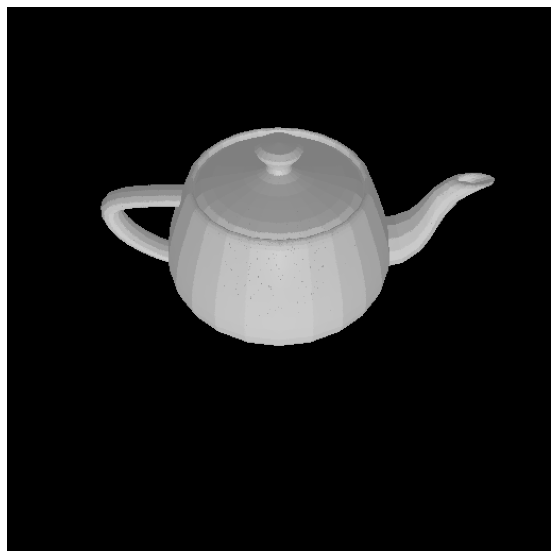

In [18]:
#images = points_renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [26]:
def _apply_lighting(
    points, normals, lights, cameras, materials
): # -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Args:
        points: torch tensor of shape (N, P, 3) or (P, 3).
        normals: torch tensor of shape (N, P, 3) or (P, 3)
        lights: instance of the Lights class.
        cameras: instance of the Cameras class.
        materials: instance of the Materials class.
    Returns:
        ambient_color: same shape as materials.ambient_color
        diffuse_color: same shape as the input points
        specular_color: same shape as the input points
    """
    light_diffuse = lights.diffuse(normals=normals, points=points)
    light_specular = lights.specular(
        normals=normals,
        points=points,
        camera_position=cameras.get_camera_center(),
        shininess=materials.shininess,
    )
    ambient_color = materials.ambient_color * lights.ambient_color
    diffuse_color = materials.diffuse_color * light_diffuse
    specular_color = materials.specular_color * light_specular
    if normals.dim() == 2 and points.dim() == 2:
        # If given packed inputs remove batch dim in output.
        return (
            ambient_color.squeeze(),
            diffuse_color.squeeze(),
            specular_color.squeeze(),
        )
    return ambient_color, diffuse_color, specular_color

print('pixel_coords', pixel_coords.shape)
print('pixel_normals', pixel_normals.shape)
ambient, diffuse, specular = _apply_lighting(
    pixel_coords, pixel_normals, lights, cameras, materials
)

NameError: name 'pixel_coords' is not defined